In [2]:
import numpy as np

import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pickle
import joblib
import time
from datetime import datetime
# from hyperopt import hp
# from hyperopt import fmin, tpe, space_eval
# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
#from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
# function for all accuracy metrics
def accuracy_metrics(y_true, y_pred):
    global MAE, R2
    MAE = mean_absolute_error(y_true, y_pred)
    print("Mean Absolute Error (MAE): %0.5f" % (MAE)) 
    
    RMSE = np.sqrt(((y_pred - y_true) ** 2).mean())
    print("Root Mean Square Error (RMSE): %0.5f" % (RMSE))
    
    MSE = mean_squared_error(y_true, y_pred)
    print("Mean Score Error (MSE): %0.5f" % (MSE))
    
    R2 = r2_score(y_true, y_pred)
    print("R2 Score (R2): %0.5f" % (R2)) 
    
    Median_AE = median_absolute_error(y_true, y_pred)
    print("Median Absolute Error: %0.5f" % (Median_AE)) 
    
    MAPE = np.mean(np.abs((y_true - y_pred)/y_true))*100
    print("Mean Absolute Percentage Error (MAPE): %0.5f" % (MAPE)) 
    
    # MSLE = mean_squared_log_error(y_true, y_pred)
    # print("Mean Squared Log Error: %0.2f\n" % (MSLE))
# Change work directory
#os.chdir(r'C:\Users\ykoyama\OneDrive - Hazen and Sawyer\Documents - GAC ML Modeling Tool - Modeling Technical Details\Modeling and UI Technical Details')


In [3]:
os.chdir(r'C:\Users\YKoyama\OneDrive - Carollo Engineers\General - NAWI 3.13 RO Modeling\Data Request\EDA and Modeling')

In [4]:
daily_df_dict = joblib.load('daily_df_post_EDA_2024-07-11.pkl')
df_C02 = daily_df_dict['C02_daily']
df_E01 = daily_df_dict['E01_daily']
df_H02 = daily_df_dict['H02_daily']



In [58]:
instal_dates = {'C02':datetime(2022, 4, 13), 'E01':datetime(2017, 3, 29),'H02':datetime(2022, 9, 26)}
# Calculate the number of days since installation
df_C02['Days_since_install'] = (df_C02.index - instal_dates['C02']).days
df_H02['Days_since_install'] = (df_H02.index - instal_dates['H02']).days
df_E01['Days_since_install'] = (df_E01.index - instal_dates['E01']).days
df_C02.head()

,Feed psi,Conc Press Stage 1,Feed Press Stage 2,Stage 2-3 Press,Conc psi,Perm Press Stage 1,Perm psi,Perm Flow,Stage 2 Perm Flow,Stage 3 Perm Flow,...,ROF_pH,Stage 1 Norm Percent Salt Passage,Stage 2 Norm Percent Salt Passage,Stage 3 Norm Percent Salt Passage,Cumulative Hours On,CIP,Stage 1 SF First Difference,Stage 2 SF First Difference,Stage 3 SF First Difference,Days_since_install
2022-12-10,152.862173,133.235706,159.286859,145.740899,132.141125,15.338335,15.338335,3470.867691,1133.872292,392.552787,...,6.900015,0.004619,0.005168,0.007435,7.5,NaN,NaN,NaN,NaN,241
2022-12-11,154.726212,135.127192,159.236957,145.632676,131.857868,15.373501,15.373501,3471.728078,1124.935947,402.049977,...,6.899953,0.004838,0.004991,0.006883,31.5,NaN,0.000247,0.000334,0.001421,242
2022-12-12,160.895939,141.348878,168.613879,155.149060,141.473239,15.307395,15.307395,3470.169451,1128.841173,391.429397,...,6.900174,0.003763,0.003885,0.005588,55.5,NaN,-0.002047,-0.003153,-0.004495,243
2022-12-13,166.675895,147.255343,178.833241,165.576945,152.181536,15.263322,15.263322,3473.055145,1134.805372,369.810853,...,6.900343,0.002551,0.002671,0.003918,67.0,NaN,-0.001625,-0.002526,-0.002599,244
2022-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.900040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245


In [54]:
# Assuming df_C02 is your original DataFrame
# predictands = ['Stage 1 SF First Difference', 'Stage 2 SF First Difference', 'Stage 3 SF First Difference']
# for predictand in predictands:
#     df_C02[f'{predictand} (Next Day)'] = df_C02[predictand].shift(-1)

# Now update your predictands list if you want to use all these new columns
#predictands_next_day = [f'{predictand} (Next Day)' for predictand in predictands]
df_C02.head(4)

,Feed psi,Conc Press Stage 1,Feed Press Stage 2,Stage 2-3 Press,Conc psi,Perm Press Stage 1,Perm psi,Perm Flow,Stage 2 Perm Flow,Stage 3 Perm Flow,...,ROF_pH,Stage 1 Norm Percent Salt Passage,Stage 2 Norm Percent Salt Passage,Stage 3 Norm Percent Salt Passage,Cumulative Hours On,CIP,Stage 1 SF First Difference,Stage 2 SF First Difference,Stage 3 SF First Difference,Days_since_install
2022-12-10,152.862173,133.235706,159.286859,145.740899,132.141125,15.338335,15.338335,3470.867691,1133.872292,392.552787,...,6.900015,0.004619,0.005168,0.007435,7.5,NaN,NaN,NaN,NaN,241
2022-12-11,154.726212,135.127192,159.236957,145.632676,131.857868,15.373501,15.373501,3471.728078,1124.935947,402.049977,...,6.899953,0.004838,0.004991,0.006883,31.5,NaN,0.000247,0.000334,0.001421,242
2022-12-12,160.895939,141.348878,168.613879,155.149060,141.473239,15.307395,15.307395,3470.169451,1128.841173,391.429397,...,6.900174,0.003763,0.003885,0.005588,55.5,NaN,-0.002047,-0.003153,-0.004495,243
2022-12-13,166.675895,147.255343,178.833241,165.576945,152.181536,15.263322,15.263322,3473.055145,1134.805372,369.810853,...,6.900343,0.002551,0.002671,0.003918,67.0,NaN,-0.001625,-0.002526,-0.002599,244


In [59]:
import pandas as pd
import numpy as np
from scipy import stats

def weekly_slope(group):
    # Remove NA values
    group = group.dropna()
    
    # If less than 2 non-NA values, return NA
    if len(group) < 2:
        return np.nan
    
    x = np.arange(len(group))
    slope, _, _, _, _ = stats.linregress(x, group)
    return slope

def aggregate_weekly(df, predictands):
    # Ensure the index is datetime
    df.index = pd.to_datetime(df.index)
    
    # Create a copy of the dataframe
    df_weekly = df.copy()
    
    # Add a column for the week start date (Monday)
    df_weekly['Week_Start'] = df_weekly.index - pd.to_timedelta(df_weekly.index.dayofweek, unit='D')
    
    # Separate predictands and other columns
    other_columns = [col for col in df.columns if col not in predictands]
    
    # Aggregate other columns by mean
    agg_dict = {col: 'mean' for col in other_columns}
    
    # Aggregate predictands by slope
    for col in predictands:
        agg_dict[col] = weekly_slope
    
    # Perform weekly aggregation
    df_weekly = df_weekly.groupby('Week_Start').agg(agg_dict)
    
    return df_weekly

# Assuming df is your daily dataframe and predictands is your list of predictand columns
predictands = ['Stage 1 SF First Difference', 'Stage 2 SF First Difference', 'Stage 3 SF First Difference']

# Perform weekly aggregation
C02_weekly = aggregate_weekly(df_C02, predictands)
H02_weekly = aggregate_weekly(df_H02, predictands)
E01_weekly = aggregate_weekly(df_E01, predictands)
# Perform shift by 1 week
for predictand in predictands:
    C02_weekly[f'{predictand} (Next Week)'] = C02_weekly[predictand].shift(-1)
    H02_weekly[f'{predictand} (Next Week)'] = C02_weekly[predictand].shift(-1)
    E01_weekly[f'{predictand} (Next Week)'] = C02_weekly[predictand].shift(-1)
# Display the result
C02_weekly.head()

,Feed psi,Conc Press Stage 1,Feed Press Stage 2,Stage 2-3 Press,Conc psi,Perm Press Stage 1,Perm psi,Perm Flow,Stage 2 Perm Flow,Stage 3 Perm Flow,...,Stage 3 Norm Percent Salt Passage,Cumulative Hours On,CIP,Days_since_install,Stage 1 SF First Difference,Stage 2 SF First Difference,Stage 3 SF First Difference,Stage 1 SF First Difference (Next Week),Stage 2 SF First Difference (Next Week),Stage 3 SF First Difference (Next Week)
Week_Start,,,,,,,,,,,,,,,,,,,,,
2022-12-05,153.794193,134.181449,159.261908,145.686788,131.999496,15.355918,15.355918,3471.297885,1129.404119,397.301382,...,0.007159,19.500000,NaN,239.0,NaN,NaN,NaN,0.000500,0.000887,0.001384
2022-12-12,166.881943,147.516860,178.585494,165.524922,152.321377,15.251382,15.251382,3471.696955,1128.910647,363.661396,...,0.004333,129.416667,NaN,246.0,0.000500,0.000887,0.001384,-0.000118,-0.000069,-0.000002
2022-12-19,173.187058,154.091933,186.303200,173.800356,161.168122,15.473663,15.473663,3452.764405,1115.281387,345.648766,...,0.003632,295.214286,NaN,253.0,-0.000118,-0.000069,-0.000002,0.000199,0.000370,0.000508
2022-12-26,171.461614,152.041487,183.815346,171.027331,157.993593,15.151703,15.151703,3467.593520,1123.043703,359.407529,...,0.004334,477.600000,NaN,260.0,0.000199,0.000370,0.000508,-0.000011,-0.000008,-0.000043
2023-01-02,175.834362,156.277911,188.204419,175.327298,162.213083,15.150426,15.150426,3468.759839,1120.766796,364.136227,...,0.003925,631.500000,NaN,267.0,-0.000011,-0.000008,-0.000043,-0.000075,-0.000023,0.000005


In [60]:
predictands_shift1 = [f'{predictand} (Next Week)' for predictand in predictands]
predictands_shift1

['Stage 1 SF First Difference (Next Week)',
 'Stage 2 SF First Difference (Next Week)',
 'Stage 3 SF First Difference (Next Week)']

# Addn Data Cleaning Functions

In [9]:
def drop_high_nan_columns(df, threshold=0.5):
    """
    Drop columns from a DataFrame that have a higher percentage of NaN values than the specified threshold.
    
    :param df: pandas DataFrame
    :param threshold: float, percentage threshold for NaN values (default: 0.5, i.e., 50%)
    :return: pandas DataFrame with high-NaN columns removed
    """
    # Calculate the percentage of NaN values in each column
    nan_percentage = df.isnull().mean()
    
    # Identify columns to drop
    columns_to_drop = nan_percentage[nan_percentage > threshold].index
    
    # Drop the identified columns
    df_cleaned = df.drop(columns=columns_to_drop)
    
    print(f"Dropped {len(columns_to_drop)} columns: {list(columns_to_drop)}")
    
    return df_cleaned

In [61]:
C02_weekly = drop_high_nan_columns(C02_weekly, 0.5)
H02_weekly = drop_high_nan_columns(H02_weekly, 0.5)
E01_weekly = drop_high_nan_columns(E01_weekly, 0.5)

Dropped 19 columns: ['Unnamed: 19', 'Calc Conc Corr factor', 'Calc 2-3 Cond', 'Calc Conc Cond', 'Stage 1 Bucket Flow', 'Stage 2 Bucket Flow', 'Stage 3 Bucket Flow', 'Stage 1 Flow EST', 'Stage 2 Flow EST', 'Stage 3 Flow EST', 'Total', 'stage 1 bucket EC', 'stage 2 bucket EC', 'stage 3 bucket EC', 'Unnamed: 75', 'Unnamed: 77', 'Unnamed: 91', 'Unnamed: 93', 'CIP']
Dropped 21 columns: ['Stage 2-3 EC', 'Calc Conc EC', 'Stage 1 Bucket Flow', 'Stage 2 Bucket Flow', 'Stage 3 Bucket Flow', 'Stage 1 Flow EST', 'Stage 2 Flow EST', 'Stage 3 Flow EST', 'Total', 'Membrane psi', 'stage 1 bucket EC', 'stage 2 bucket EC', 'stage 3 bucket EC', 'combined bucket EC', 'Unnamed: 75', 'Unnamed: 76', 'Unnamed: 77', 'Unnamed: 91', 'Unit  AFBC Norm Percent Removal', 'Unnamed: 93', 'CIP']
Dropped 19 columns: ['Unnamed: 19', 'Calc Conc Corr factor', 'Calc 2-3 Cond', 'Calc Conc Cond', 'Stage 1 Bucket Flow', 'Stage 2 Bucket Flow', 'Stage 3 Bucket Flow', 'Stage 1 Flow EST', 'Stage 2 Flow EST', 'Stage 3 Flow EST', 'T

# Scale predictands

## C02

In [60]:
df_C02.index.max()

Timestamp('2023-12-03 00:00:00')

In [91]:
from sklearn.preprocessing import MinMaxScaler

# Assuming your DataFrame is called 'df' and the column is 'yhat'
temp= df_C02[['Stage 1 SF First Difference']]
temp['Date']=temp.index
temp.columns = ['y', 'ds']
# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the data
temp['y'] = scaler.fit_transform(temp[['y']])
temp.dropna(inplace=True)
print(temp.head())

                   y         ds
2022-12-11  0.474211 2022-12-11
2022-12-12  0.353073 2022-12-12
2022-12-13  0.375359 2022-12-13
2022-12-16  0.391362 2022-12-16
2022-12-17  0.452806 2022-12-17


# FB prophet for C02

In [92]:
# prep for modeling


# df_train = temp.loc[:'2023-11-03']
# df_test = temp.loc['2023-11-04':]
split_point = int(len(temp) * 0.85)  # 80% train, 20% test
df_train = temp.iloc[:split_point]
df_test = temp.iloc[split_point:]


In [93]:
print(temp.index.duplicated().any())

False


## Base model

In [94]:
from prophet import Prophet
m = Prophet()
m.fit(df_train)

08:45:56 - cmdstanpy - INFO - Chain [1] start processing
08:45:56 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Train+Test Periods')

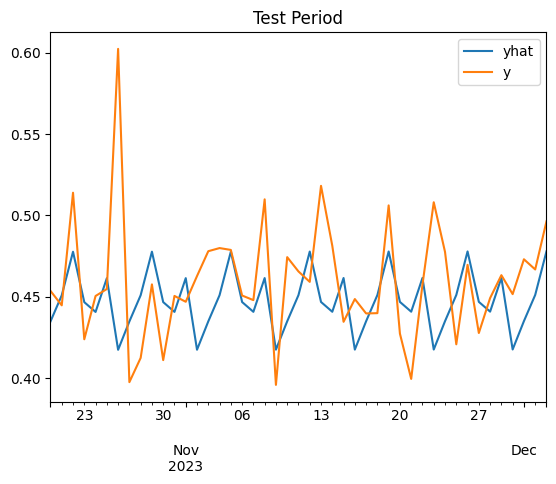

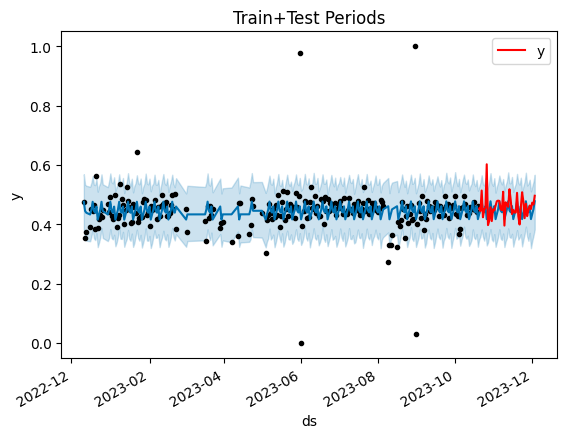

In [95]:
future = m.make_future_dataframe(periods=len(df_test))
future.head()
forecast = m.predict(future)
forecast.head()
pred_df = forecast[['yhat','ds']]
pred_df.set_index('ds',inplace=True)
pred_df
test_df = df_test.merge(pred_df[['yhat']],how='left',left_index=True, right_index=True)
test_df = test_df[['yhat','y']]
test_df.head()
test_df.plot()
plt.title('Test Period')
f, ax = plt.subplots(1)
fig = m.plot(forecast, ax=ax)
test_df[['y']].plot(ax=ax,color='red')
plt.title('Train+Test Periods')

In [99]:
test_df.dropna(inplace=True)
# To transform back to the original scale
test_df['y_original'] = scaler.inverse_transform(test_df[['y']])
test_df['yhat_original'] = scaler.inverse_transform(test_df[['yhat']])
accuracy_metrics(test_df['y_original'], test_df['yhat_original'])

Mean Absolute Error (MAE): 0.00055
Root Mean Square Error (RMSE): 0.00078
Mean Score Error (MSE): 0.00000
R2 Score (R2): -0.26349
Median Absolute Error: 0.00041
Mean Absolute Percentage Error (MAPE): 217.89112


## tuning prophet

In [82]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [84]:
actual_values, abs(predicted_values)

(2023-08-26   -0.000491
 2023-08-27    0.000051
 2023-08-28   -0.000904
 2023-08-29   -0.000796
 2023-08-30    0.010204
 2023-08-31   -0.008183
 2023-09-01   -0.001166
 2023-09-02    0.000200
 2023-09-03   -0.000320
 2023-09-04   -0.000752
 2023-09-05    0.000667
 2023-09-06   -0.001527
 2023-09-07   -0.000508
 2023-09-08   -0.000802
 2023-09-09    0.000319
 2023-09-10    0.000002
 2023-09-11   -0.000324
 2023-09-12   -0.000080
 2023-09-13   -0.000251
 2023-09-14   -0.000258
 2023-09-15    0.000252
 2023-09-16   -0.000055
 2023-09-17    0.000064
 2023-09-18   -0.000616
 2023-09-19    0.000007
 2023-09-20   -0.000156
 2023-09-21   -0.000152
 2023-09-22   -0.000570
 2023-09-23    0.000654
 2023-09-24    0.000027
 2023-09-25    0.000127
 2023-09-26   -0.000776
 2023-09-27   -0.000087
 2023-09-28   -0.000085
 2023-09-29    0.000064
 2023-09-30   -0.000005
 2023-10-01    0.000672
 2023-10-02   -0.000516
 2023-10-03   -0.000624
 2023-10-04   -0.001806
 2023-10-05   -0.001440
 2023-10-06   -0

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid, train_test_split
from prophet import Prophet
import random

# Define the parameter grid
params_grid = {
    'seasonality_mode': ['multiplicative'],
    'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_changepoints': [5, 10, 100, 1000]
}
grid = ParameterGrid(params_grid)

print('Total Possible Models', len(grid))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Split df_train into training and validation sets
train_data, val_data = train_test_split(df_train, test_size=0.2, shuffle=False)

model_parameters = pd.DataFrame(columns=['MAPE', 'Parameters'])

for p in grid:
    print(p)
    random.seed(0)
    
    train_model = Prophet(
        changepoint_prior_scale=p['changepoint_prior_scale'],
        n_changepoints=p['n_changepoints'],
        seasonality_mode=p['seasonality_mode'],
        weekly_seasonality=True,
        daily_seasonality=True,
        yearly_seasonality=True,
        interval_width=0.95
    )
    
    train_model.fit(train_data)
    
    # Make predictions for the validation period
    val_forecast = train_model.make_future_dataframe(periods=len(val_data), include_history=False)
    val_forecast = train_model.predict(val_forecast)
    
    # Prepare actual and predicted values for MAPE calculation
    actual_values = val_data['y']
    predicted_values = val_forecast['yhat']
    
    # Calculate MAPE
    MAPE = mean_absolute_percentage_error(actual_values, abs(predicted_values))
    print('Mean Absolute Percentage Error (MAPE):', MAPE)
    
    # Use concat instead of append
    model_parameters = pd.concat([model_parameters, 
                                  pd.DataFrame({'MAPE': [MAPE], 'Parameters': [p]})], 
                                 ignore_index=True)

# Find the best model
best_model = model_parameters.loc[model_parameters['MAPE'].idxmin()]
print("Best model parameters:", best_model['Parameters'])
print("Best model MAPE:", best_model['MAPE'])

# Train the final model on the entire training set using the best parameters
final_model = Prophet(
    changepoint_prior_scale=best_model['Parameters']['changepoint_prior_scale'],
    n_changepoints=best_model['Parameters']['n_changepoints'],
    seasonality_mode=best_model['Parameters']['seasonality_mode'],
    weekly_seasonality=True,
    daily_seasonality=True,
    yearly_seasonality=True,
    interval_width=0.95
)
final_model.fit(df_train)

# Make predictions on the test set
test_forecast = final_model.make_future_dataframe(periods=len(df_test), include_history=False)
test_forecast = final_model.predict(test_forecast)

# Calculate MAPE on the test set
test_MAPE = mean_absolute_percentage_error(df_test['y'], abs(test_forecast['yhat']))
print("Test set MAPE:", test_MAPE)

08:38:09 - cmdstanpy - INFO - Chain [1] start processing


Total Possible Models 20
{'changepoint_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


08:38:09 - cmdstanpy - INFO - Chain [1] done processing
08:38:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 1371.7608465553337
{'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


08:38:09 - cmdstanpy - INFO - Chain [1] done processing
08:38:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 1111.130114043012
{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


08:38:10 - cmdstanpy - INFO - Chain [1] done processing
08:38:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 951.866730443415
{'changepoint_prior_scale': 0.1, 'n_changepoints': 1000, 'seasonality_mode': 'multiplicative'}


08:38:10 - cmdstanpy - INFO - Chain [1] done processing
08:38:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 1013.2231433234216
{'changepoint_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


08:38:10 - cmdstanpy - INFO - Chain [1] done processing
08:38:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 3161.129247144616
{'changepoint_prior_scale': 0.2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


08:38:11 - cmdstanpy - INFO - Chain [1] done processing
08:38:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 2844.0321276427844
{'changepoint_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


08:38:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error (MAPE): 1048.6205977274315
{'changepoint_prior_scale': 0.2, 'n_changepoints': 1000, 'seasonality_mode': 'multiplicative'}


08:38:11 - cmdstanpy - INFO - Chain [1] start processing
08:38:11 - cmdstanpy - INFO - Chain [1] done processing
08:38:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 949.0536840319386
{'changepoint_prior_scale': 0.3, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


08:38:12 - cmdstanpy - INFO - Chain [1] done processing
08:38:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 7323.668452641418
{'changepoint_prior_scale': 0.3, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


08:38:12 - cmdstanpy - INFO - Chain [1] done processing
08:38:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 3370.6126321104102
{'changepoint_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


08:38:12 - cmdstanpy - INFO - Chain [1] done processing
08:38:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 1160.355668617262
{'changepoint_prior_scale': 0.3, 'n_changepoints': 1000, 'seasonality_mode': 'multiplicative'}


08:38:13 - cmdstanpy - INFO - Chain [1] done processing
08:38:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 1174.3559886396486
{'changepoint_prior_scale': 0.4, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


08:38:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error (MAPE): 7740.183024400272
{'changepoint_prior_scale': 0.4, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


08:38:13 - cmdstanpy - INFO - Chain [1] start processing
08:38:13 - cmdstanpy - INFO - Chain [1] done processing
08:38:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 7860.431638099544
{'changepoint_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


08:38:14 - cmdstanpy - INFO - Chain [1] done processing
08:38:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 1504.593751007098
{'changepoint_prior_scale': 0.4, 'n_changepoints': 1000, 'seasonality_mode': 'multiplicative'}


08:38:14 - cmdstanpy - INFO - Chain [1] done processing
08:38:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 1326.818908131288
{'changepoint_prior_scale': 0.5, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


08:38:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error (MAPE): 7661.791887883896
{'changepoint_prior_scale': 0.5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


08:38:14 - cmdstanpy - INFO - Chain [1] start processing
08:38:15 - cmdstanpy - INFO - Chain [1] done processing
08:38:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 1362.9122102572524
{'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


08:38:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error (MAPE): 860.5637250831876
{'changepoint_prior_scale': 0.5, 'n_changepoints': 1000, 'seasonality_mode': 'multiplicative'}


08:38:15 - cmdstanpy - INFO - Chain [1] start processing
08:38:16 - cmdstanpy - INFO - Chain [1] done processing
08:38:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error (MAPE): 1622.8358917924022
Best model parameters: {'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Best model MAPE: 860.5637250831876


08:38:16 - cmdstanpy - INFO - Chain [1] done processing


Test set MAPE: 556.3797330591665


In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['multiplicative']), #,'additive'
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              #'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [5,10,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 15


In [ ]:
import random
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
df_test.head(), df_test.tail()

(                 y         ds
 Date                         
 2024-02-05  141.64 2024-02-05
 2024-02-06  137.21 2024-02-06
 2024-02-07  133.01 2024-02-07
 2024-02-08  129.28 2024-02-08
 2024-02-09  126.19 2024-02-09,
                  y         ds
 Date                         
 2024-03-01  125.88 2024-03-01
 2024-03-02  130.38 2024-03-02
 2024-03-03  132.44 2024-03-03
 2024-03-04  139.18 2024-03-04
 2024-03-05  142.13 2024-03-05)

In [ ]:
strt='2023-10-16'
end='2023-10-29'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                        # holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         #holidays=holiday, 
                         interval_width=0.95)
    #train_model.add_country_holidays(country_name='US')
    train_model.fit(df_train)
    train_forecast = train_model.make_future_dataframe(periods=14, include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = temp[(temp['ds']>=strt) & (temp['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


14:58:31 - cmdstanpy - INFO - Chain [1] start processing
14:58:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 86.8078935000906
{'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


14:58:33 - cmdstanpy - INFO - Chain [1] start processing
14:58:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 20.12624079014155
{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:58:34 - cmdstanpy - INFO - Chain [1] start processing
14:58:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.7585081898772015
{'changepoint_prior_scale': 0.2, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


14:58:37 - cmdstanpy - INFO - Chain [1] start processing
14:58:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 82.96481042356086
{'changepoint_prior_scale': 0.2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


14:58:38 - cmdstanpy - INFO - Chain [1] start processing
14:58:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 19.234081010673716
{'changepoint_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:58:39 - cmdstanpy - INFO - Chain [1] start processing
14:58:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.898254611773215
{'changepoint_prior_scale': 0.3, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


14:58:42 - cmdstanpy - INFO - Chain [1] start processing
14:58:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 82.07896413453769
{'changepoint_prior_scale': 0.3, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


14:58:43 - cmdstanpy - INFO - Chain [1] start processing
14:58:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 18.060497489635157
{'changepoint_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:58:45 - cmdstanpy - INFO - Chain [1] start processing
14:58:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 2.576446046747782
{'changepoint_prior_scale': 0.4, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


14:58:48 - cmdstanpy - INFO - Chain [1] start processing
14:58:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 82.8728550362223
{'changepoint_prior_scale': 0.4, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


14:58:49 - cmdstanpy - INFO - Chain [1] start processing
14:58:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 18.11111671835717
{'changepoint_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:58:50 - cmdstanpy - INFO - Chain [1] start processing
14:58:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 3.1262715871083
{'changepoint_prior_scale': 0.5, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


14:58:53 - cmdstanpy - INFO - Chain [1] start processing
14:58:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 81.0411644428641
{'changepoint_prior_scale': 0.5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


14:58:54 - cmdstanpy - INFO - Chain [1] start processing
14:58:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.89246319921685
{'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


14:58:55 - cmdstanpy - INFO - Chain [1] start processing
14:58:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 4.570713147712808


C:\Users\YKoyama\AppData\Local\Temp\ipykernel_28812\355981706.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)


# Multi-feature ML for C02

## Feature selection

In [11]:
predictands_shift1[0], predictands[0]

('Stage 1 SF First Difference (Next Week)', 'Stage 1 SF First Difference')

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


df = C02_weekly.dropna(subset=[predictands_shift1[0],predictands[0]])

# Define features and label
label_column = predictands_shift1[0]
labels = df[[label_column]]
features = df.drop(columns=[label_column]+predictands[1:]+predictands_shift1[1:])
features = drop_high_nan_columns(features,0.5)
# Create scalers
label_scaler = StandardScaler()
feature_scaler = StandardScaler()

# Fit and transform
labels_scaled = label_scaler.fit_transform(labels)
features_scaled = feature_scaler.fit_transform(features)

# Create dictionaries mapping array indices to column names
label_dict = {0: label_column}
feature_dict = {i: col for i, col in enumerate(features.columns)}

# Create DataFrames with scaled values and original column names
labels_scaled_df = pd.DataFrame(labels_scaled, columns=[label_column], index=df.index)
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=df.index)

# Print the dictionaries and the first few rows of the scaled DataFrames
print("Label Dictionary:", label_dict)
print("Feature Dictionary:", feature_dict)
print("\nScaled Labels:")
print(labels_scaled_df.head())
print("\nScaled Features:")
print(features_scaled_df.head())

Dropped 0 columns: []
Label Dictionary: {0: 'Stage 1 SF First Difference (Next Week)'}
Feature Dictionary: {0: 'Feed psi', 1: 'Conc Press Stage 1', 2: 'Feed Press Stage 2', 3: 'Stage 2-3 Press', 4: 'Conc psi', 5: 'Perm Press Stage 1', 6: 'Perm psi', 7: 'Perm Flow', 8: 'Stage 2 Perm Flow', 9: 'Stage 3  Perm Flow', 10: 'Conc flow', 11: 'Perm EC', 12: 'Perm EC Stage 1', 13: 'Perm EC Stage 2', 14: 'Perm EC Stage 3', 15: 'Conc EC', 16: 'kWh Feed Pump', 17: 'ERD/IBP          kW', 18: 'Temp (C.)', 19: 'TCF Water', 20: 'Calc Perm EC', 21: 'Feed Flow', 22: 'Stage 1 Perm Flow', 23: 'Stage 1-2 Feed Flow', 24: 'Stage 2-3 Feed Flow', 25: '1st Pass dp', 26: '2nd Pass dp', 27: '3rd Pass dp', 28: 'Stage 1 Flux', 29: 'Stage 2 Flux', 30: 'Stage 3 Flux', 31: 'Stage 1-2 EC', 32: 'Stage 2-3 EC', 33: 'Calc Conc EC', 34: 'Stage 1 AFBC', 35: 'Stage 2 AFBC', 36: 'Stage 3 AFBC', 37: 'Stage 1 SF', 38: 'Stage 2 SF', 39: 'Stage 3 SF', 40: 'Stage 1 NdeltaP', 41: 'Stage 2 NdeltaP', 42: 'Stage 3 NdeltaP', 43: 'Stage 

In [137]:
# # # Count NaNs in each column, next step is to drop columns with NaNs
# nan_counts = df.isna().sum()

# nan_counts=pd.DataFrame(nan_counts)
# for index, row in nan_counts.iterrows():
#     print(row)

In [184]:
# print(features.shape)
# print(labels.shape)
# print(features.dtypes)
# #print(labels.dtype)
# print(features.isnull().sum())
# print(np.isinf(features).sum())
# print(labels.nunique())

### MRMR

In [13]:
# for 1st stage
from mrmr import mrmr_classif
selected_features = mrmr_classif(X=features, y=labels, K=5)
selected_features

0it [00:00, ?it/s]


[]

### Spearman

In [16]:
import pandas as pd
import numpy as np
from scipy import stats

def top_spearman_correlated_features(X, y, k):
    """
    Calculate Spearman correlation between features and label,
    and return the top k features based on absolute correlation.

    Parameters:
    X (pd.DataFrame): DataFrame containing the features
    y (pd.Series or np.array): Target variable
    k (int): Number of top features to return

    Returns:
    pd.DataFrame: Top k features with their Spearman correlation coefficients
    """
    # Ensure X is a DataFrame and y is a Series
    X = pd.DataFrame(X)
    y = pd.Series(y)

    # Calculate Spearman correlation for each feature
    correlations = {}
    for column in X.columns:
        correlation, _ = stats.spearmanr(X[column], y)
        correlations[column] = correlation  # Store actual correlation (not absolute)

    # Create a DataFrame from the correlations
    corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
    corr_df.index.name = 'Feature'

    # Sort features by absolute correlation (descending order)
    corr_df = corr_df.reindex(corr_df['Correlation'].abs().sort_values(ascending=False).index)

    # Get top k features
    top_k_features = corr_df.head(k)

    return top_k_features

# Example usage:
# X = your_feature_dataframe
# y = your_target_variable
# k = 10  # Number of top features you want

# result = top_spearman_correlated_features(X, y, k)
# print(result)

In [17]:
labels.head()

,Stage 1 SF First Difference (Next Week)
Week_Start,
2022-12-12,-0.000118
2022-12-19,0.000199
2022-12-26,-0.000011
2023-01-02,-0.000075
2023-01-09,0.000456


In [18]:
features.head()

,Feed psi,Conc Press Stage 1,Feed Press Stage 2,Stage 2-3 Press,Conc psi,Perm Press Stage 1,Perm psi,Perm Flow,Stage 2 Perm Flow,Stage 3 Perm Flow,...,ROF_NH3,ROF_EC,ROF_ROF TOC,ROF_Cl2,ROF_pH,Stage 1 Norm Percent Salt Passage,Stage 2 Norm Percent Salt Passage,Stage 3 Norm Percent Salt Passage,Cumulative Hours On,Stage 1 SF First Difference
Week_Start,,,,,,,,,,,,,,,,,,,,,
2022-12-12,166.881943,147.516860,178.585494,165.524922,152.321377,15.251382,15.251382,3471.696955,1128.910647,363.661396,...,5.618114,2321.265636,7.433671,4.119476,6.900057,0.002765,0.002915,0.004333,129.416667,0.000500
2022-12-19,173.187058,154.091933,186.303200,173.800356,161.168122,15.473663,15.473663,3452.764405,1115.281387,345.648766,...,11.391652,2630.608061,7.065320,3.989981,6.899987,0.002295,0.002419,0.003632,295.214286,-0.000118
2022-12-26,171.461614,152.041487,183.815346,171.027331,157.993593,15.151703,15.151703,3467.593520,1123.043703,359.407529,...,9.414998,2381.464798,7.258061,4.417688,6.900221,0.002650,0.002922,0.004334,477.600000,0.000199
2023-01-02,175.834362,156.277911,188.204419,175.327298,162.213083,15.150426,15.150426,3468.759839,1120.766796,364.136227,...,7.868498,2442.582692,6.957197,3.674809,6.897858,0.002421,0.002620,0.003925,631.500000,-0.000011
2023-01-09,176.566989,156.862298,188.560563,175.493589,162.320650,15.163538,15.163538,3465.220612,1119.250006,371.403871,...,6.601813,2336.383984,7.422158,3.876883,6.900016,0.002595,0.002789,0.003988,799.500000,-0.000075


In [19]:
pd.Series(labels.values[:,0])

0    -0.000118
1     0.000199
2    -0.000011
3    -0.000075
4     0.000456
5     0.000272
6     0.000154
7     0.000147
8     0.000068
9    -0.000639
10   -0.001447
11    0.000096
12    0.000174
13    0.001112
14    0.000148
15    0.000232
16    0.000093
17   -0.000415
18    0.000066
19    0.000003
20    0.000106
21    0.000064
22    0.000049
23    0.000089
24    0.000086
25   -0.000020
26    0.000089
27    0.000521
28    0.000583
29    0.000119
30   -0.000272
31    0.000082
32    0.000061
33    0.000100
34    0.000119
35    0.000223
36    0.000020
37    0.000080
38   -0.000022
39    0.000198
40    0.000017
41   -0.000077
42    0.000128
43    0.000170
dtype: float64

In [20]:
Xs_df = top_spearman_correlated_features(features, labels.values[:,0], 15)
list(Xs_df.index.values)

['GWRS-ROF_Ca_mg/L',
 'GWRS-ROC_K_mg/L',
 'GWRS-ROF_SiO2_mg/L',
 'GWRS-ROP_Cl_mg/L',
 'GWRS-ROC_Mg_mg/L',
 'GWRS-ROC_Na_mg/L',
 'GWRS-ROF_K_mg/L',
 'Stage 1-2 Feed Flow',
 'GWRS-ROF_Na_mg/L',
 'GWRS-ROC_Ca_mg/L',
 '2nd Pass dp',
 'Stage 1 SF First Difference',
 'Stage 2-3 Feed Flow',
 'GWRS-ROC_Cu_ug/L',
 'GWRS-ROP_SO4_mg/L']

In [163]:
# for c in features.columns:
#     print("'"+c+"',")

## Preprocessing data for C02

In [21]:
# selected_Xs= [ 'Temp (C.)','combined bucket EC','Calc Conc EC','kWh Feed Pump','Feed Flow','GWRS-ROF_Alkalinity (CaCO3)_mg/L','Cumulative Hours On','FEED_NH3',
# 'FEED_NTU',
# 'ROF_NH3',
# 'ROF_EC',
# 'ROF_ROF TOC',
# 'ROF_Cl2',
# 'ROF_pH','GWRS-ROF_NO3-N_mg/L','GWRS-Q1_Total Nitrogen_mg/L','GWRS-ROF_Fe_ug/L','GWRS-ROF_Cu_ug/L','GWRS-ROF_Ca_mg/L','GWRS-ROF_Mg_mg/L','GWRS-ROF_K_mg/L','GWRS-ROF_Na_mg/L','GWRS-ROF_SO4_mg/L',
# 'GWRS-ROF_Cl_mg/L','GWRS-Q1_F_mg/L','GWRS-ROF_SiO2_mg/L','DayOfYear','Flow Weighted Average Feed Pressure ']

#features_s = features[top_spearman_correlated_features(features, labels, 15)]

In [22]:
selected_Xs=top_spearman_correlated_features(features, labels.values[:,0], 15)
features_s = features[list(selected_Xs.index.values)]
# Create scalers
label_scaler = StandardScaler()
feature_scaler = StandardScaler()

# Fit and transform
labels_scaled = label_scaler.fit_transform(labels)
features_scaled = feature_scaler.fit_transform(features_s)

# Create dictionaries mapping array indices to column names
label_dict = {0: label_column}
feature_dict = {i: col for i, col in enumerate(features.columns)}

# Create DataFrames with scaled values and original column names
labels_scaled_df = pd.DataFrame(labels_scaled, columns=[label_column], index=df.index)
features_scaled_df = pd.DataFrame(features_scaled, columns=features_s.columns, index=df.index)

# Print the dictionaries and the first few rows of the scaled DataFrames
print("Label Dictionary:", label_dict)
print("Feature Dictionary:", feature_dict)
print("\nScaled Labels:")
print(labels_scaled_df.head())
print("\nScaled Features:")
print(features_scaled_df.head())

Label Dictionary: {0: 'Stage 1 SF First Difference (Next Week)'}
Feature Dictionary: {0: 'Feed psi', 1: 'Conc Press Stage 1', 2: 'Feed Press Stage 2', 3: 'Stage 2-3 Press', 4: 'Conc psi', 5: 'Perm Press Stage 1', 6: 'Perm psi', 7: 'Perm Flow', 8: 'Stage 2 Perm Flow', 9: 'Stage 3  Perm Flow', 10: 'Conc flow', 11: 'Perm EC', 12: 'Perm EC Stage 1', 13: 'Perm EC Stage 2', 14: 'Perm EC Stage 3', 15: 'Conc EC', 16: 'kWh Feed Pump', 17: 'ERD/IBP          kW', 18: 'Temp (C.)', 19: 'TCF Water', 20: 'Calc Perm EC', 21: 'Feed Flow', 22: 'Stage 1 Perm Flow', 23: 'Stage 1-2 Feed Flow', 24: 'Stage 2-3 Feed Flow', 25: '1st Pass dp', 26: '2nd Pass dp', 27: '3rd Pass dp', 28: 'Stage 1 Flux', 29: 'Stage 2 Flux', 30: 'Stage 3 Flux', 31: 'Stage 1-2 EC', 32: 'Stage 2-3 EC', 33: 'Calc Conc EC', 34: 'Stage 1 AFBC', 35: 'Stage 2 AFBC', 36: 'Stage 3 AFBC', 37: 'Stage 1 SF', 38: 'Stage 2 SF', 39: 'Stage 3 SF', 40: 'Stage 1 NdeltaP', 41: 'Stage 2 NdeltaP', 42: 'Stage 3 NdeltaP', 43: 'Stage 1 NPC', 44: 'Stage 2 N

# Modeling for C02

In [1]:
test_labels

NameError: name 'test_labels' is not defined

In [203]:
train_features, test_features, train_labels, test_labels=train_test_split(features_scaled, labels_scaled, test_size=0.1, shuffle=False)

In [207]:
labels_scaled.shape

(44, 1)

## Plot potential features and target

In [48]:
# Example usage of backward elimination
selected_Xs = top_spearman_correlated_features(features, labels.values[:,0], 15)
features_s = features[list(selected_Xs.index.values)]
#list(selected_Xs.index.values)
# drop arbitrary columns
features_s.drop(columns=['GWRS-ROC_Na_mg/L','GWRS-ROC_Ca_mg/L','GWRS-ROC_K_mg/L'], inplace=True)


GWRS-ROF_Ca_mg/L


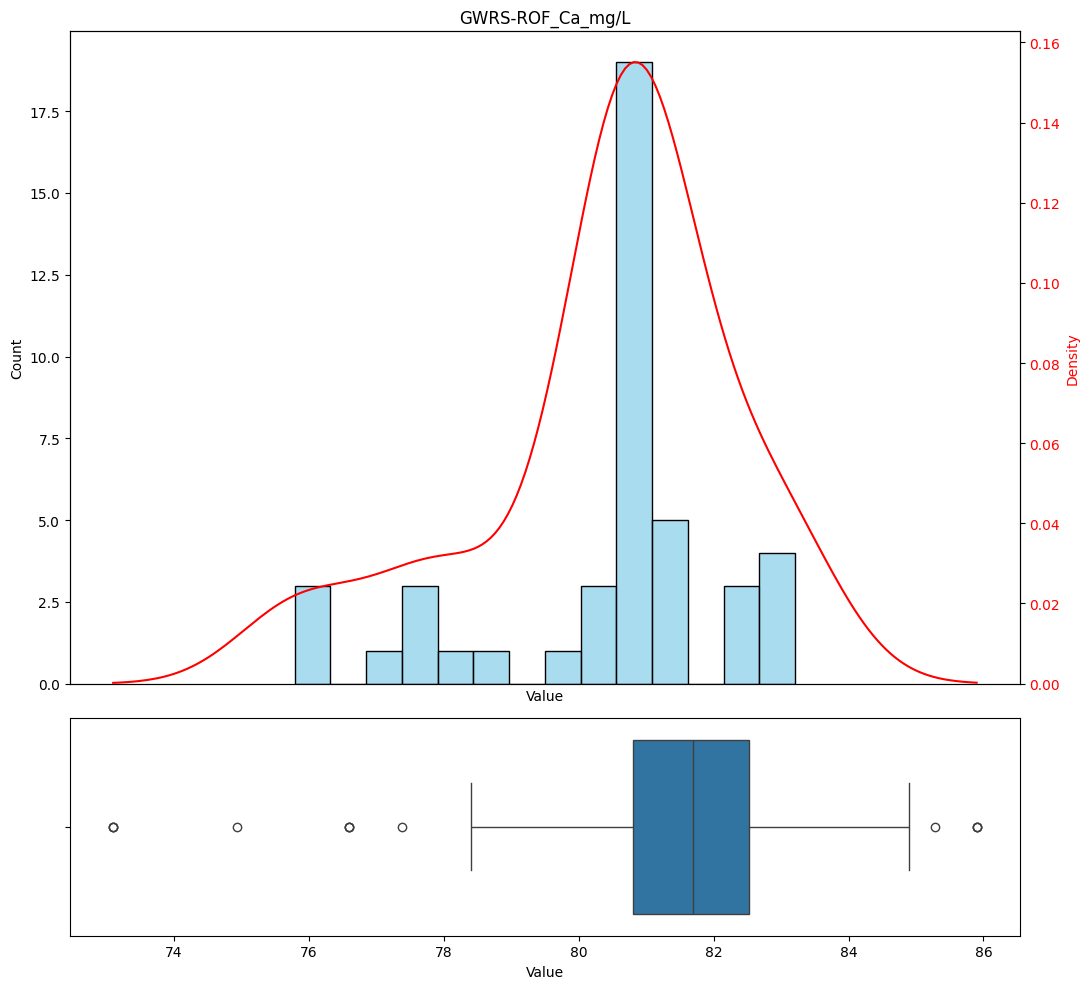

GWRS-ROF_SiO2_mg/L


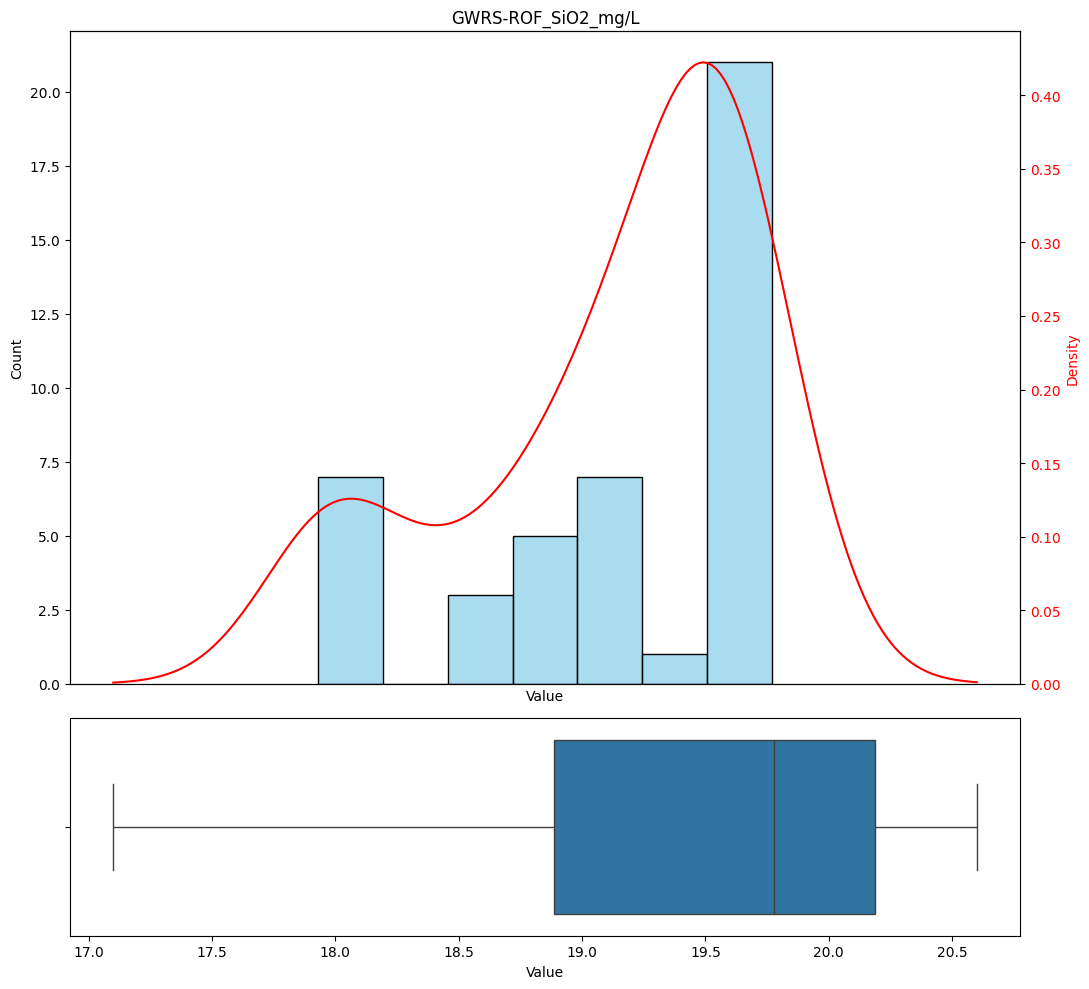

GWRS-ROP_Cl_mg/L


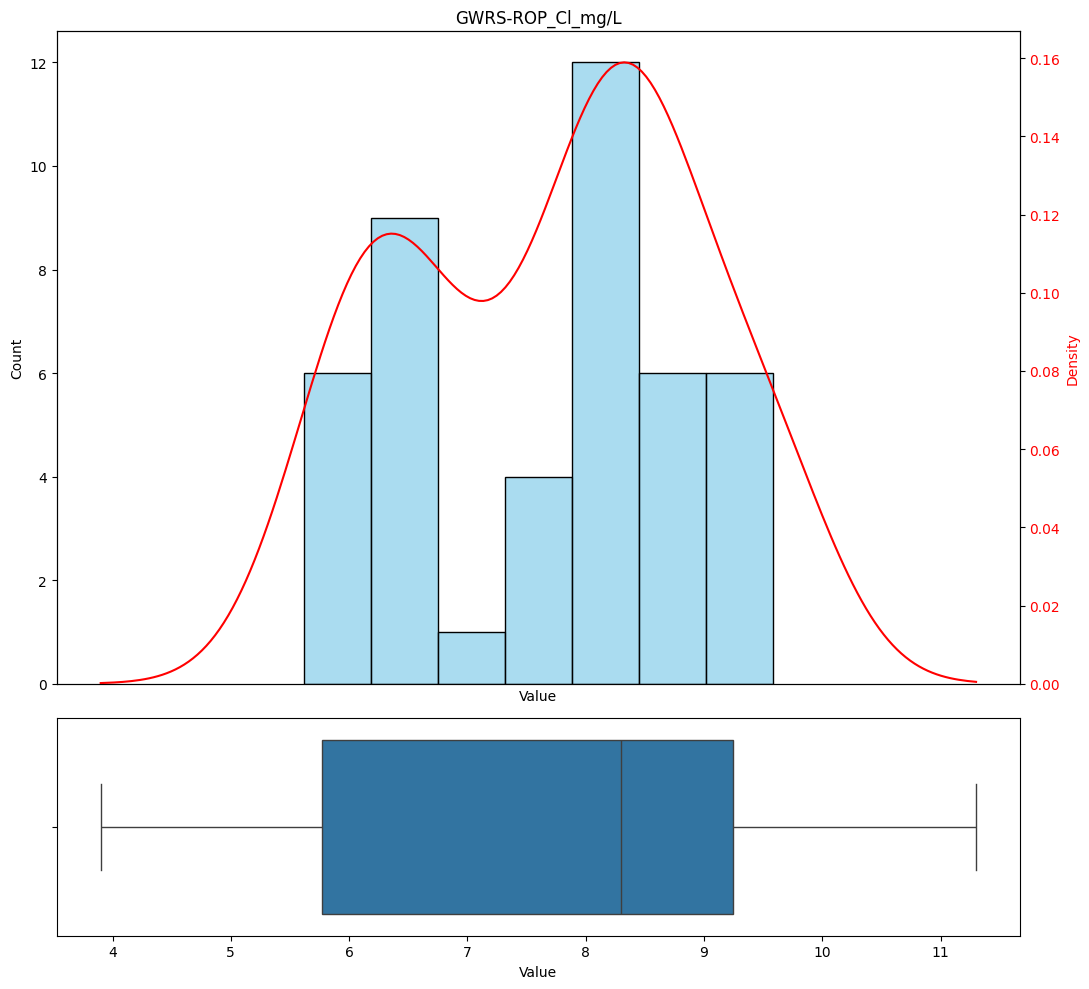

GWRS-ROC_Mg_mg/L


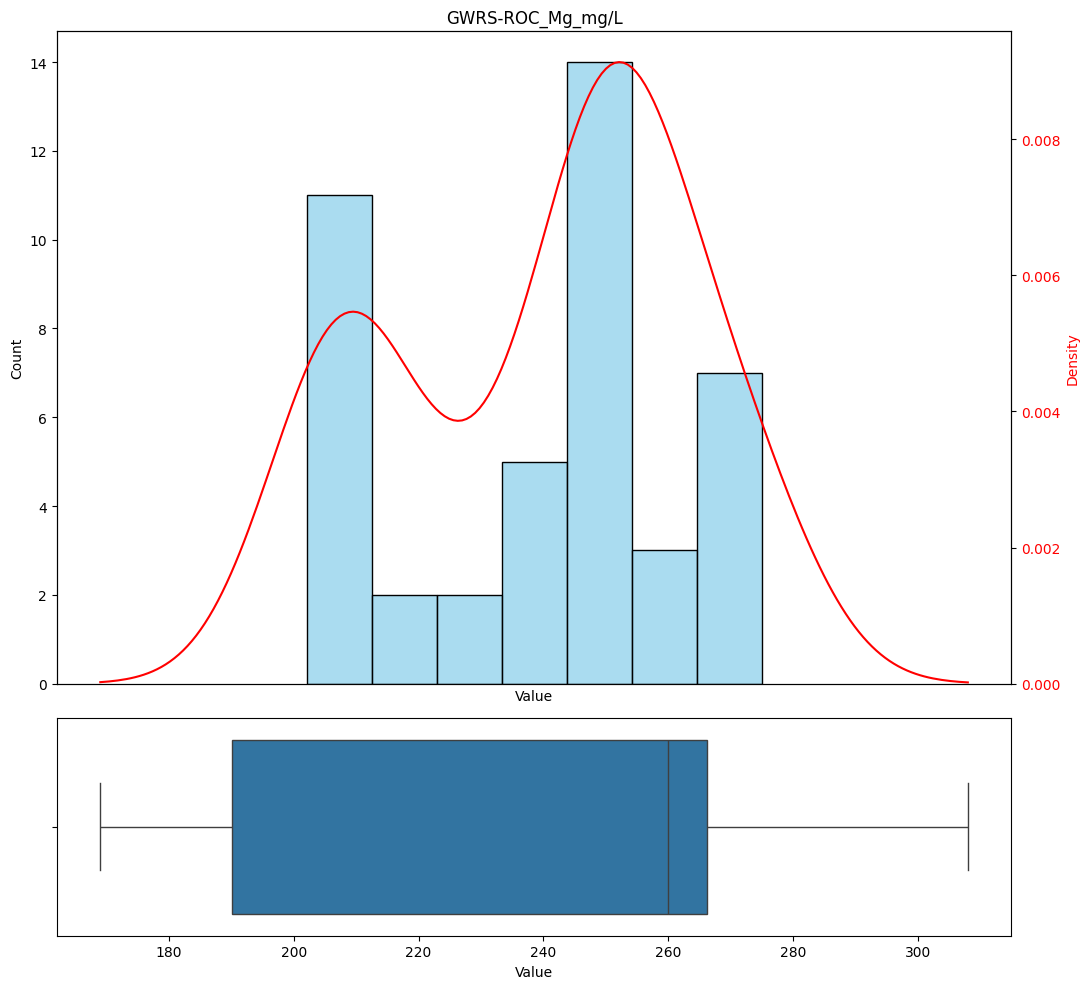

GWRS-ROF_K_mg/L


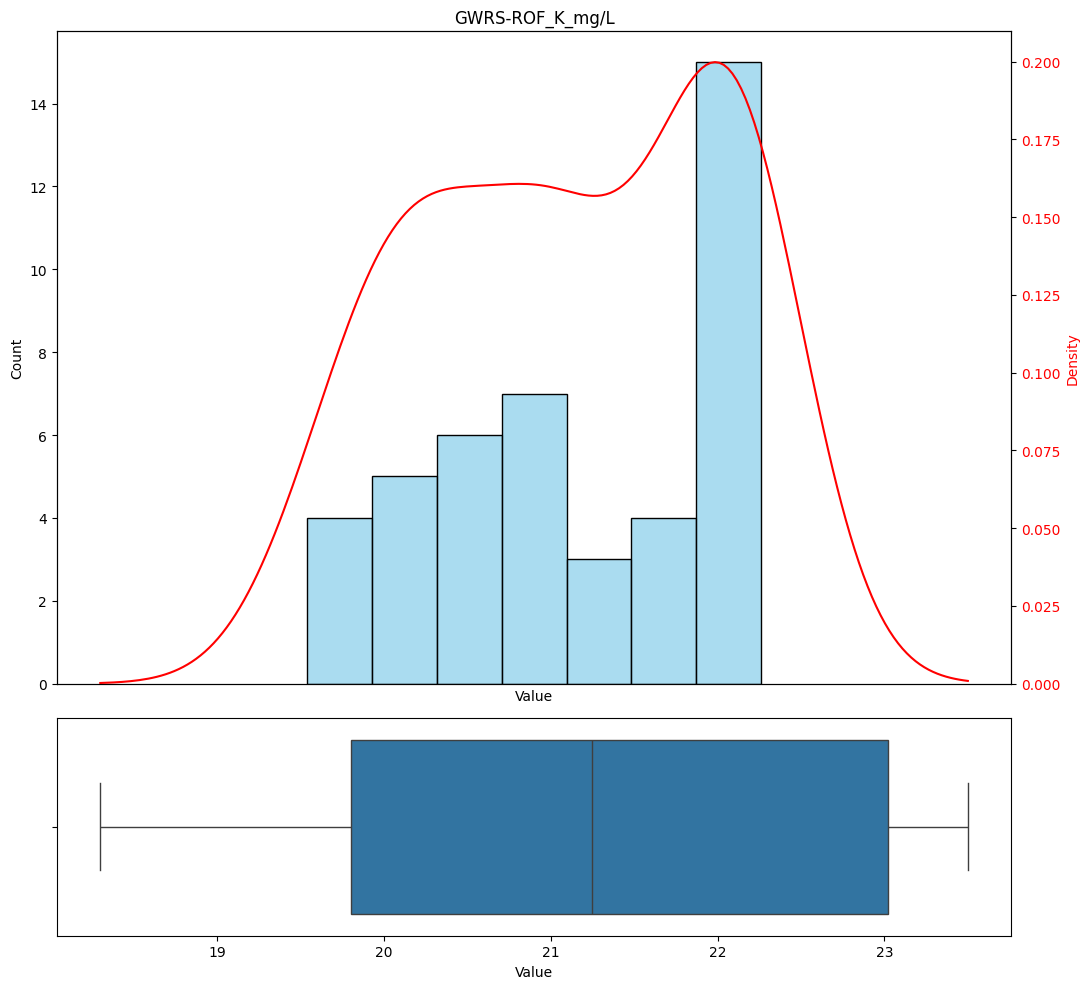

Stage 1-2 Feed Flow


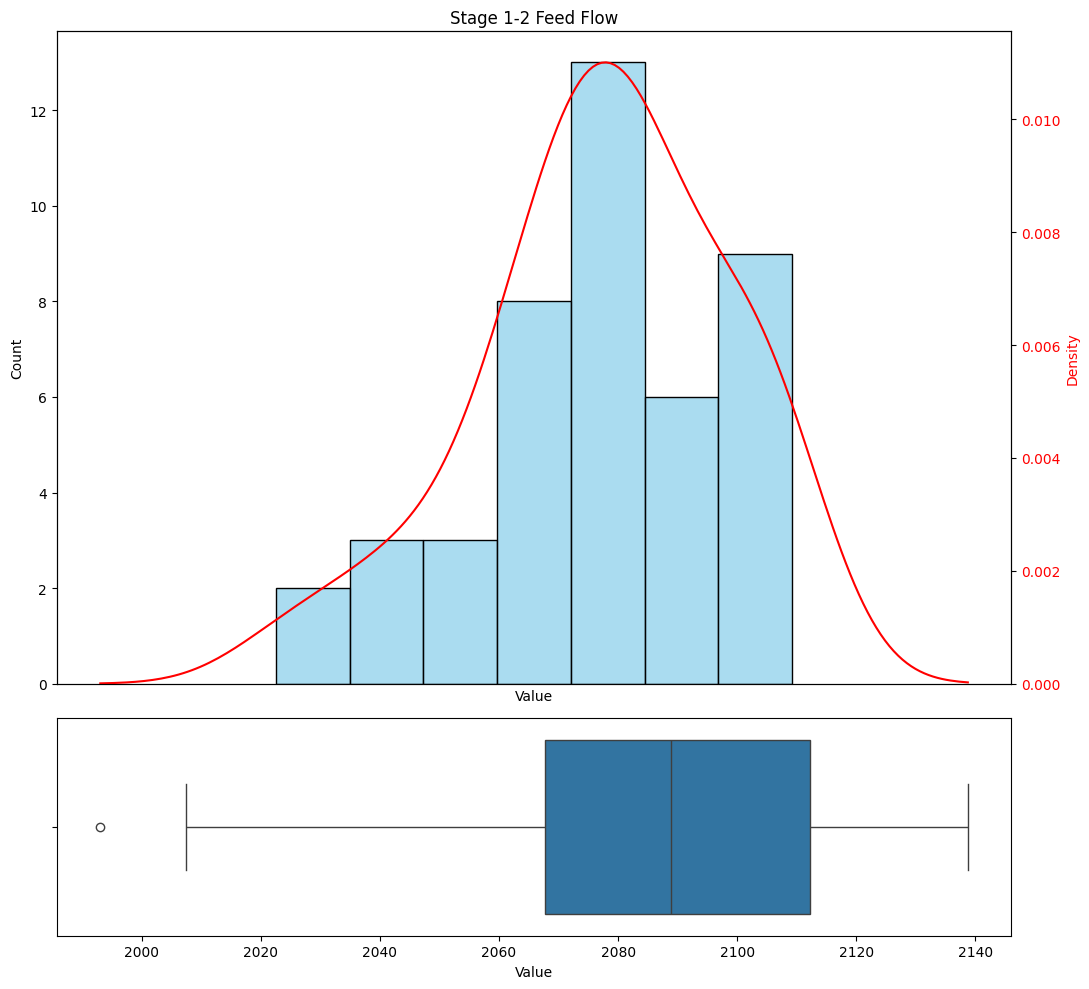

GWRS-ROF_Na_mg/L


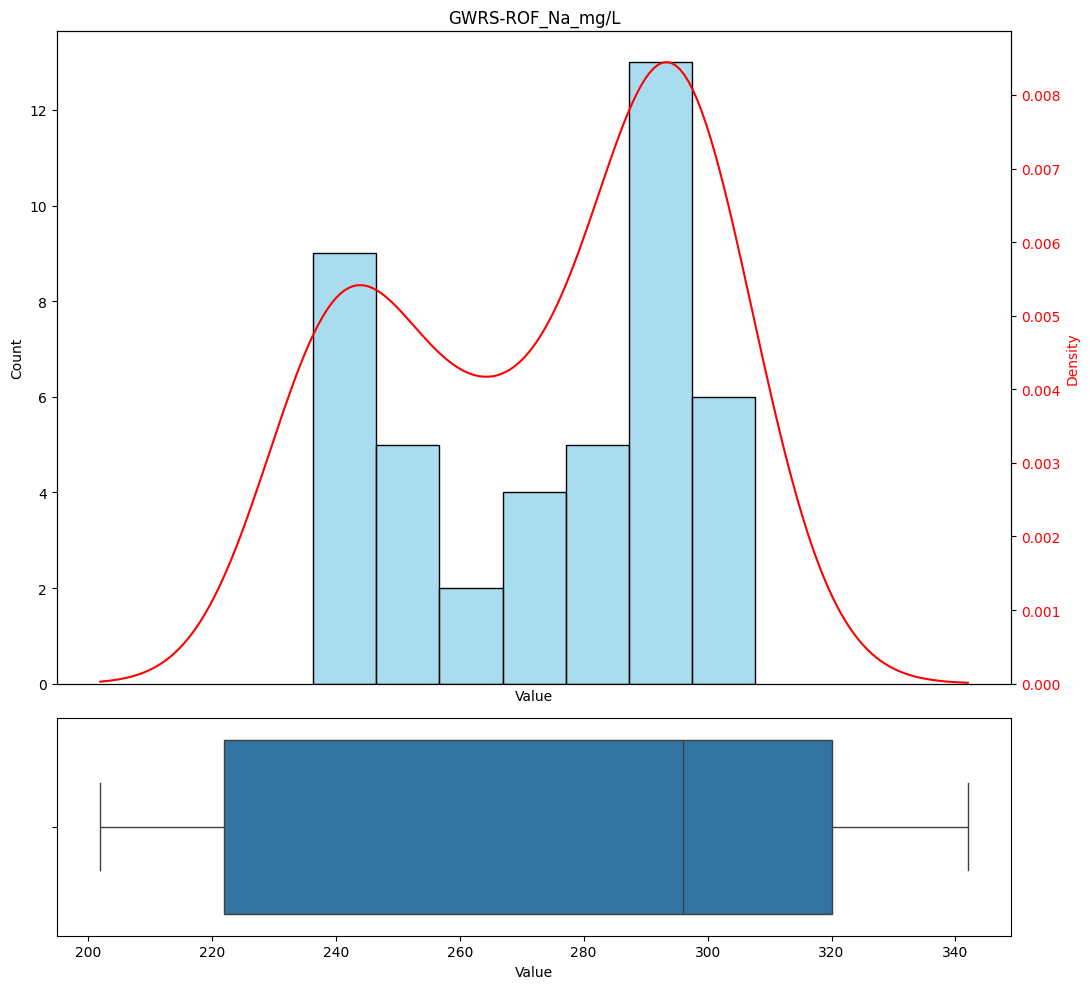

2nd Pass dp


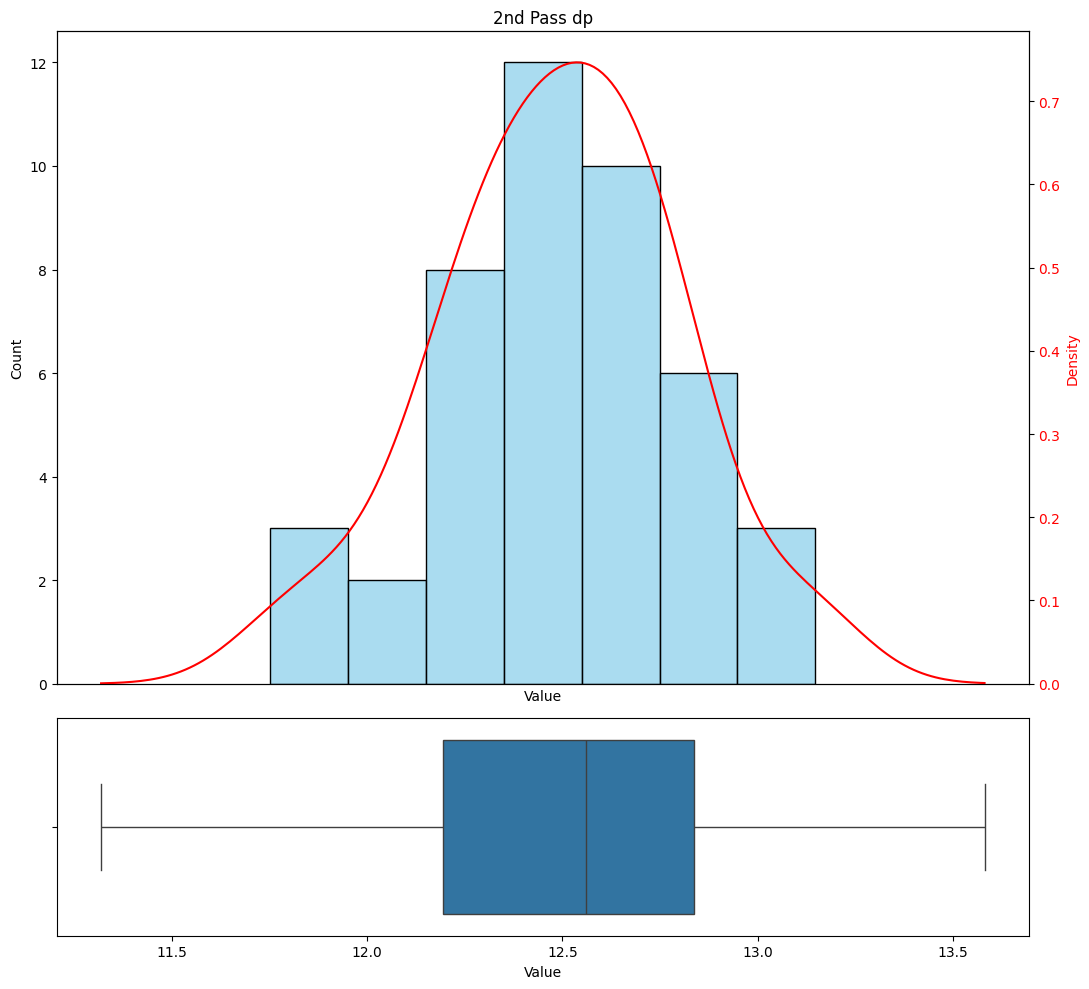

Stage 1 SF First Difference


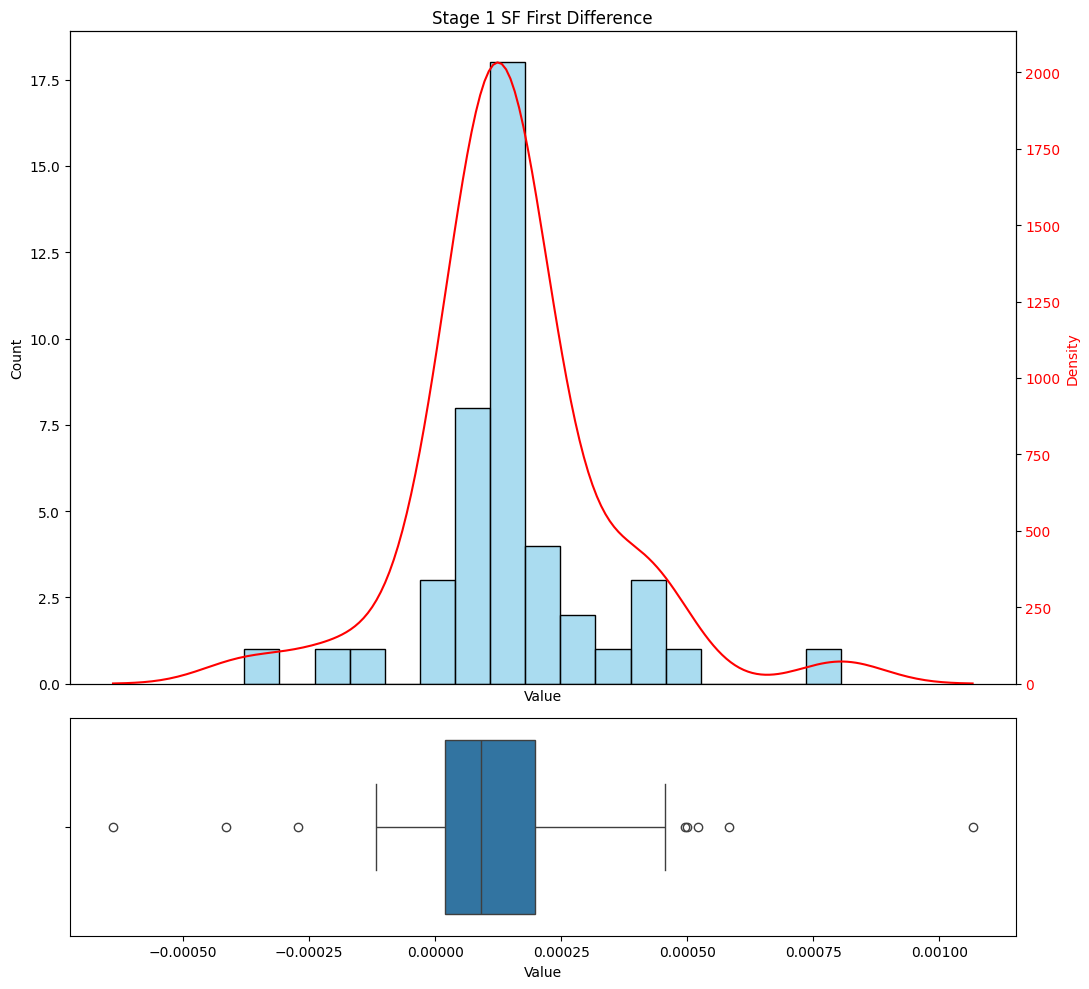

Stage 2-3 Feed Flow


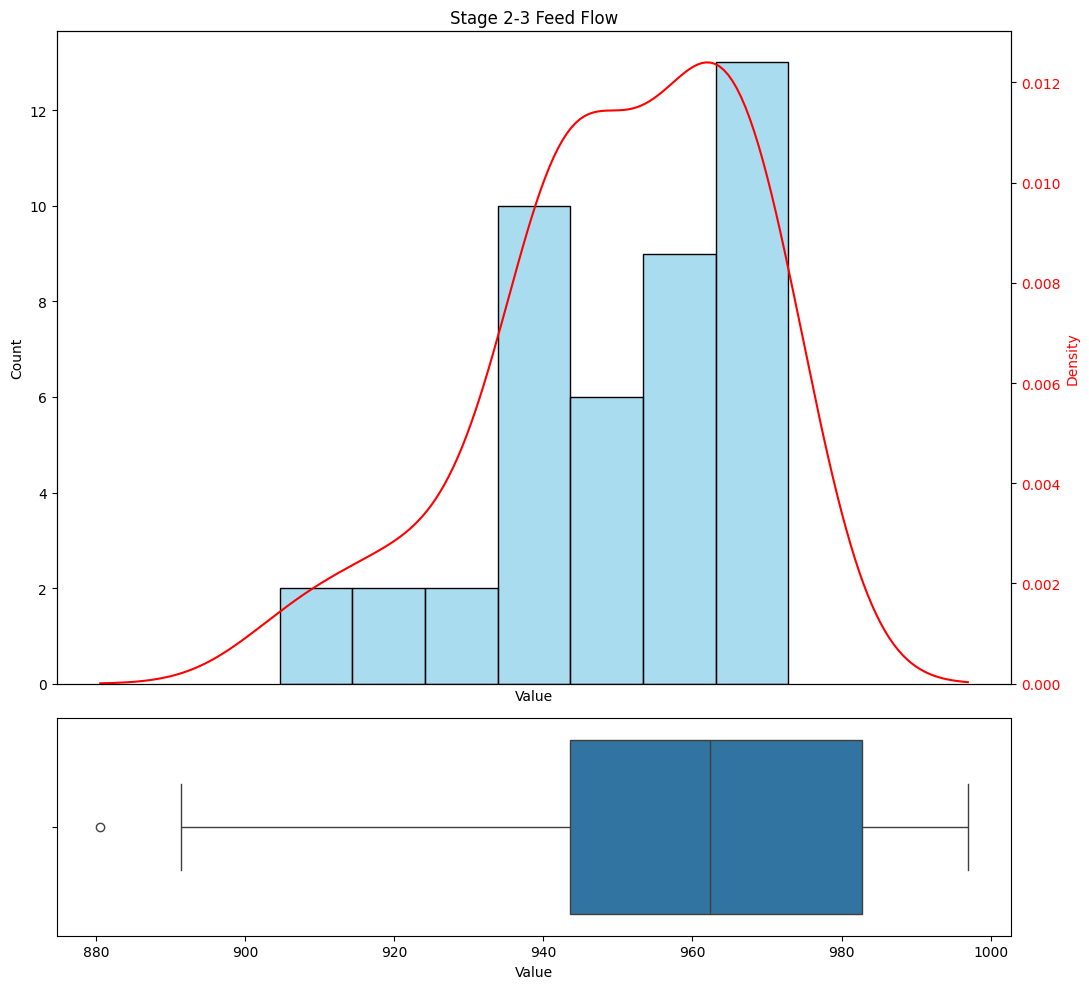

GWRS-ROC_Cu_ug/L


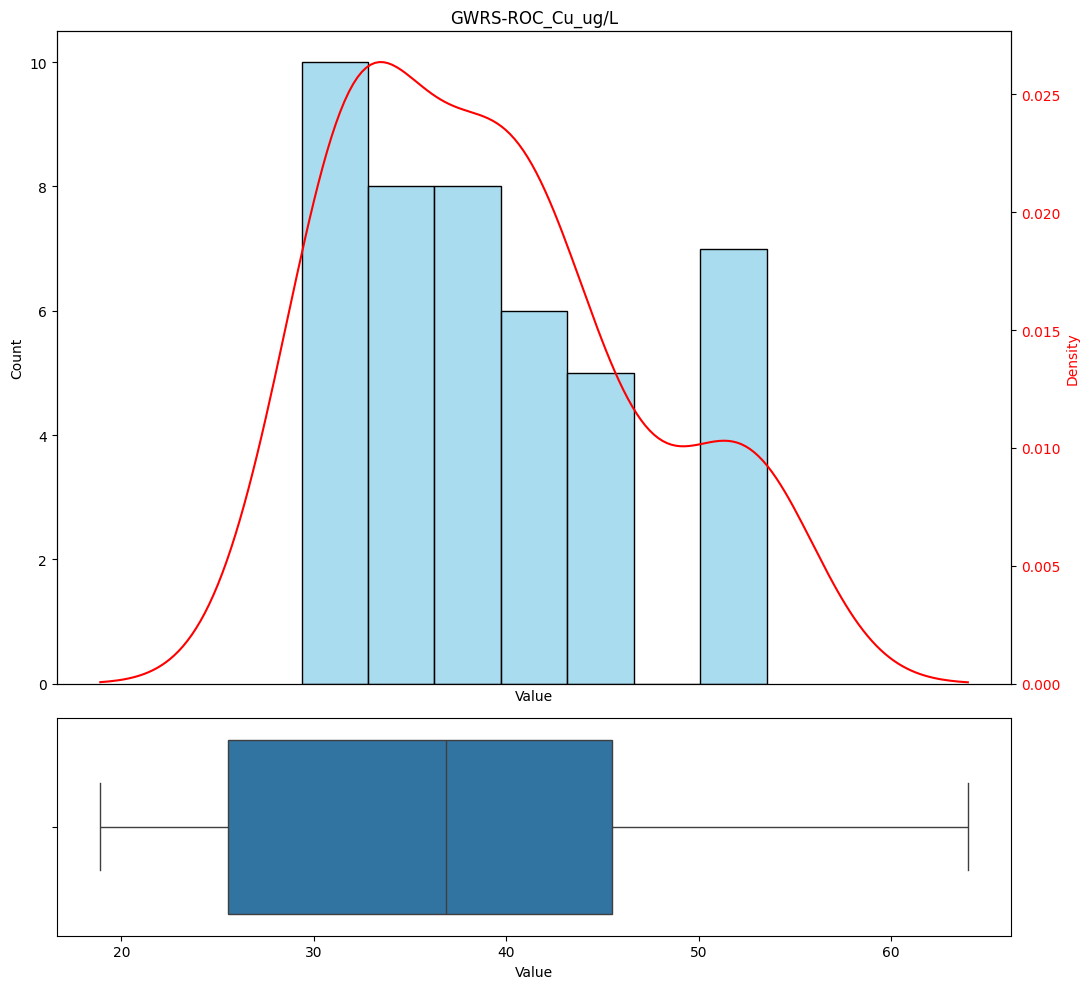

GWRS-ROP_SO4_mg/L


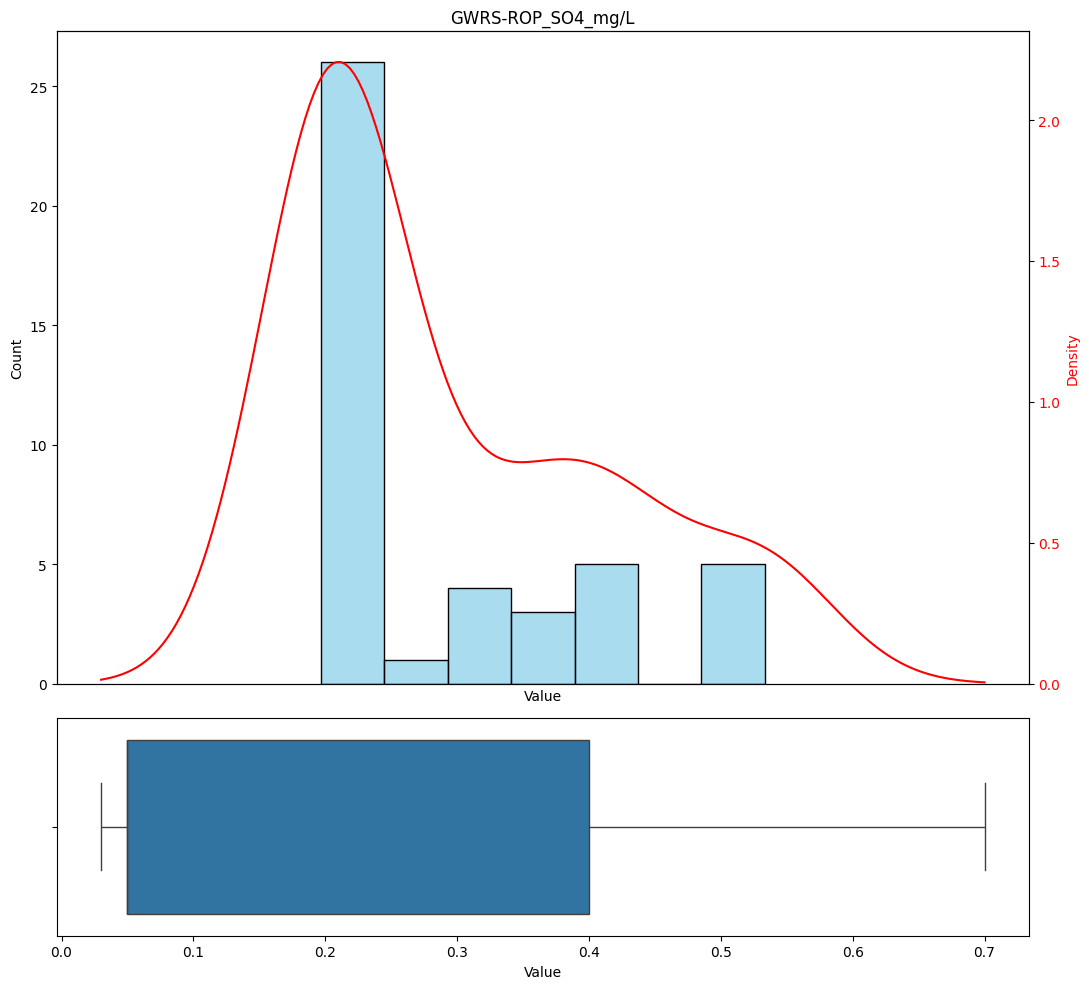

In [49]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

for k in features_s.columns:
    print(k)
    Temp = features_s[k]
    
    try:
        # Create a figure with two subplots: one for histogram + KDE, one for the box plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 10), gridspec_kw={'height_ratios': [3, 1]})
        
        # Plot histogram on primary y-axis
        sns.histplot(data=Temp, ax=ax1, kde=False, stat="count", color="skyblue", alpha=0.7)
        ax1.set_ylabel('Count')#, color='skyblue'
        ax1.tick_params(axis='y')#, labelcolor='skyblue'
        
        # Create secondary y-axis and plot KDE
        ax3 = ax1.twinx()
        sns.kdeplot(data=Temp, ax=ax3, color="red")
        ax3.set_ylabel('Density', color='red')
        ax3.tick_params(axis='y', labelcolor='red')
        
        ax1.set_title(label=k)
        ax1.set_xlabel("Value")
        ax1.set_xticks([])  # Hide x-ticks on the first plot to avoid overlap
        
        # Plot horizontal box plot
        sns.boxplot(data=Temp, ax=ax2, orient='h')
        ax2.set_xlabel("Value")
        
        # Adjust layout to prevent clipping of labels
        plt.tight_layout()
        
        plt.show()
        
    except TypeError as e:
        print("error:", e)

<Axes: xlabel='Week_Start'>

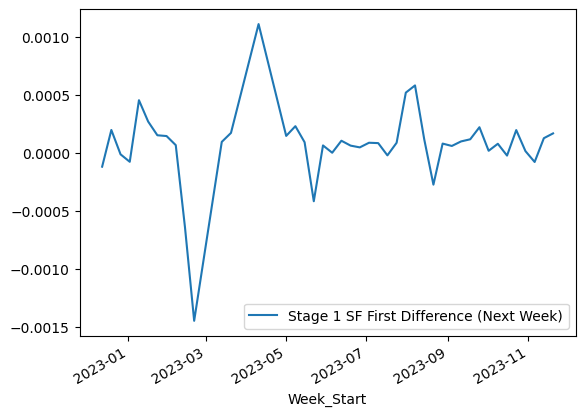

In [215]:
labels.plot()

## MLR

R-squared: 0.6406667639026333
Model coefficients: [[-3.38430541 -9.14512209 -1.17978917 -1.30784005  4.8849753  15.8753824
   0.90877304 -8.33768497  2.09594073  0.18938561 -2.74572375  0.21091796
  -2.28986851]]


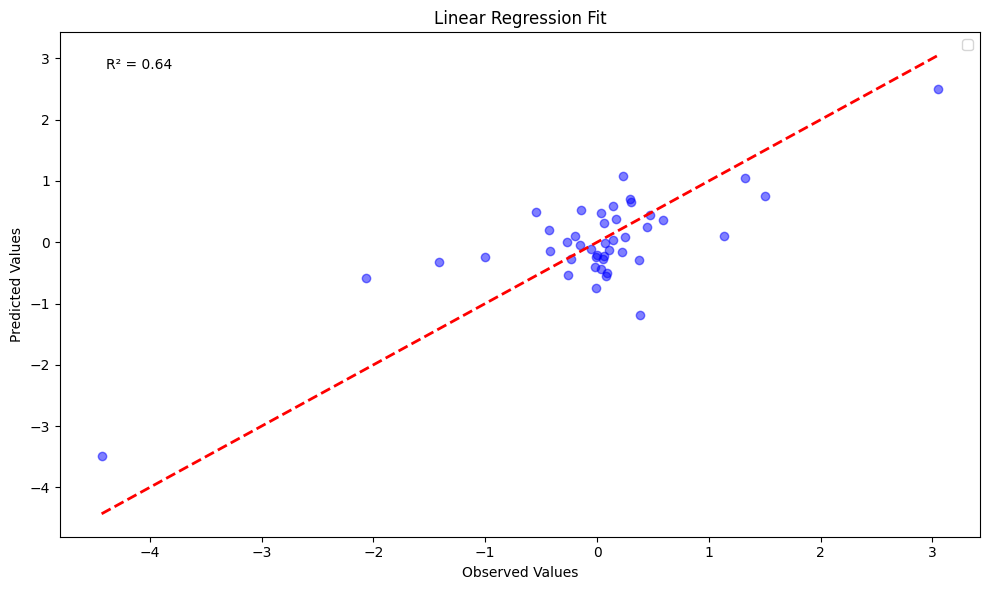

In [50]:
# Fit onto entire set
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def develop_linear_regression(X, y):
    """
    Develop a linear regression model given numpy arrays of features and target,
    and plot the fitted line along with the data points.

    Parameters:
    X (np.array): 2D numpy array of features (for simple linear regression, use a single feature)
    y (np.array): 1D numpy array of target values

    Returns:
    dict: A dictionary containing the model, predictions, performance metrics, and the plot
    """
    # Ensure X is 2D
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Create and train the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate performance metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if X.shape[1] == 1:  # If it's a simple linear regression
        ax.scatter(X, y, color='blue', alpha=0.5, label='Data points')
        ax.plot(X, y_pred, color='red', label='Fitted line')
        ax.set_xlabel('X')
        ax.set_ylabel('y')
    else:  # If it's a multiple linear regression, we'll plot observed vs predicted
        ax.scatter(y, y_pred, color='blue', alpha=0.5)
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        ax.set_xlabel('Observed Values')
        ax.set_ylabel('Predicted Values')
    
    ax.set_title('Linear Regression Fit')
    ax.text(0.05, 0.95, f'R² = {r2:.2f}', transform=ax.transAxes, verticalalignment='top')
    ax.legend()
    plt.tight_layout()

    # Create a dictionary with results
    results = {
        'model': model,
        'y_pred': y_pred,
        'mse': mse,
        'r2': r2,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'plot': fig
    }

    return results

# Example usage:
# X = your_feature_array  # 2D numpy array for multiple features, or 1D for single feature
# y = your_target_array   # 1D numpy array
# results = develop_linear_regression(X, y)
X = features_scaled  # 2D numpy array
y = labels_scaled   # 1D numpy array
results = develop_linear_regression(X, y)
# Access results:
print("R-squared:", results['r2'])
print("Model coefficients:", results['coefficients'])
plt.show()  # Display the plot

Test MSE: 0.36937200890052746
Model coefficients: [[-3.40122081 -9.43787545 -1.26789662 -1.33527151  5.31871378 16.24590951
   1.3250914  -8.84294715  2.08620609  0.16061669 -3.16935047  0.23191223
  -2.34099876]]


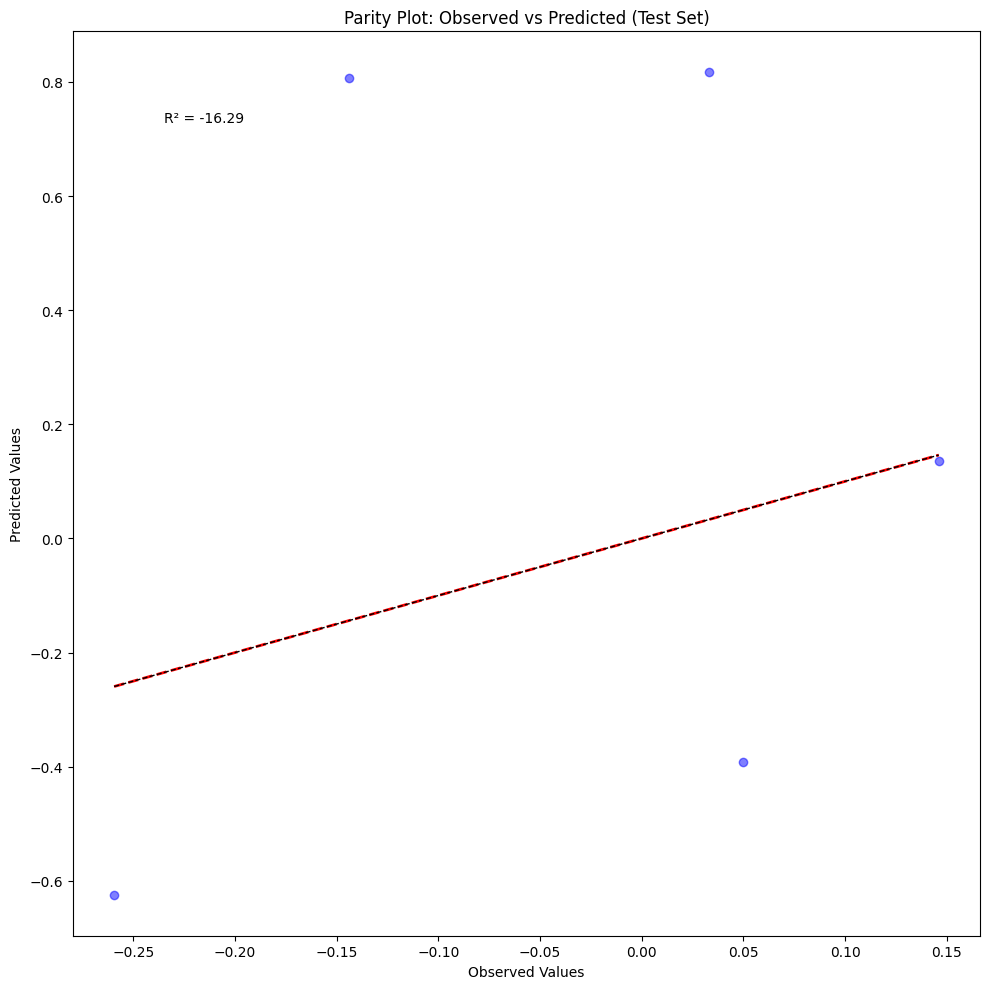

In [51]:
# Fit onto train and then predict on test

# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score

def develop_linear_regression(X, y, test_size=0.1, random_state=42):
    """
    Develop a linear regression model given numpy arrays of features and target.

    Parameters:
    X (np.array): 2D numpy array of features
    y (np.array): 1D numpy array of target values
    test_size (float): Proportion of the dataset to include in the test split
    random_state (int): Random state for reproducibility

    Returns:
    dict: A dictionary containing the model, predictions, and performance metrics
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    # Create parity plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(y_test, y_test_pred, c='blue', alpha=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel('Observed Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title('Parity Plot: Observed vs Predicted (Test Set)')
    ax.text(0.1, 0.9, f'R² = {test_r2:.2f}', transform=ax.transAxes)
    
    # Add perfect fit line
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    
    plt.tight_layout()

    # Create a dictionary with results
    results = {
        'model': model,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'coefficients': model.coef_,
        'intercept': model.intercept_
    }

    return results

# Example usage:
X = features_scaled  # 2D numpy array
y = labels_scaled   # 1D numpy array
results = develop_linear_regression(X, y)

# Access results:
print("Test MSE:", results['test_mse'])
print("Model coefficients:", results['coefficients'])

## Reduced MLR

### Bakwards elimination

R-squared: 0.43829574923143744
Mean Squared Error: 0.5617042507685627
Model coefficients: [-0.45376844  0.73267846  0.36451064  0.56701922 -0.9184582 ]
Selected features: ['GWRS-ROP_Cl_mg/L', 'Stage 1-2 Feed Flow', 'GWRS-ROF_Na_mg/L', 'Stage 1 SF First Difference', 'Stage 2-3 Feed Flow']


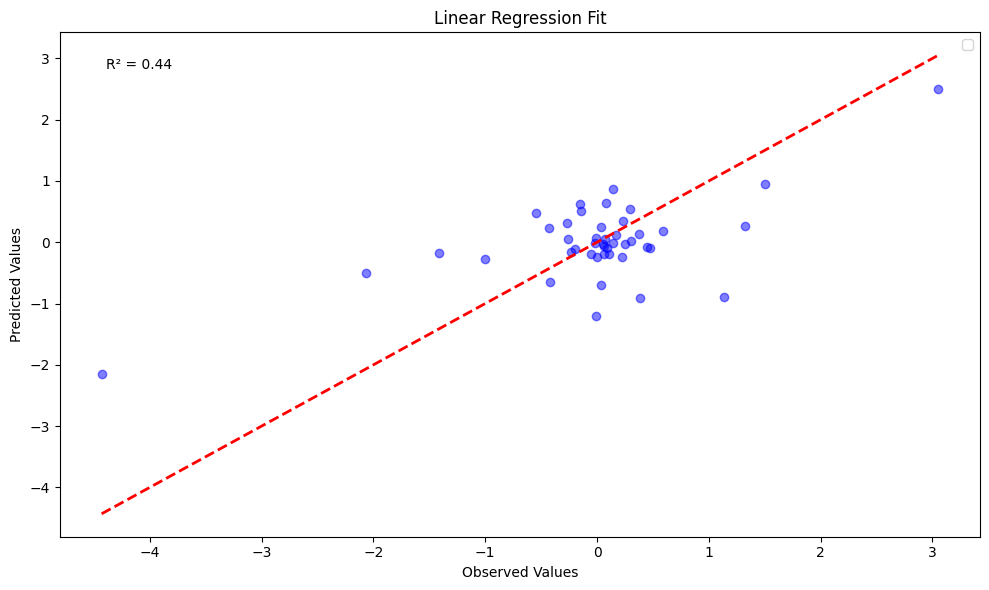

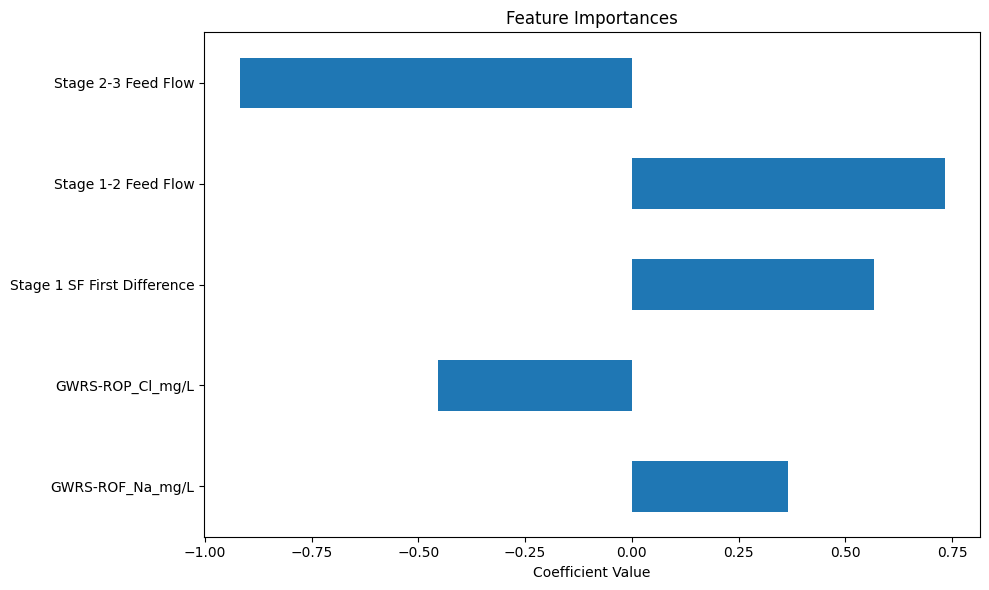

In [52]:
# Function to perform backward elimination
def backward_elimination(X, y, num_features):
    cols = list(X.columns)
    while len(cols) > num_features:
        X_with_const = sm.add_constant(X[cols])
        model = sm.OLS(y, X_with_const).fit()
        p_values = model.pvalues.iloc[1:]  # Exclude the intercept
        max_p_value = p_values.max()
        if max_p_value > 0.05:
            excluded_feature = p_values.idxmax()
            cols.remove(excluded_feature)
        else:
            break
    return X[cols]



# Create scalers
label_scaler = StandardScaler()
feature_scaler = StandardScaler()

# Fit and transform
labels_scaled = label_scaler.fit_transform(labels)
features_scaled = feature_scaler.fit_transform(features_s)

# Create DataFrames with scaled values and original column names
features_scaled_df = pd.DataFrame(features_scaled, columns=features_s.columns, index=features_s.index)
labels_scaled_df = pd.DataFrame(labels_scaled, columns=[label_column], index=labels.index)

# Perform backward elimination to reduce features from 15 to 5
features_reduced_df = backward_elimination(features_scaled_df, labels_scaled_df.values.ravel(), 5)

# Fit onto entire set
def develop_linear_regression(X, y):
    """
    Develop a linear regression model given numpy arrays of features and target,
    and plot the fitted line along with the data points.

    Parameters:
    X (np.array): 2D numpy array of features (for simple linear regression, use a single feature)
    y (np.array): 1D numpy array of target values

    Returns:
    dict: A dictionary containing the model, predictions, performance metrics, and the plot
    """
    # Ensure X is 2D
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Create and train the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate performance metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if X.shape[1] == 1:  # If it's a simple linear regression
        ax.scatter(X, y, color='blue', alpha=0.5, label='Data points')
        ax.plot(X, y_pred, color='red', label='Fitted line')
        ax.set_xlabel('X')
        ax.set_ylabel('y')
    else:  # If it's a multiple linear regression, we'll plot observed vs predicted
        ax.scatter(y, y_pred, color='blue', alpha=0.5)
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        ax.set_xlabel('Observed Values')
        ax.set_ylabel('Predicted Values')
    
    ax.set_title('Linear Regression Fit')
    ax.text(0.05, 0.95, f'R² = {r2:.2f}', transform=ax.transAxes, verticalalignment='top')
    ax.legend()
    plt.tight_layout()

    # Create a dictionary with results
    results = {
        'model': model,
        'y_pred': y_pred,
        'mse': mse,
        'r2': r2,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'plot': fig
    }

    return results

# Example usage:
X = features_reduced_df.values  # 2D numpy array
y = labels_scaled_df.values.ravel()  # 1D numpy array
results = develop_linear_regression(X, y)

# Access results:
print("R-squared:", results['r2'])
print("Mean Squared Error:", results['mse'])
print("Model coefficients:", results['coefficients'])
print("Selected features:", features_reduced_df.columns.tolist())
plt.show()  # Display the plot

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(results['coefficients'], index=features_reduced_df.columns)
feature_importance.sort_values(key=abs).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

### LASSO

R-squared: 0.3927280808348579
Mean Squared Error: 0.6072719191651422
Model coefficients: [ 0.61869552  0.17145076 -0.11137039 -0.03411729 -0.11635572]
Selected features: Index(['Stage 1 SF First Difference', 'GWRS-ROP_SO4_mg/L', 'GWRS-ROF_Ca_mg/L',
       'GWRS-ROC_Cu_ug/L', 'Stage 2-3 Feed Flow'],
      dtype='object')


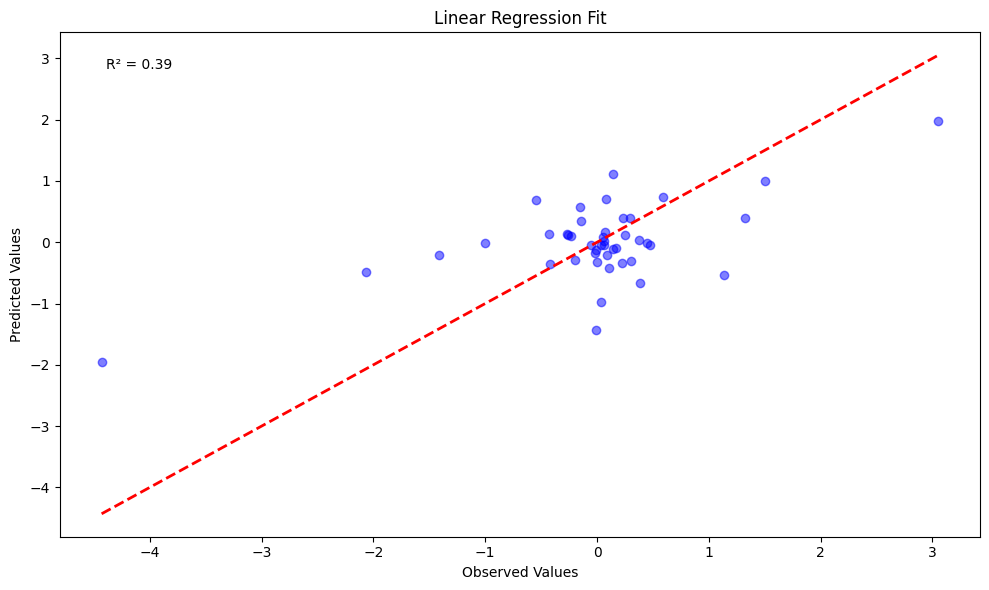

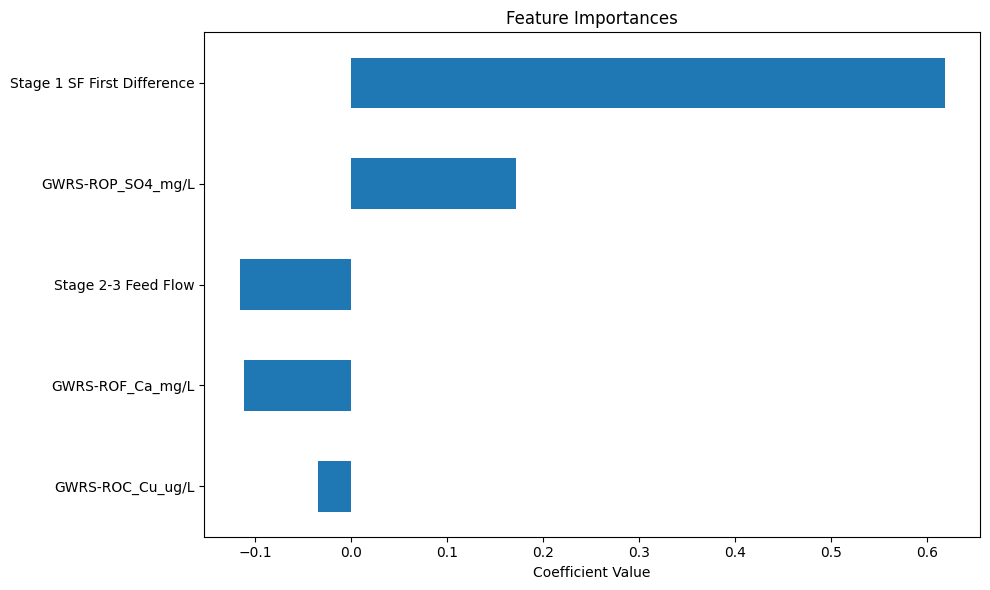

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Function to perform feature selection using Lasso
def select_top_features_lasso(X, y, num_features, alpha=0.1):
    # Create and fit Lasso model
    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X, y)
    
    # Get non-zero coefficients
    non_zero_coef_indices = np.where(lasso.coef_ != 0)[0]
    
    # Sort features by absolute coefficient value
    sorted_indices = np.argsort(np.abs(lasso.coef_))[::-1]
    
    # Select top features
    top_indices = sorted_indices[:num_features]
    top_features = X.columns[top_indices]
    
    return X[top_features], top_features

# Example usage of feature selection
# selected_Xs = top_spearman_correlated_features(features, labels.values[:,0], 15)
# features_s = features[list(selected_Xs.index.values)]

# Create scalers
label_scaler = StandardScaler()
feature_scaler = StandardScaler()

# Fit and transform
labels_scaled = label_scaler.fit_transform(labels)
features_scaled = feature_scaler.fit_transform(features_s)

# Create DataFrames with scaled values and original column names
features_scaled_df = pd.DataFrame(features_scaled, columns=features_s.columns, index=features_s.index)
labels_scaled_df = pd.DataFrame(labels_scaled, columns=[label_column], index=labels.index)

# Perform feature selection to reduce features from 15 to 5
features_reduced_df, selected_features = select_top_features_lasso(features_scaled_df, labels_scaled_df.values.ravel(), 5, alpha=0.1)

def develop_linear_regression(X, y):
    # Create and train the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate performance metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.scatter(y, y_pred, color='blue', alpha=0.5)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    ax.set_xlabel('Observed Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title('Linear Regression Fit')
    ax.text(0.05, 0.95, f'R² = {r2:.2f}', transform=ax.transAxes, verticalalignment='top')
    plt.tight_layout()

    # Create a dictionary with results
    results = {
        'model': model,
        'y_pred': y_pred,
        'mse': mse,
        'r2': r2,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'plot': fig
    }

    return results

# Example usage:
X = features_reduced_df.values  # 2D numpy array
y = labels_scaled_df.values.ravel()  # 1D numpy array
results = develop_linear_regression(X, y)

# Access results:
print("R-squared:", results['r2'])
print("Mean Squared Error:", results['mse'])
print("Model coefficients:", results['coefficients'])
print("Selected features:", selected_features)
plt.show()  # Display the plot

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(results['coefficients'], index=selected_features)
feature_importance.sort_values(key=abs).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

## XGBoost

=============Model Performance Results using the XGBoost Model ============

Mean Absolute Error (MAE): 0.47634
Root Mean Square Error (RMSE): 0.51002
Mean Score Error (MSE): 0.26012
R2 Score (R2): -1.88561
Median Absolute Error: 0.46543
Mean Absolute Percentage Error (MAPE): 184.60544


[]

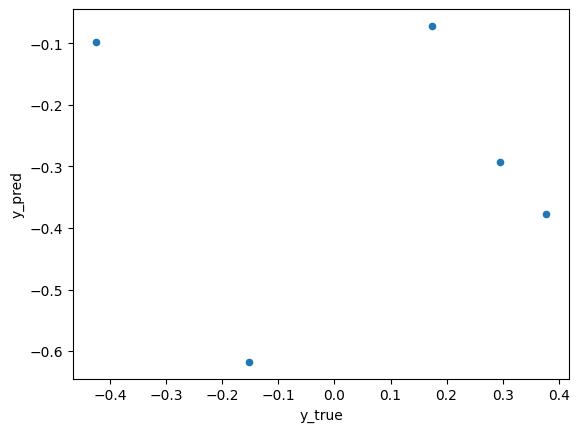

In [205]:
xg_reg = xgb.XGBRegressor() #base learner 
basemodel = xg_reg.fit(train_features, train_labels) 
# ================================================
# put both prediction and test data in one table df

y_pred = basemodel.predict(test_features)

results=pd.DataFrame()
results['y_pred'] = y_pred
results['y_true']=test_labels
results_df = results.copy()


#results_df.to_csv('results_df_log10.csv')

# ================================================
print('=============Model Performance Results using the XGBoost Model ============\n')
#print('*** Accuracy Metrics:')
accuracy_metrics(results_df['y_true'], results_df['y_pred'])
ax=results_df.plot.scatter(x='y_true', y='y_pred')
ax.plot( color='black', linestyle='--') #[4,8], [4,8],

# Apply feature selection and MLR to other units

## E01

In [79]:
df = E01_weekly.dropna(subset=[predictands_shift1[0],predictands[0]])

# Define features and label
label_column = predictands_shift1[0]
labels = df[[label_column]]
features = df.drop(columns=[label_column]+predictands[1:]+predictands_shift1[1:])
features = drop_high_nan_columns(features,0.5)
print(features.columns)

Dropped 0 columns: []
Index(['Feed psi', 'Conc Press Stage 1', 'Feed Press Stage 2',
       'Stage 2-3 Press', 'Conc psi', 'Perm Press Stage 1', 'Perm psi',
       'Perm Flow', 'Stage 2 Perm Flow', 'Stage 3  Perm Flow',
       ...
       'ROF_EC', 'ROF_ROF TOC', 'ROF_Cl2', 'ROF_pH',
       'Stage 1 Norm Percent Salt Passage',
       'Stage 2 Norm Percent Salt Passage',
       'Stage 3 Norm Percent Salt Passage', 'Cumulative Hours On',
       'Days_since_install', 'Stage 1 SF First Difference'],
      dtype='object', length=129)


## Plot potential features and target

In [68]:
# Example usage of backward elimination
selected_Xs = top_spearman_correlated_features(features, labels.values[:,0], 15)
features_s = features[list(selected_Xs.index.values)]
print(list(selected_Xs.index.values))
# drop arbitrary columns
features_s.drop(columns=['GWRS-ROC_Na_mg/L','GWRS-ROC_Mg_mg/L','GWRS-ROC_K_mg/L','GWRS-ROC_Ca_mg/L'], inplace=True)
print(features_s.columns)

['GWRS-ROF_Ca_mg/L', 'GWRS-ROC_K_mg/L', 'GWRS-ROF_Na_mg/L', 'GWRS-ROC_Mg_mg/L', 'GWRS-ROC_Na_mg/L', 'GWRS-ROF_SiO2_mg/L', 'GWRS-ROF_Mg_mg/L', 'GWRS-ROF_K_mg/L', 'GWRS-ROC_Cu_ug/L', 'GWRS-Q1_Total Nitrogen_mg/L', 'IBP Boost Pressure', 'GWRS-ROP_Cl_mg/L', 'GWRS-ROP_SO4_mg/L', 'GWRS-ROC_Ca_mg/L', 'GWRS-ROF_Cl_mg/L']
Index(['GWRS-ROF_Ca_mg/L', 'GWRS-ROF_Na_mg/L', 'GWRS-ROF_SiO2_mg/L',
       'GWRS-ROF_Mg_mg/L', 'GWRS-ROF_K_mg/L', 'GWRS-ROC_Cu_ug/L',
       'GWRS-Q1_Total Nitrogen_mg/L', 'IBP Boost Pressure', 'GWRS-ROP_Cl_mg/L',
       'GWRS-ROP_SO4_mg/L', 'GWRS-ROF_Cl_mg/L'],
      dtype='object')


GWRS-ROF_Ca_mg/L


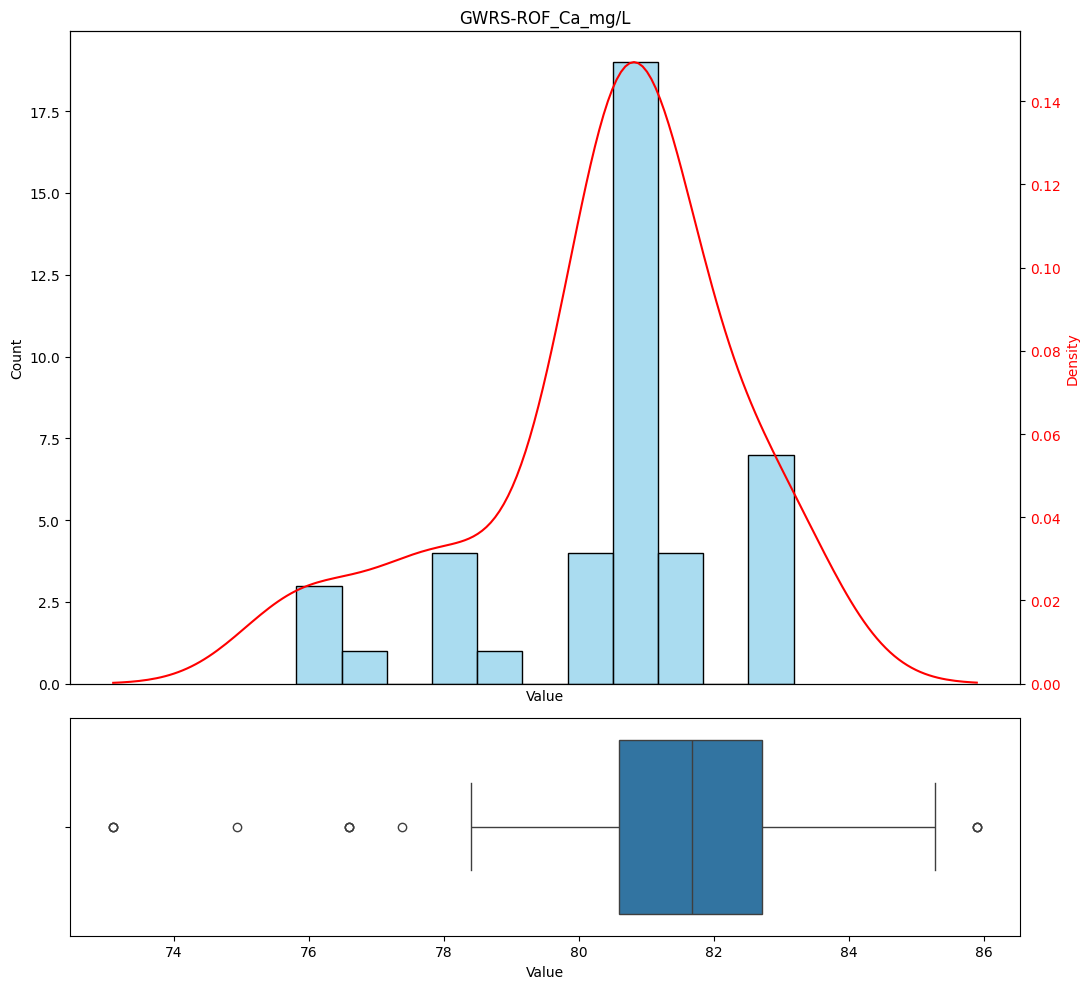

GWRS-ROF_Na_mg/L


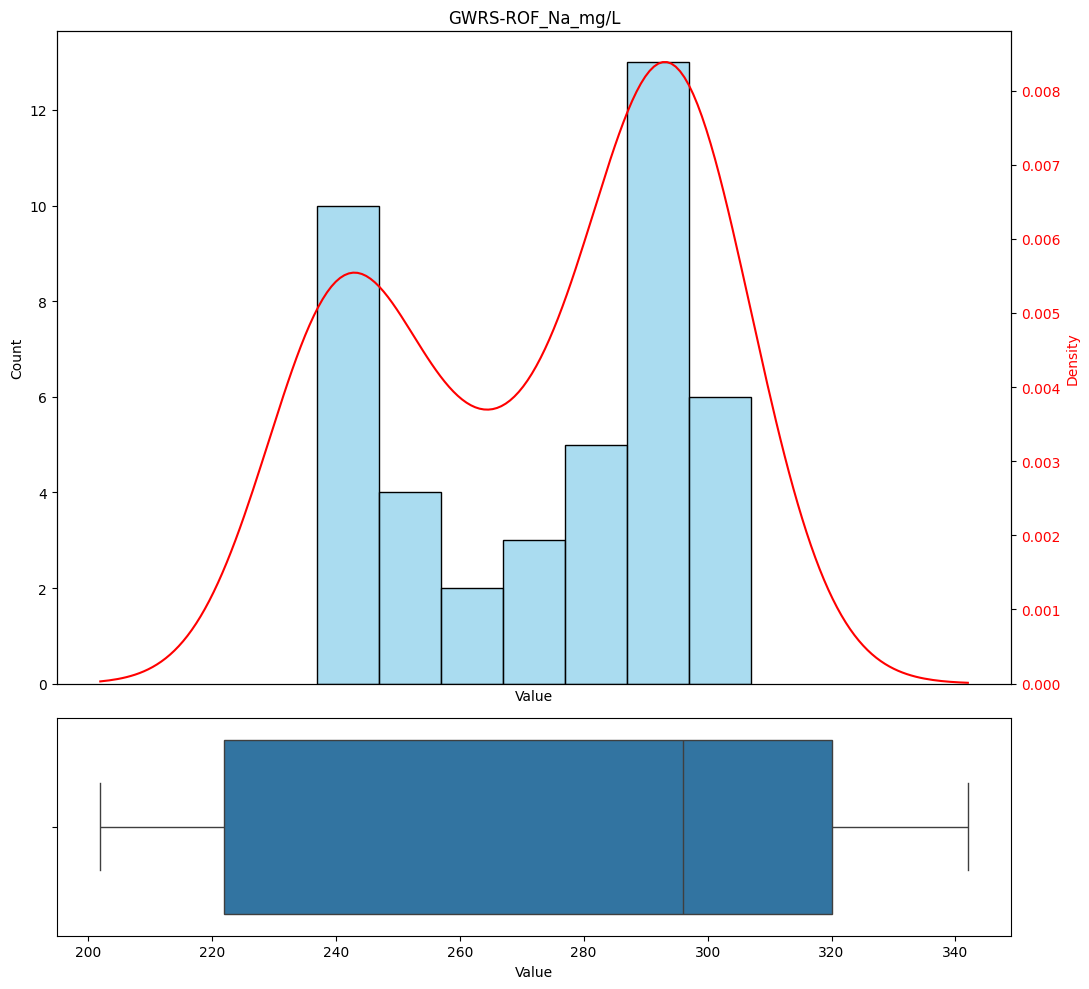

GWRS-ROF_SiO2_mg/L


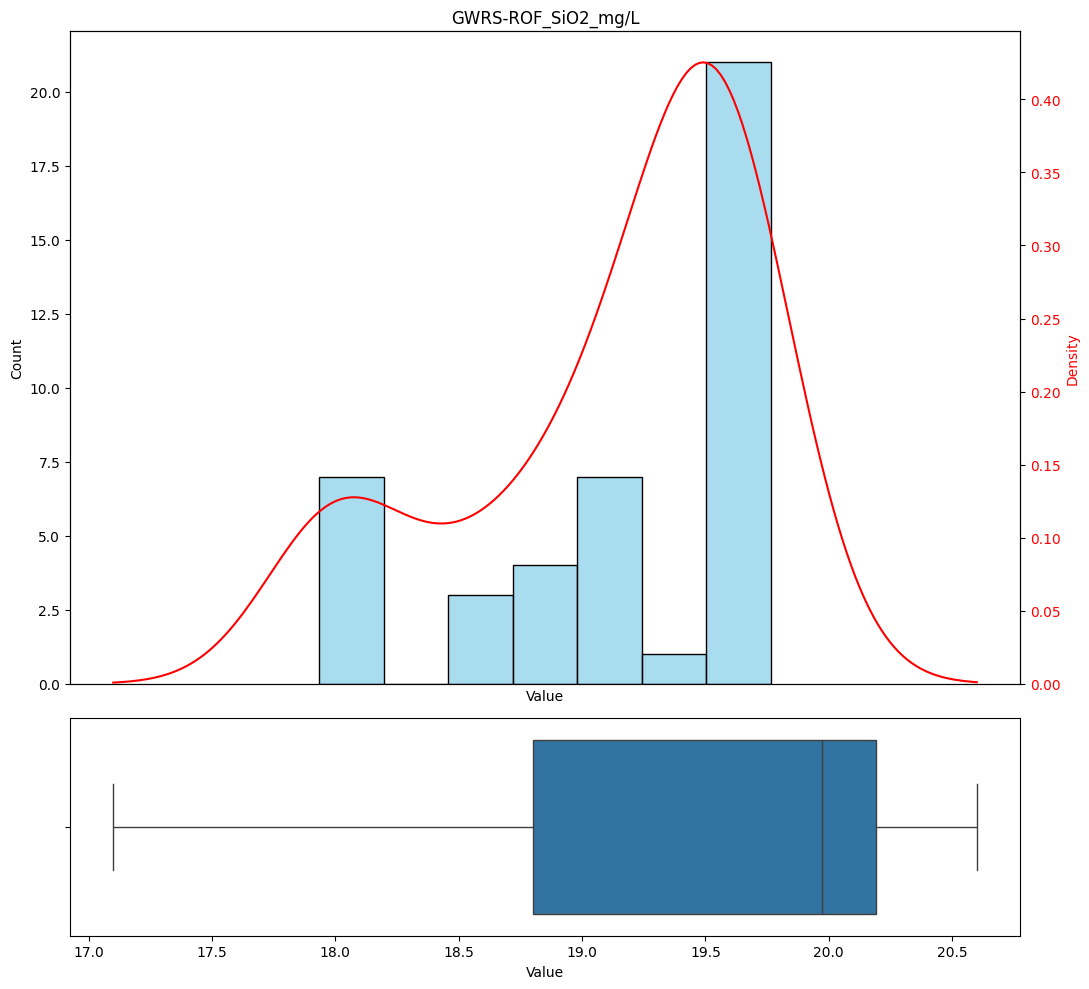

GWRS-ROF_Mg_mg/L


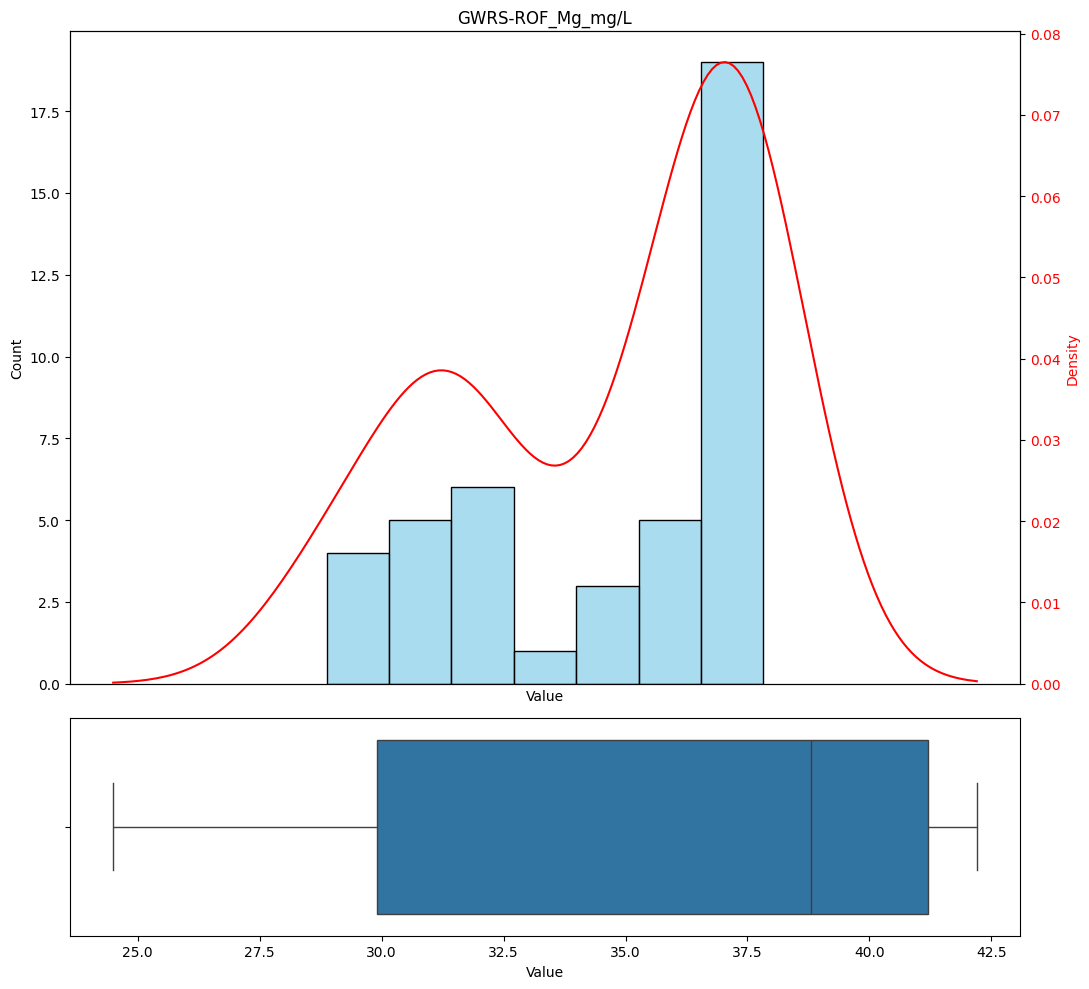

GWRS-ROF_K_mg/L


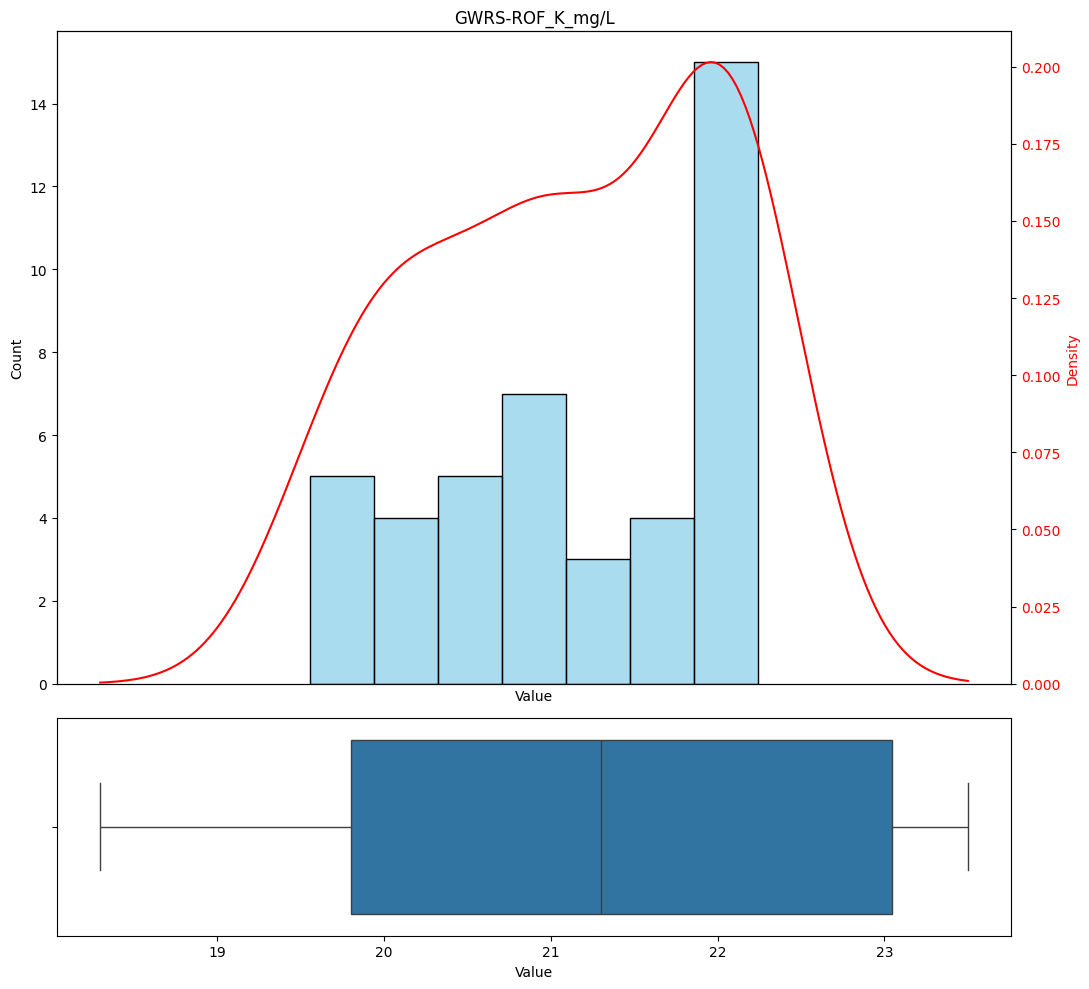

GWRS-ROC_Cu_ug/L


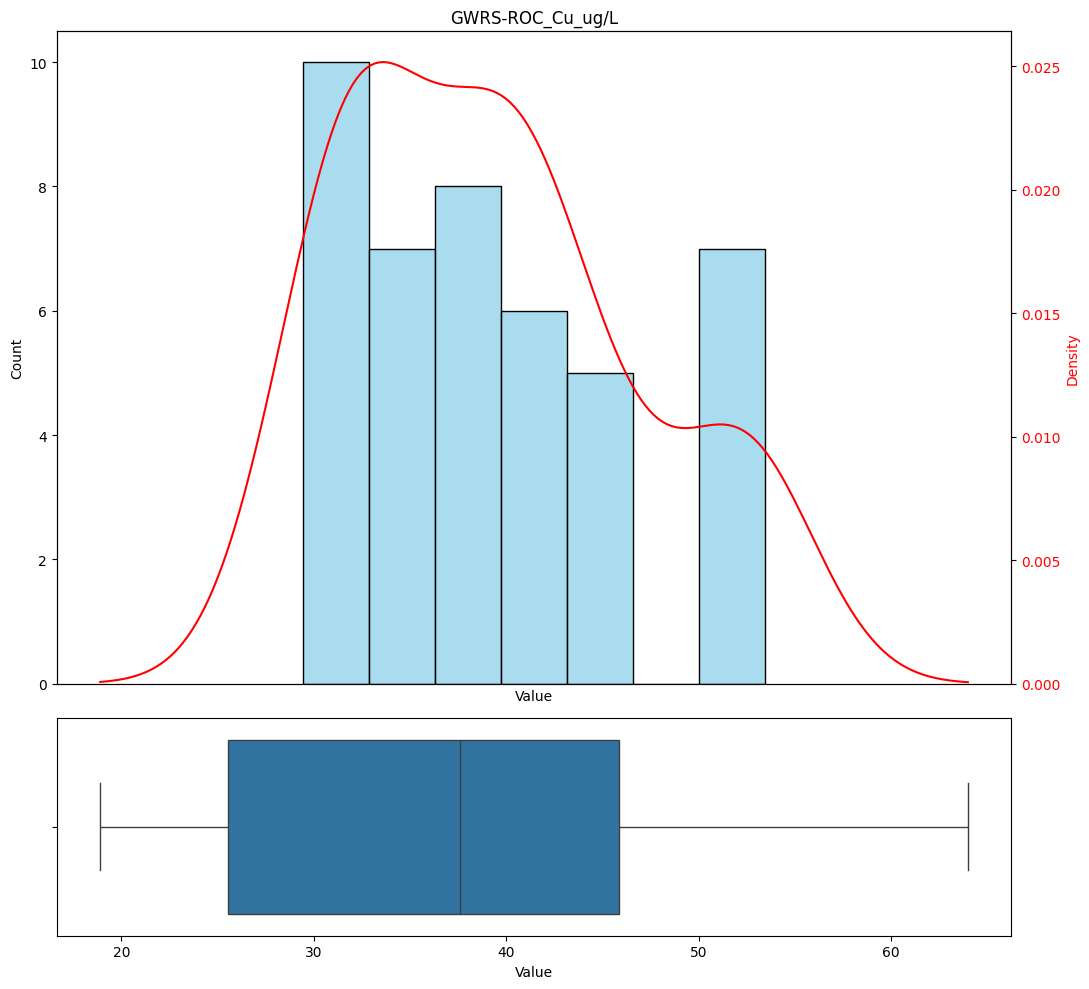

GWRS-Q1_Total Nitrogen_mg/L


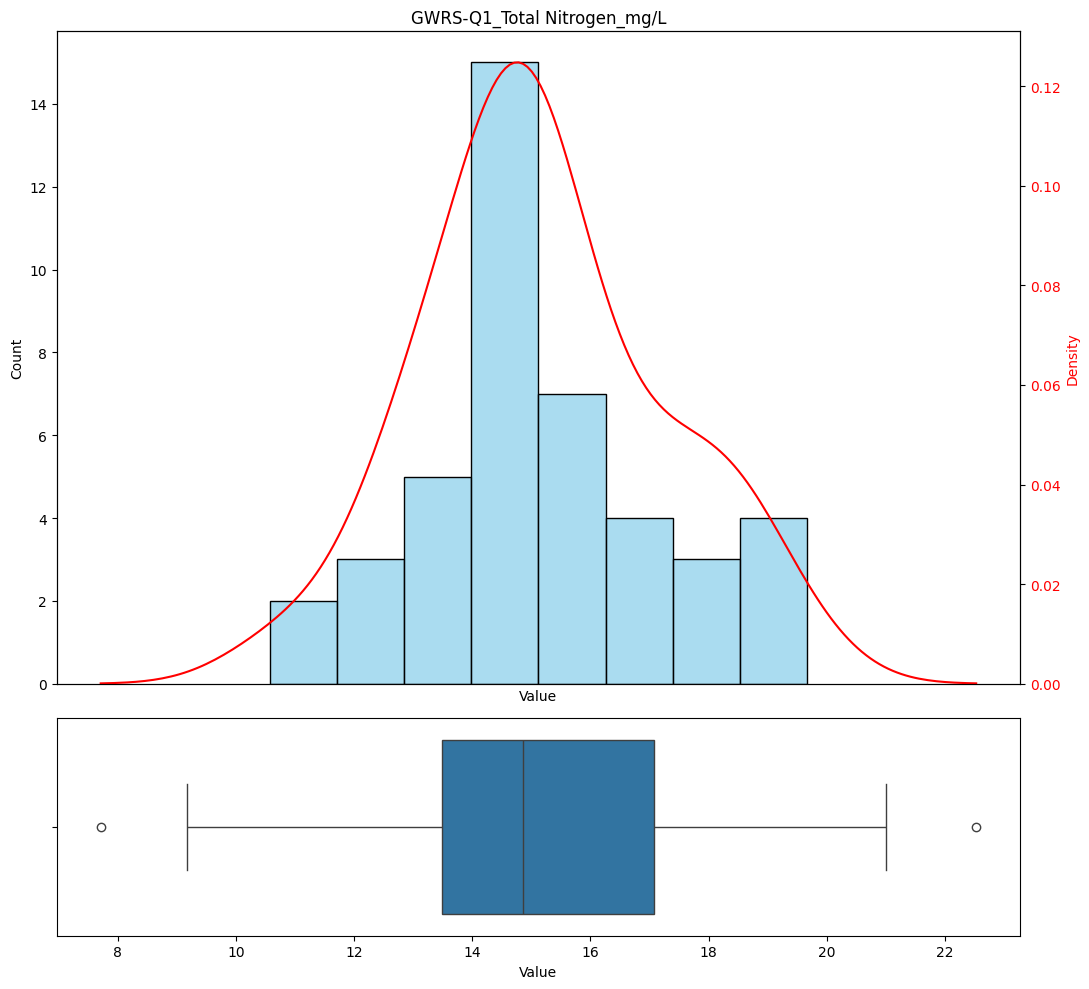

IBP Boost Pressure


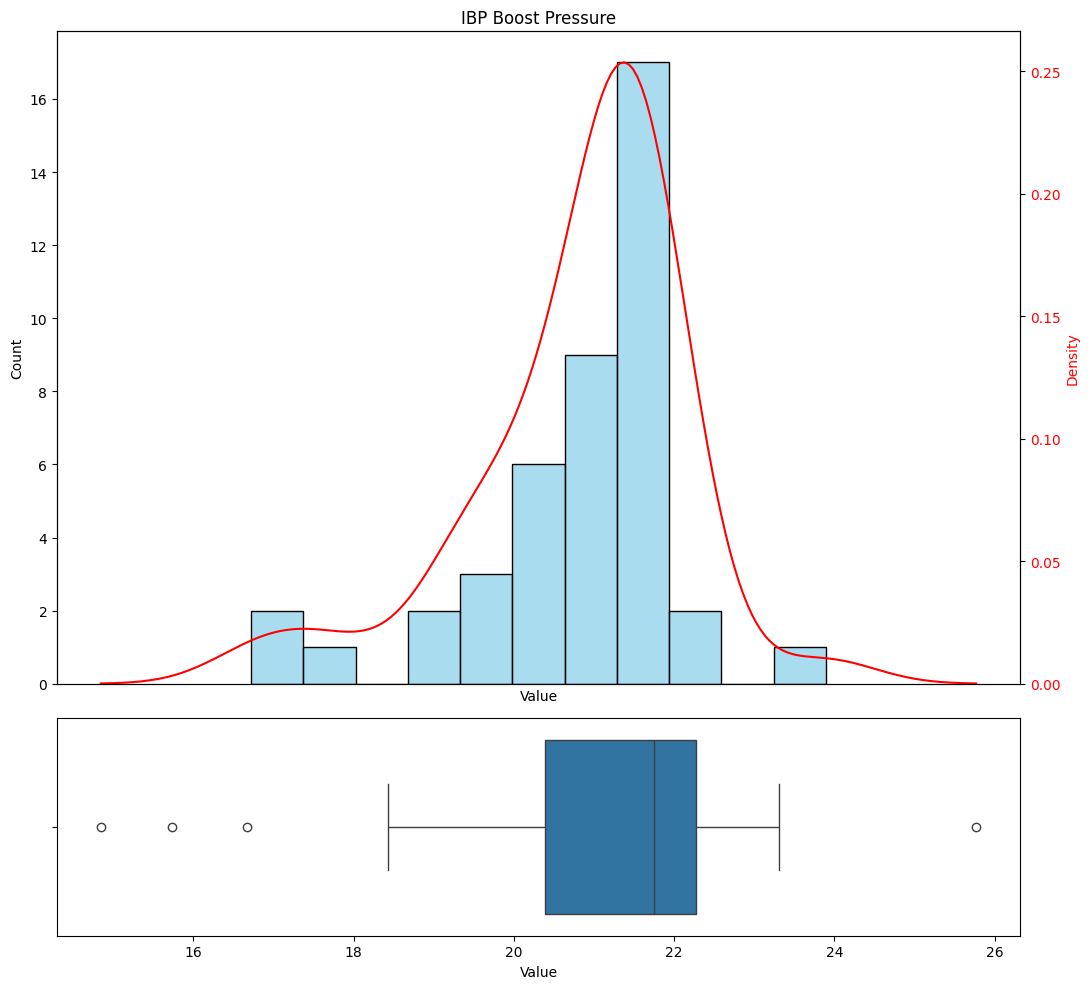

GWRS-ROP_Cl_mg/L


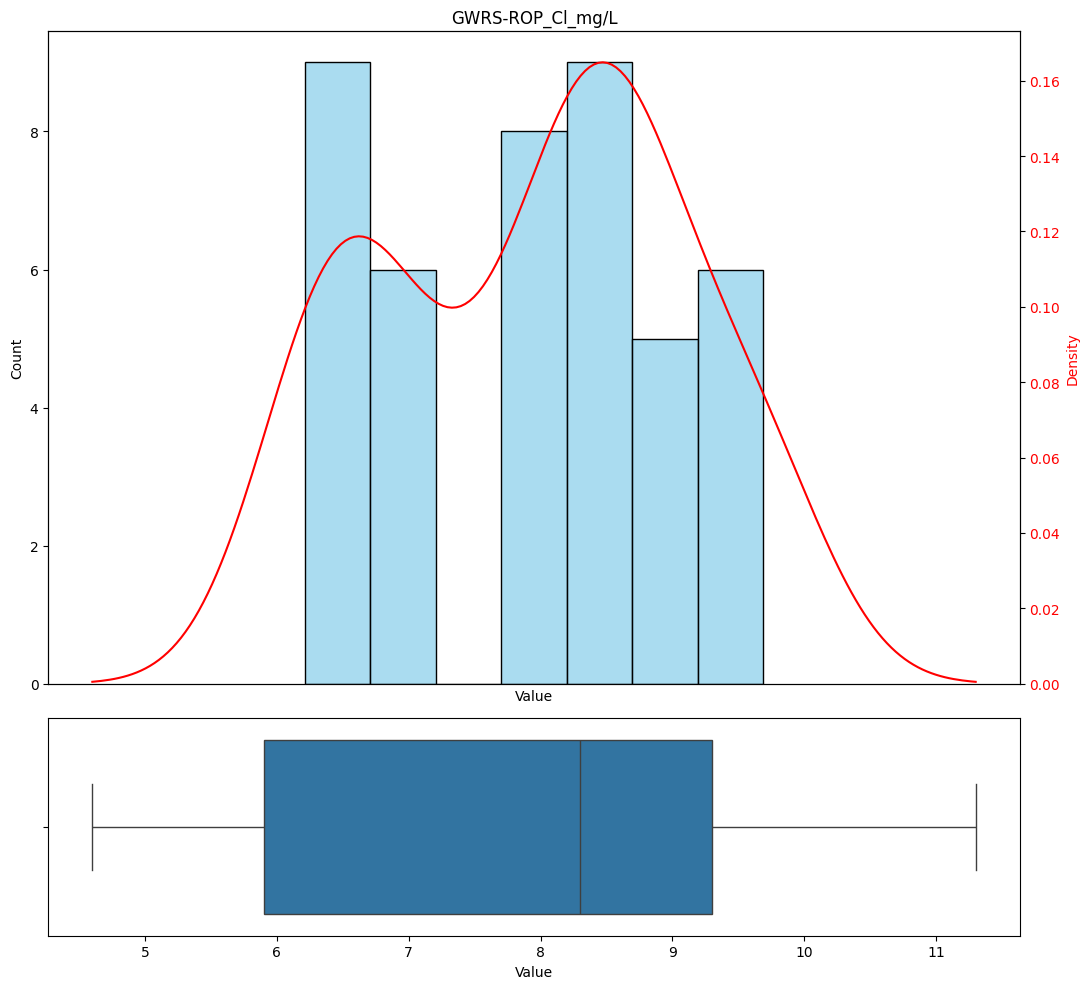

GWRS-ROP_SO4_mg/L


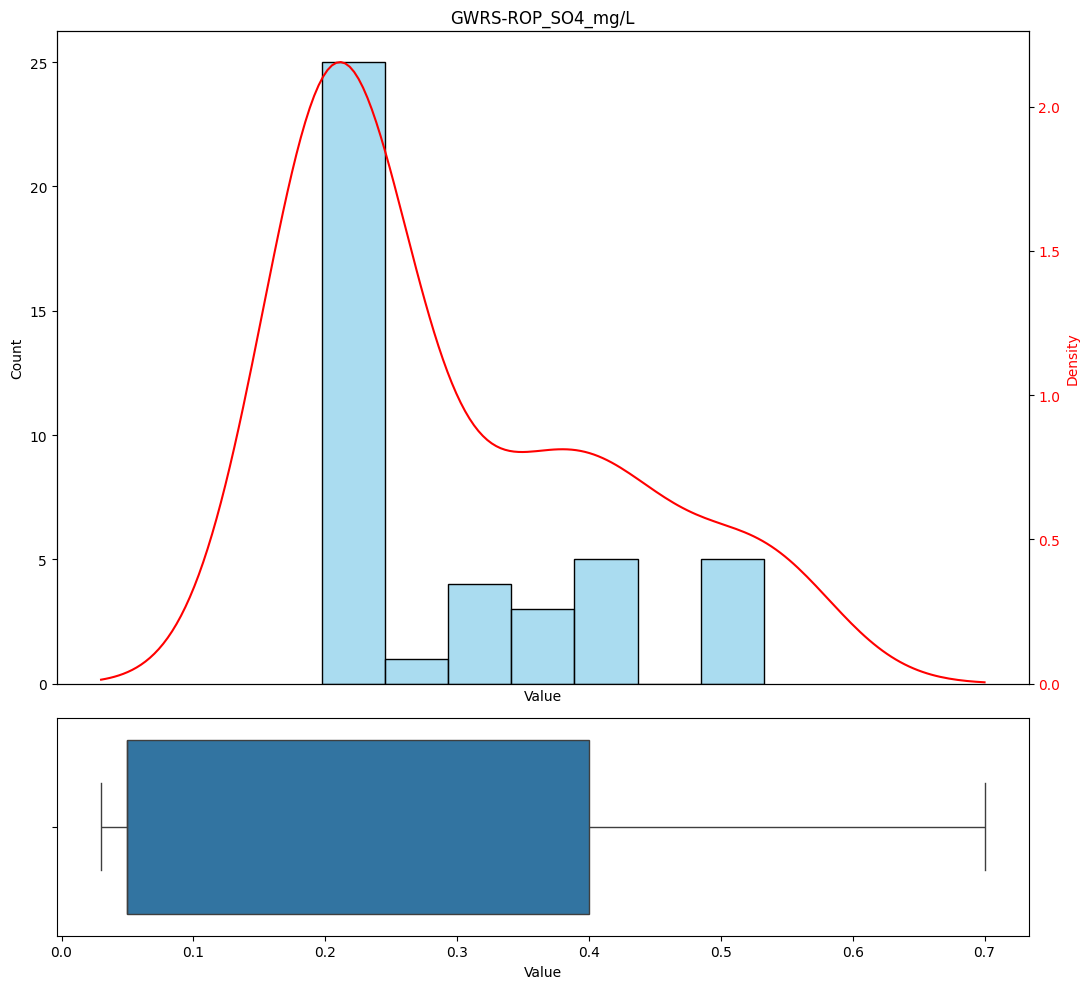

GWRS-ROF_Cl_mg/L


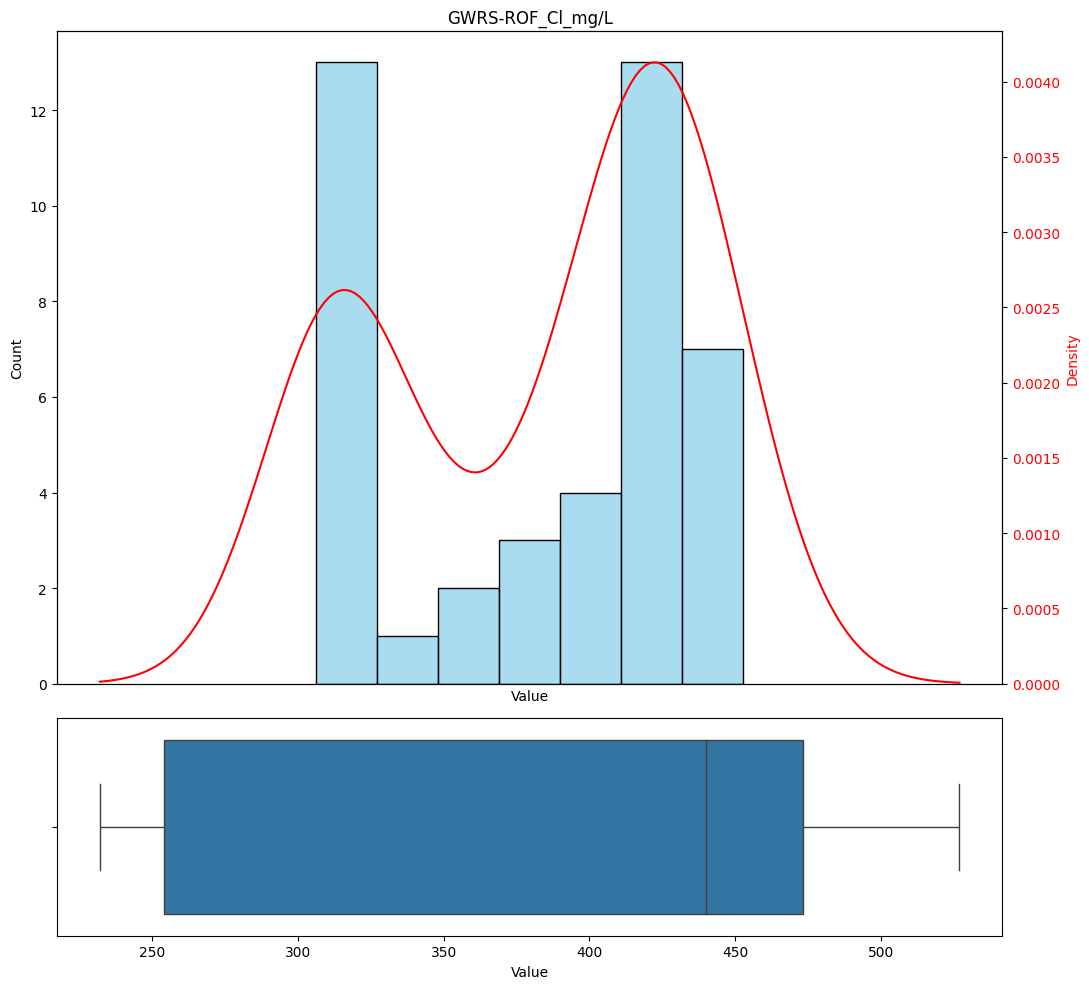

In [69]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

for k in features_s.columns:
    print(k)
    Temp = features_s[k]
    
    try:
        # Create a figure with two subplots: one for histogram + KDE, one for the box plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 10), gridspec_kw={'height_ratios': [3, 1]})
        
        # Plot histogram on primary y-axis
        sns.histplot(data=Temp, ax=ax1, kde=False, stat="count", color="skyblue", alpha=0.7)
        ax1.set_ylabel('Count')#, color='skyblue'
        ax1.tick_params(axis='y')#, labelcolor='skyblue'
        
        # Create secondary y-axis and plot KDE
        ax3 = ax1.twinx()
        sns.kdeplot(data=Temp, ax=ax3, color="red")
        ax3.set_ylabel('Density', color='red')
        ax3.tick_params(axis='y', labelcolor='red')
        
        ax1.set_title(label=k)
        ax1.set_xlabel("Value")
        ax1.set_xticks([])  # Hide x-ticks on the first plot to avoid overlap
        
        # Plot horizontal box plot
        sns.boxplot(data=Temp, ax=ax2, orient='h')
        ax2.set_xlabel("Value")
        
        # Adjust layout to prevent clipping of labels
        plt.tight_layout()
        
        plt.show()
        
    except TypeError as e:
        print("error:", e)

## MLR on E01

### Bakwards elimination

R-squared: 0.15514888523251058
Mean Squared Error: 0.8448511147674894
Model coefficients: [-0.43592218  0.91401926  0.29768666  0.16936297 -1.09961348]
Selected features: ['GWRS-ROF_Ca_mg/L', 'GWRS-ROF_Na_mg/L', 'IBP Boost Pressure', 'GWRS-ROP_SO4_mg/L', 'GWRS-ROF_Cl_mg/L']


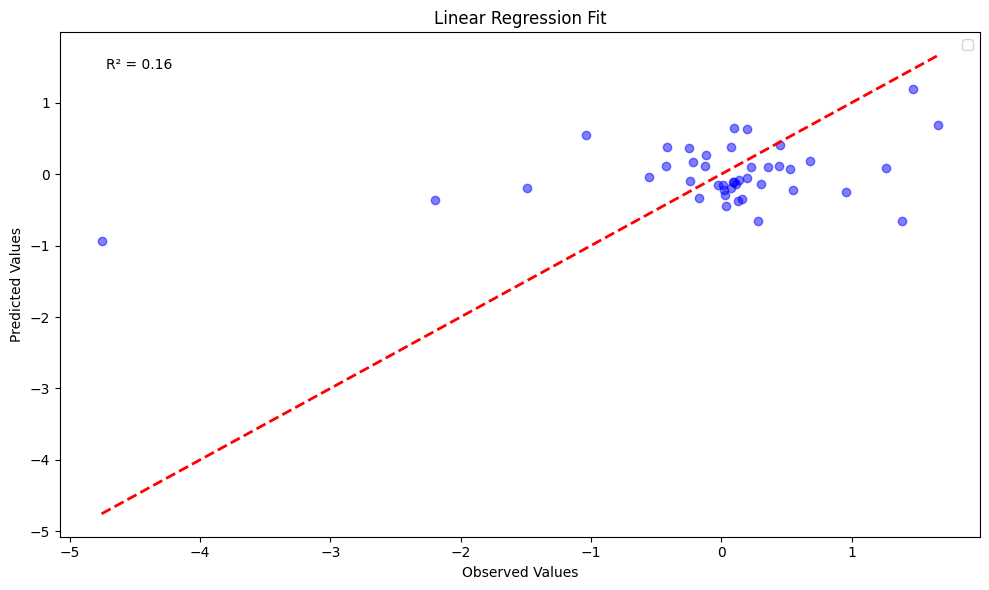

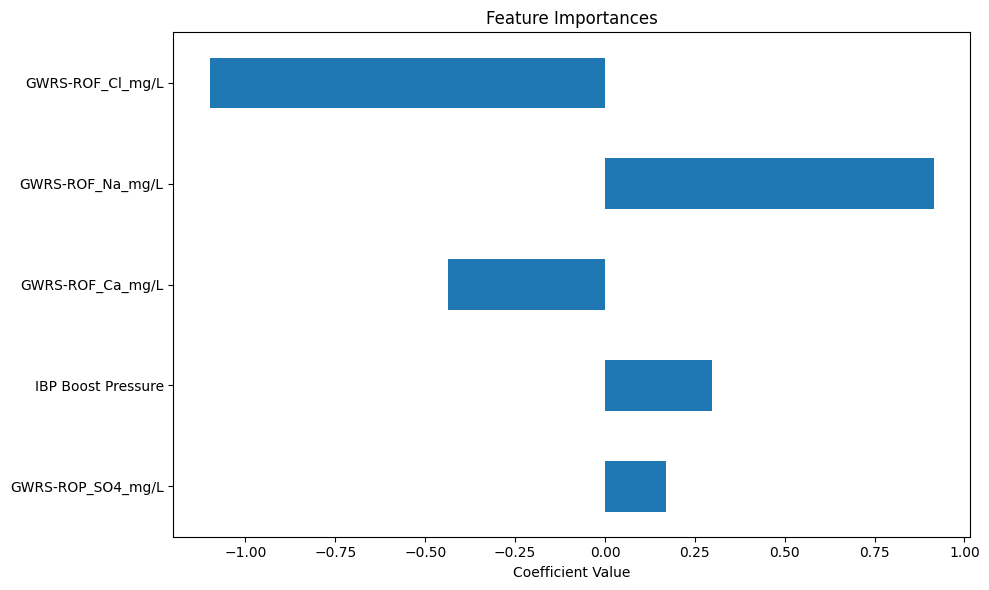

In [70]:
# Function to perform backward elimination
def backward_elimination(X, y, num_features):
    cols = list(X.columns)
    while len(cols) > num_features:
        X_with_const = sm.add_constant(X[cols])
        model = sm.OLS(y, X_with_const).fit()
        p_values = model.pvalues.iloc[1:]  # Exclude the intercept
        max_p_value = p_values.max()
        if max_p_value > 0.05:
            excluded_feature = p_values.idxmax()
            cols.remove(excluded_feature)
        else:
            break
    return X[cols]



# Create scalers
label_scaler = StandardScaler()
feature_scaler = StandardScaler()

# Fit and transform
labels_scaled = label_scaler.fit_transform(labels)
features_scaled = feature_scaler.fit_transform(features_s)

# Create DataFrames with scaled values and original column names
features_scaled_df = pd.DataFrame(features_scaled, columns=features_s.columns, index=features_s.index)
labels_scaled_df = pd.DataFrame(labels_scaled, columns=[label_column], index=labels.index)

# Perform backward elimination to reduce features from 15 to 5
features_reduced_df = backward_elimination(features_scaled_df, labels_scaled_df.values.ravel(), 5)

# Fit onto entire set
def develop_linear_regression(X, y):
    """
    Develop a linear regression model given numpy arrays of features and target,
    and plot the fitted line along with the data points.

    Parameters:
    X (np.array): 2D numpy array of features (for simple linear regression, use a single feature)
    y (np.array): 1D numpy array of target values

    Returns:
    dict: A dictionary containing the model, predictions, performance metrics, and the plot
    """
    # Ensure X is 2D
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Create and train the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate performance metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if X.shape[1] == 1:  # If it's a simple linear regression
        ax.scatter(X, y, color='blue', alpha=0.5, label='Data points')
        ax.plot(X, y_pred, color='red', label='Fitted line')
        ax.set_xlabel('X')
        ax.set_ylabel('y')
    else:  # If it's a multiple linear regression, we'll plot observed vs predicted
        ax.scatter(y, y_pred, color='blue', alpha=0.5)
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        ax.set_xlabel('Observed Values')
        ax.set_ylabel('Predicted Values')
    
    ax.set_title('Linear Regression Fit')
    ax.text(0.05, 0.95, f'R² = {r2:.2f}', transform=ax.transAxes, verticalalignment='top')
    ax.legend()
    plt.tight_layout()

    # Create a dictionary with results
    results = {
        'model': model,
        'y_pred': y_pred,
        'mse': mse,
        'r2': r2,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'plot': fig
    }

    return results

# Example usage:
X = features_reduced_df.values  # 2D numpy array
y = labels_scaled_df.values.ravel()  # 1D numpy array
results = develop_linear_regression(X, y)

# Access results:
print("R-squared:", results['r2'])
print("Mean Squared Error:", results['mse'])
print("Model coefficients:", results['coefficients'])
print("Selected features:", features_reduced_df.columns.tolist())
plt.show()  # Display the plot

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(results['coefficients'], index=features_reduced_df.columns)
feature_importance.sort_values(key=abs).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

### LASSO

R-squared: 0.15287144478327863
Mean Squared Error: 0.8471285552167214
Model coefficients: [-0.27493256 -0.13105421  0.25611737 -0.11045432  0.09424498]
Selected features: Index(['GWRS-ROF_Ca_mg/L', 'GWRS-ROC_Cu_ug/L', 'IBP Boost Pressure',
       'GWRS-ROF_Cl_mg/L', 'GWRS-ROP_SO4_mg/L'],
      dtype='object')


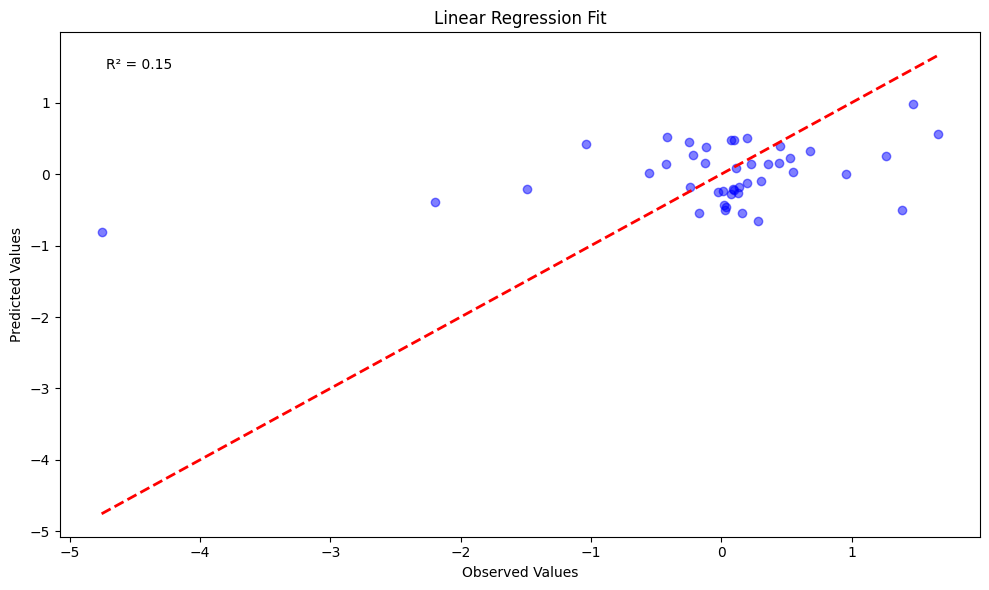

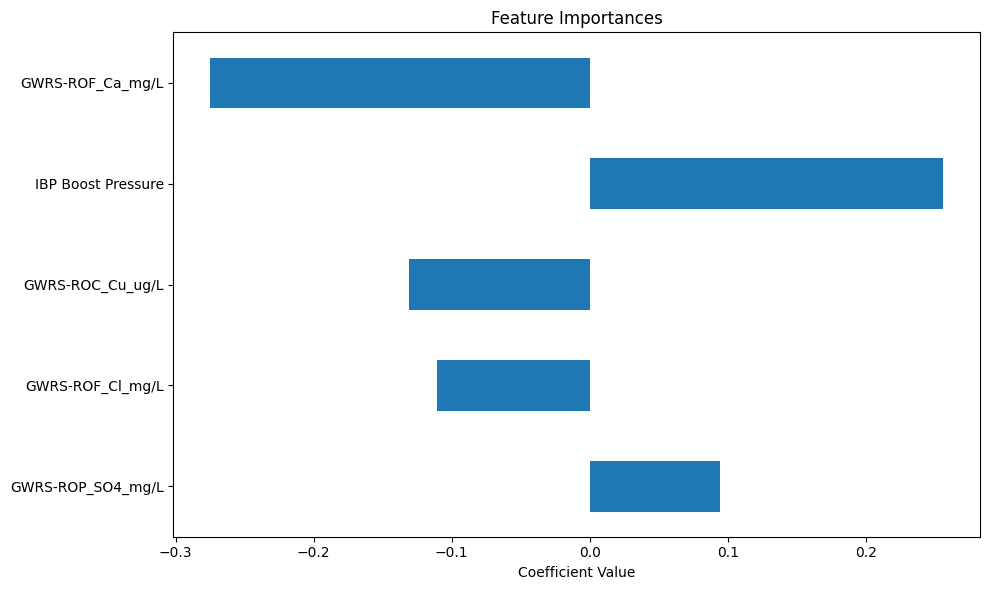

In [71]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.linear_model import Lasso, LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler

# Function to perform feature selection using Lasso
def select_top_features_lasso(X, y, num_features, alpha=0.1):
    # Create and fit Lasso model
    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X, y)
    
    # Get non-zero coefficients
    non_zero_coef_indices = np.where(lasso.coef_ != 0)[0]
    
    # Sort features by absolute coefficient value
    sorted_indices = np.argsort(np.abs(lasso.coef_))[::-1]
    
    # Select top features
    top_indices = sorted_indices[:num_features]
    top_features = X.columns[top_indices]
    
    return X[top_features], top_features

# Example usage of feature selection
# selected_Xs = top_spearman_correlated_features(features, labels.values[:,0], 15)
# features_s = features[list(selected_Xs.index.values)]

# Create scalers
label_scaler = StandardScaler()
feature_scaler = StandardScaler()

# Fit and transform
labels_scaled = label_scaler.fit_transform(labels)
features_scaled = feature_scaler.fit_transform(features_s)

# Create DataFrames with scaled values and original column names
features_scaled_df = pd.DataFrame(features_scaled, columns=features_s.columns, index=features_s.index)
labels_scaled_df = pd.DataFrame(labels_scaled, columns=[label_column], index=labels.index)

# Perform feature selection to reduce features from 15 to 5
features_reduced_df, selected_features = select_top_features_lasso(features_scaled_df, labels_scaled_df.values.ravel(), 5, alpha=0.1)

def develop_linear_regression(X, y):
    # Create and train the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate performance metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.scatter(y, y_pred, color='blue', alpha=0.5)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    ax.set_xlabel('Observed Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title('Linear Regression Fit')
    ax.text(0.05, 0.95, f'R² = {r2:.2f}', transform=ax.transAxes, verticalalignment='top')
    plt.tight_layout()

    # Create a dictionary with results
    results = {
        'model': model,
        'y_pred': y_pred,
        'mse': mse,
        'r2': r2,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'plot': fig
    }

    return results

# Example usage:
X = features_reduced_df.values  # 2D numpy array
y = labels_scaled_df.values.ravel()  # 1D numpy array
results = develop_linear_regression(X, y)

# Access results:
print("R-squared:", results['r2'])
print("Mean Squared Error:", results['mse'])
print("Model coefficients:", results['coefficients'])
print("Selected features:", selected_features)
plt.show()  # Display the plot

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(results['coefficients'], index=selected_features)
feature_importance.sort_values(key=abs).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

## H02

In [82]:
df = H02_weekly.dropna(subset=[predictands_shift1[0],predictands[0]])
df.drop(columns=['Stage 1 SF','Stage 2 SF','Stage 3 SF'],inplace=True)
# Define features and label
label_column = predictands_shift1[0]
labels = df[[label_column]]
features = df.drop(columns=[label_column]+predictands[1:]+predictands_shift1[1:])
features = drop_high_nan_columns(features,0.5)
for c in features.columns:
    print(c)

Dropped 0 columns: []
Feed Press Stage 1
Conc Press Stage 1
Feed Press Stage 2
Stage 2-3 Press
Conc Press
Perm Press Stage 1
Perm Press Unit
Perm Flow
Perm Flow Stage 2
Perm Flow Stage 3
Conc Flow
Perm EC
Perm EC Stage 1
Perm EC Stage 2
Perm EC Stage 3
Conc EC
kWH Feed Pump
Amps  ERD
ERD  kW
Temp (C.)
TCF Water
Calc Perm EC
Feed Flow
Stage 1 Perm Flow
Stage 1-2 Feed Flow
Stage 2-3 Feed Flow
Stage 1 dP
Stage 2 dP
Stage 3 dP
Stage 1 Flux
Stage 2 Flux
Stage 3 Flux
Stage 1-2 EC
Stage 1 AFBC
Stage 2 AFBC
Stage 3 AFBC
Stage 1 NdeltaP
Stage 2 NdeltaP
Stage 3 NdeltaP
Stage 1 NPC
Stage 2 NPC
Stage 3 NPC
Stage 1 Net Driving Press
Stage 2 Net Driving Press
Stage 3 Net Driving Press
Stage 1 Percent Removal
Stage 2 Percent  Removal
Stage 3 Percent Removal
Stage 1 Norm Removal
Stage 2 Norm Removal
Stage 3 Norm Removal
Stage 1 Norm Pressure
Stage 2 Norm Pressure
Stage 3 Norm Pressure
Calc Conc Corr factor
Calc 2-3 Cond
Calc Conc Cond
Area Weighted Specific Flux
Flow Weighted Specific Flux
Unit DP
Uni

## Plot potential features and target

In [83]:
# Example usage of backward elimination
selected_Xs = top_spearman_correlated_features(features, labels.values[:,0], 15)
features_s = features[list(selected_Xs.index.values)]
print(list(selected_Xs.index.values))
# drop arbitrary columns
#features_s.drop(columns=['GWRS-ROC_Na_mg/L','GWRS-ROC_Mg_mg/L','GWRS-ROC_K_mg/L','GWRS-ROC_Ca_mg/L'], inplace=True)
print(features_s.columns)

['Stage 2 NPC', 'Perm EC Stage 2', 'GWRS-ROF_SiO2_mg/L', 'Calc Perm EC', 'Perm EC', 'Unit Recovery', 'Perm EC Stage 3', 'Stage 1 Norm Percent Salt Passage', 'Stage 1 Norm Removal', 'Total KW', 'GWRS-ROP_Cl_mg/L', 'GWRS-ROC_K_mg/L', 'GWRS-ROP_Alkalinity (CaCO3)_mg/L', 'Stage 1 Norm Pressure', 'Perm Press Stage 1']
Index(['Stage 2 NPC', 'Perm EC Stage 2', 'GWRS-ROF_SiO2_mg/L', 'Calc Perm EC',
       'Perm EC', 'Unit Recovery', 'Perm EC Stage 3',
       'Stage 1 Norm Percent Salt Passage', 'Stage 1 Norm Removal', 'Total KW',
       'GWRS-ROP_Cl_mg/L', 'GWRS-ROC_K_mg/L',
       'GWRS-ROP_Alkalinity (CaCO3)_mg/L', 'Stage 1 Norm Pressure',
       'Perm Press Stage 1'],
      dtype='object')


Stage 2 NPC


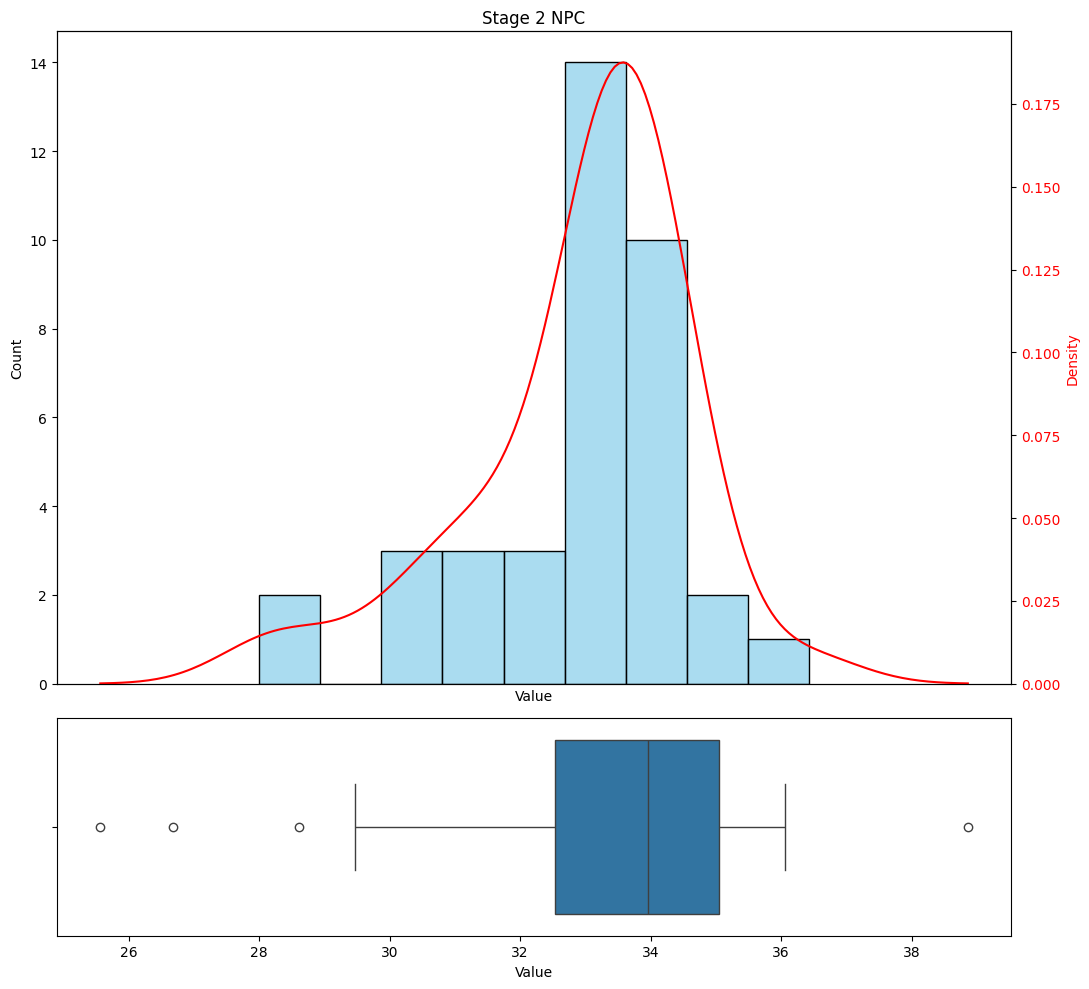

Perm EC Stage 2


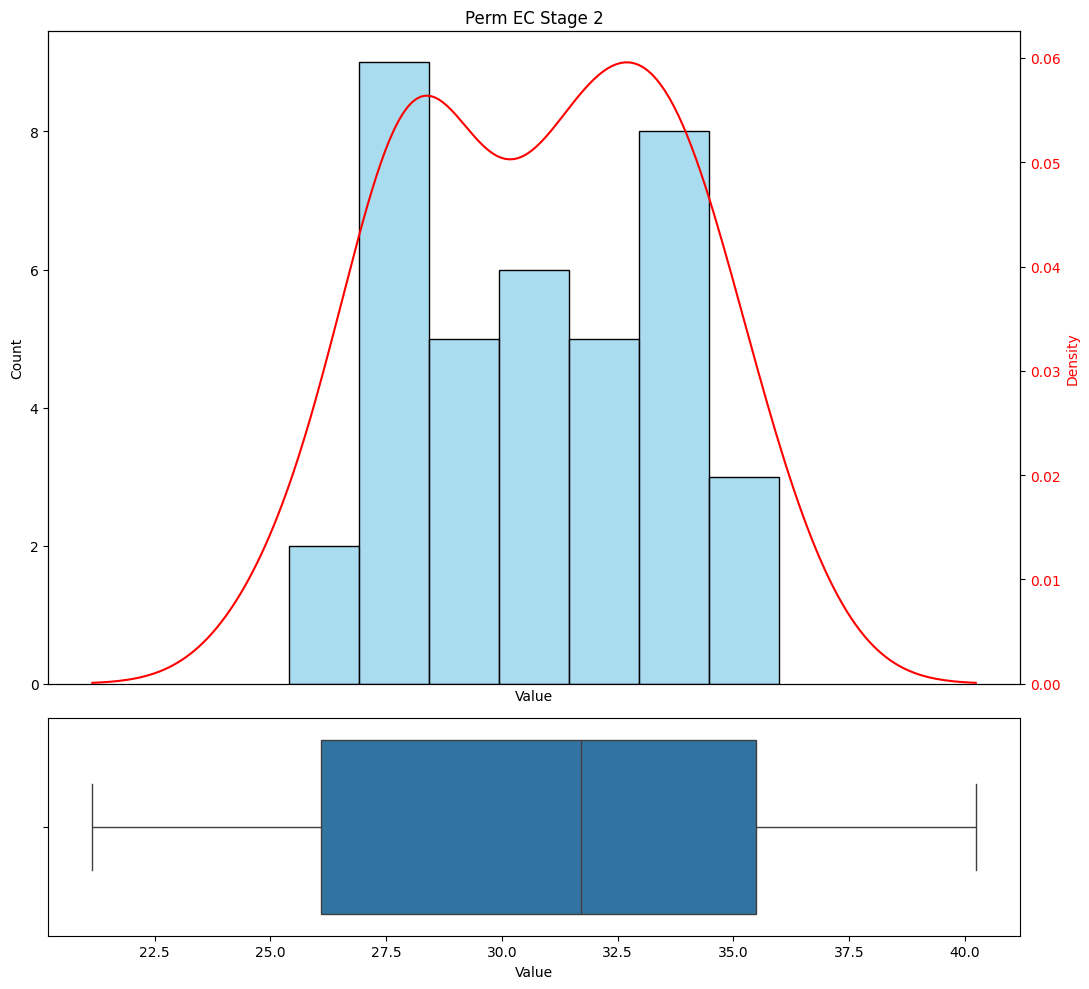

GWRS-ROF_SiO2_mg/L


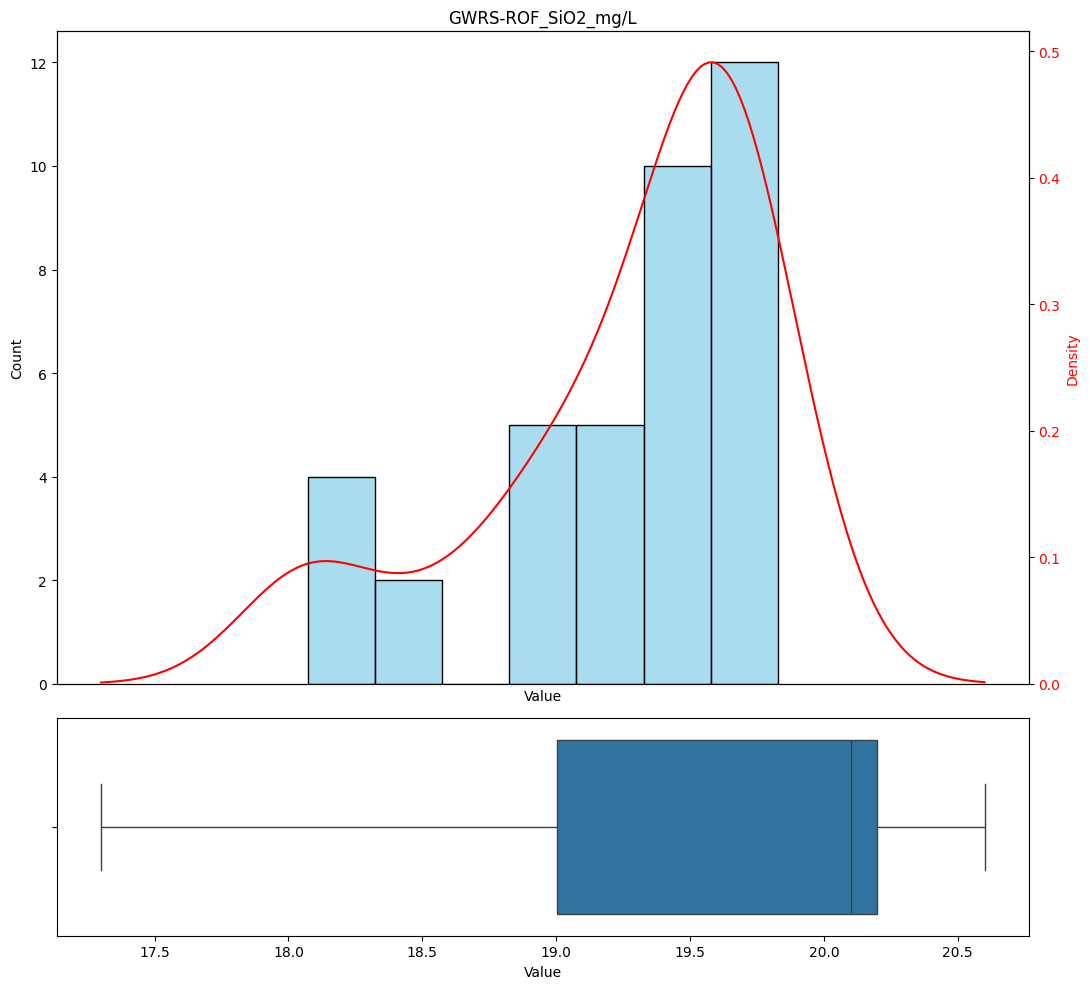

Calc Perm EC


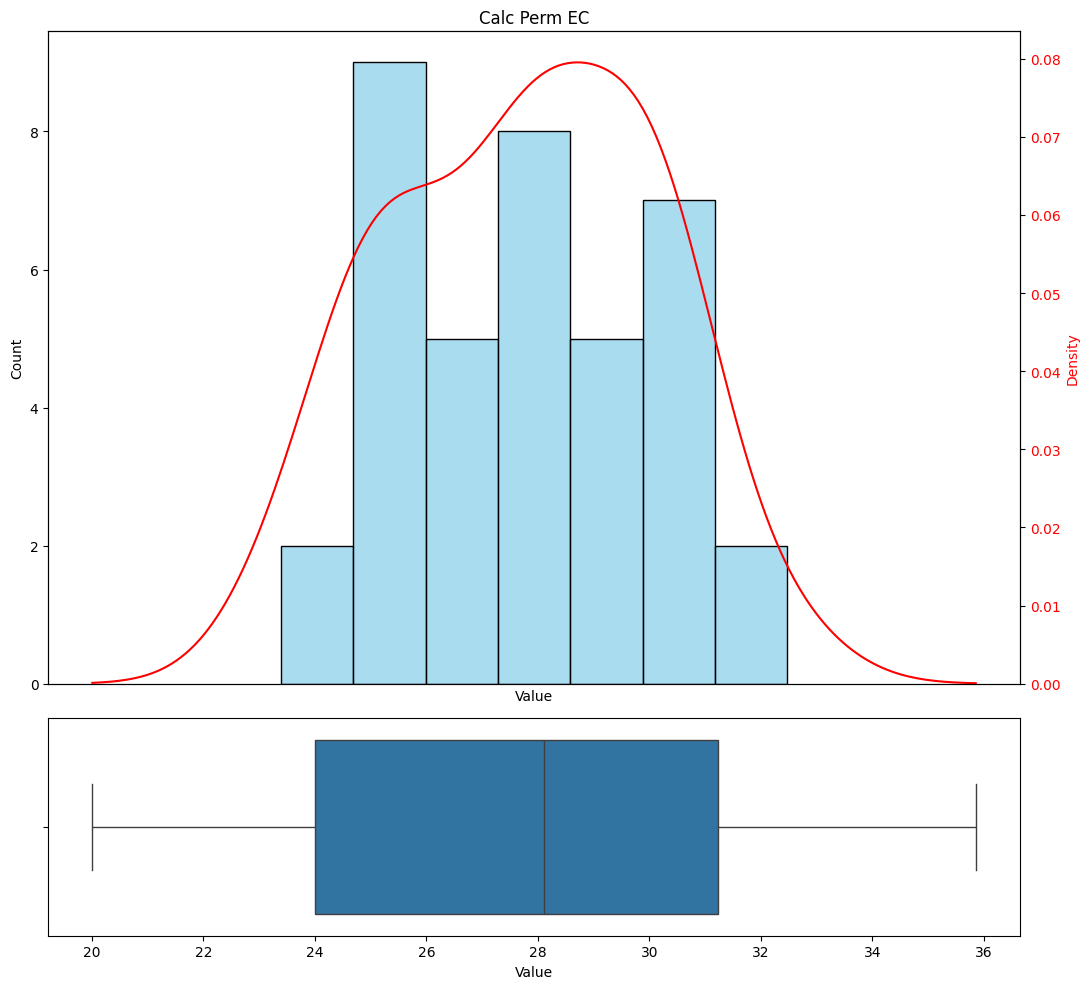

Perm EC


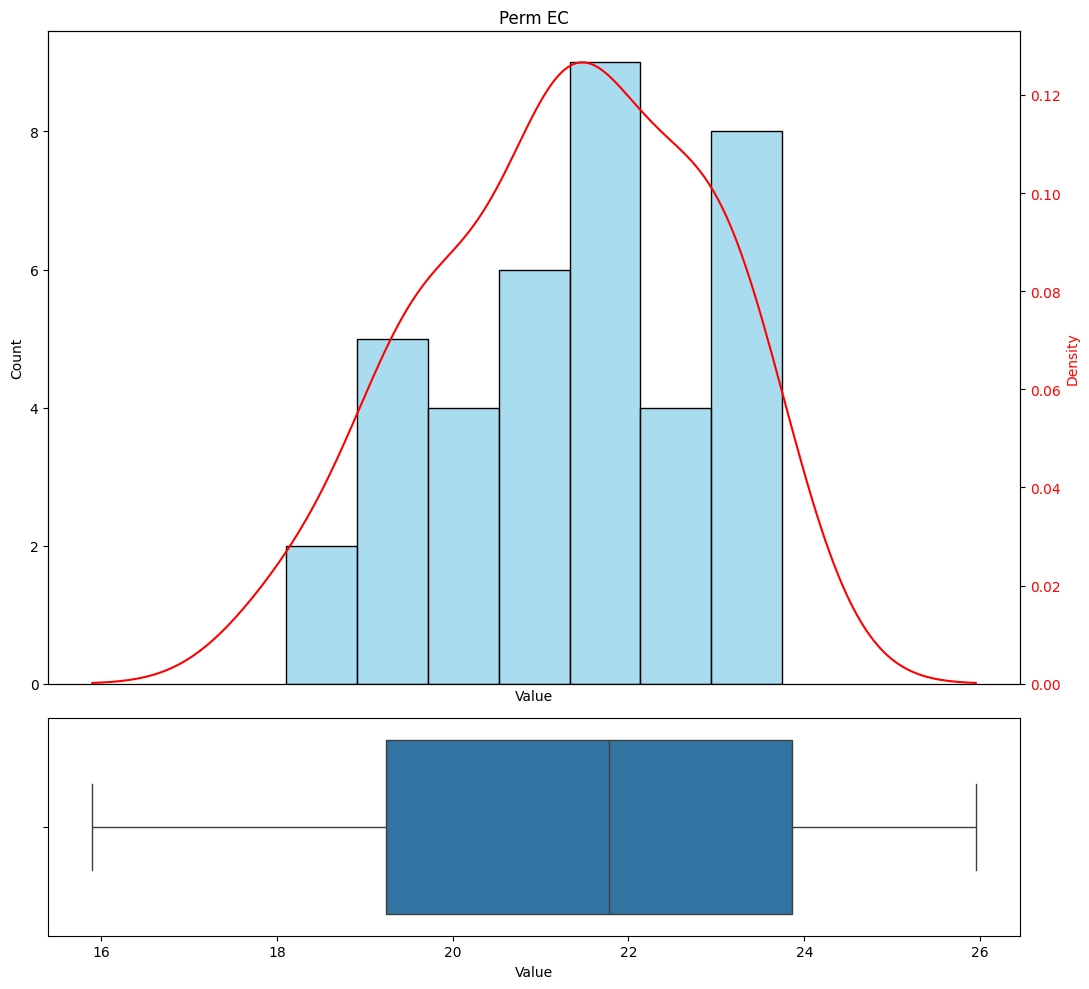

Unit Recovery


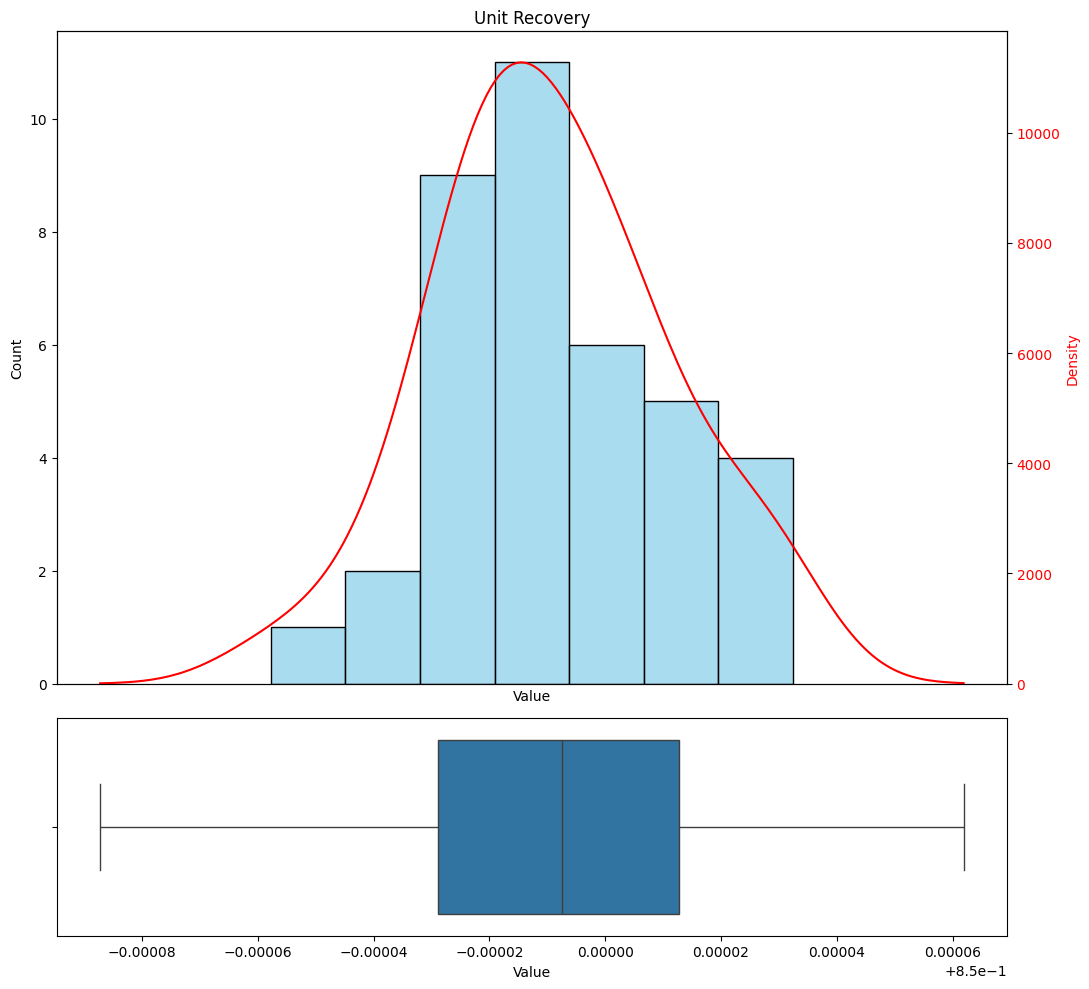

Perm EC Stage 3


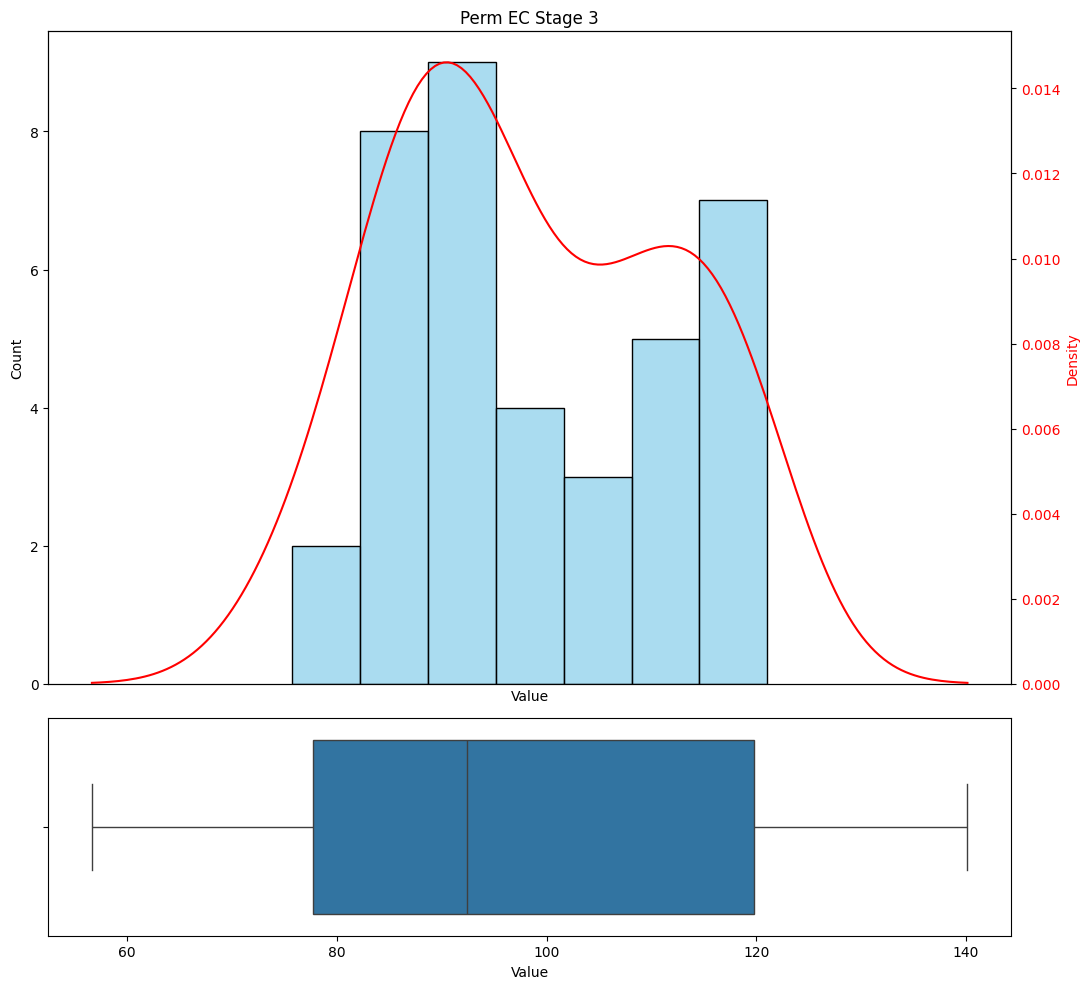

Stage 1 Norm Percent Salt Passage


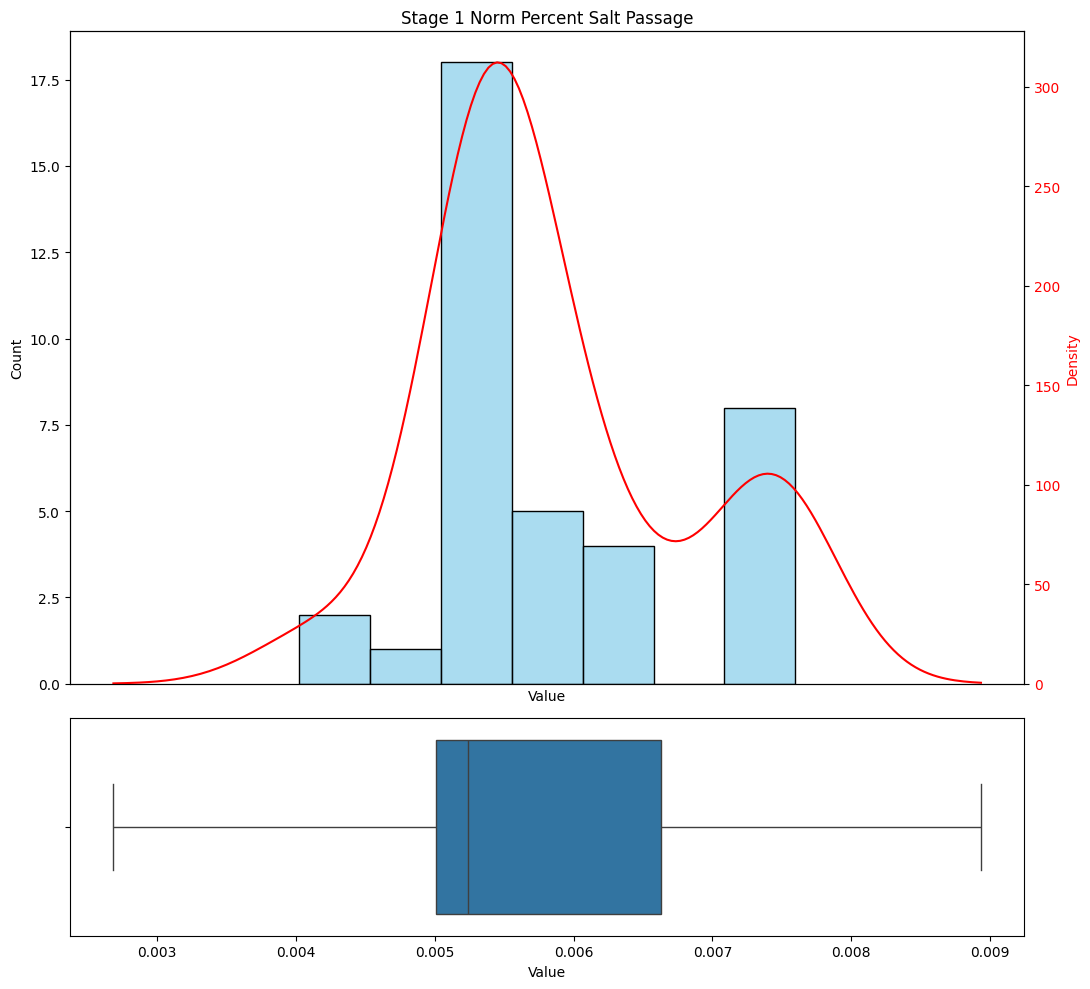

Stage 1 Norm Removal


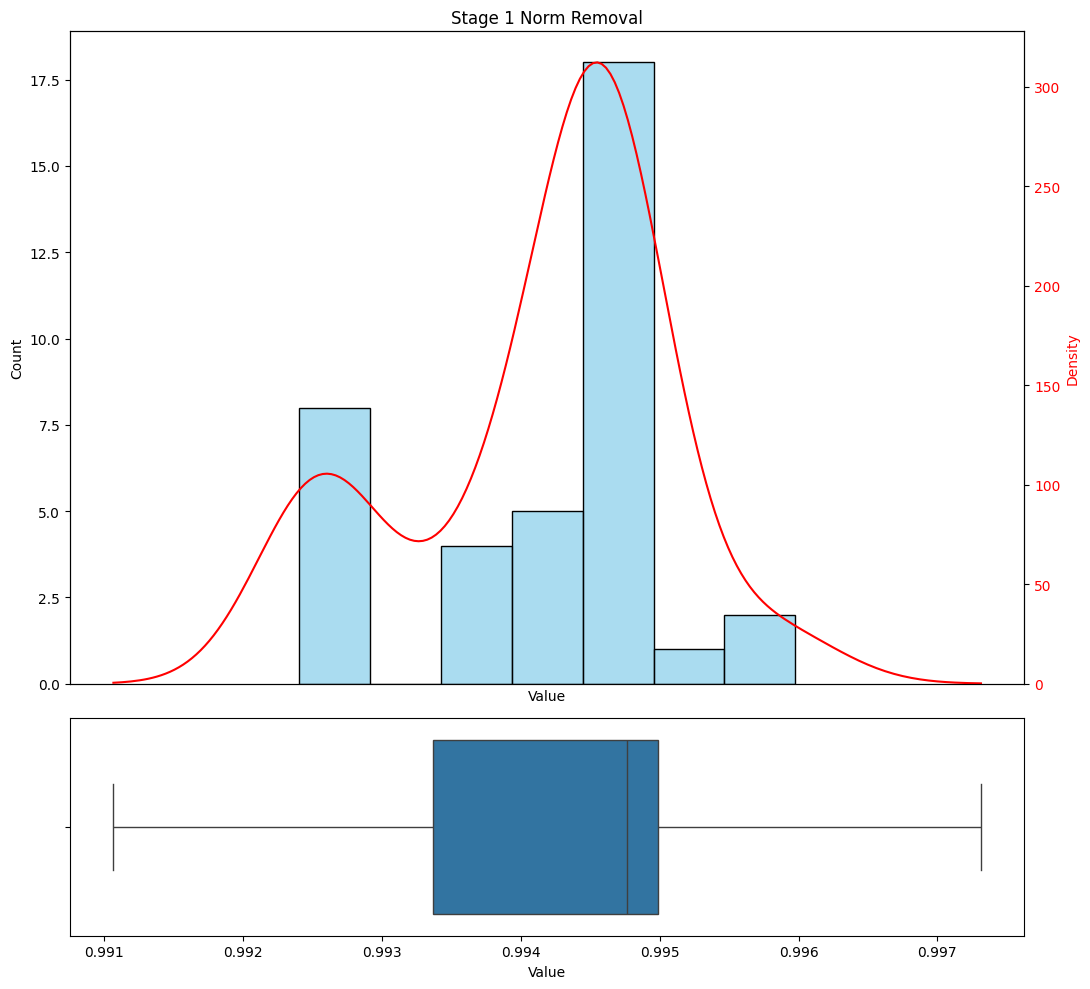

Total KW


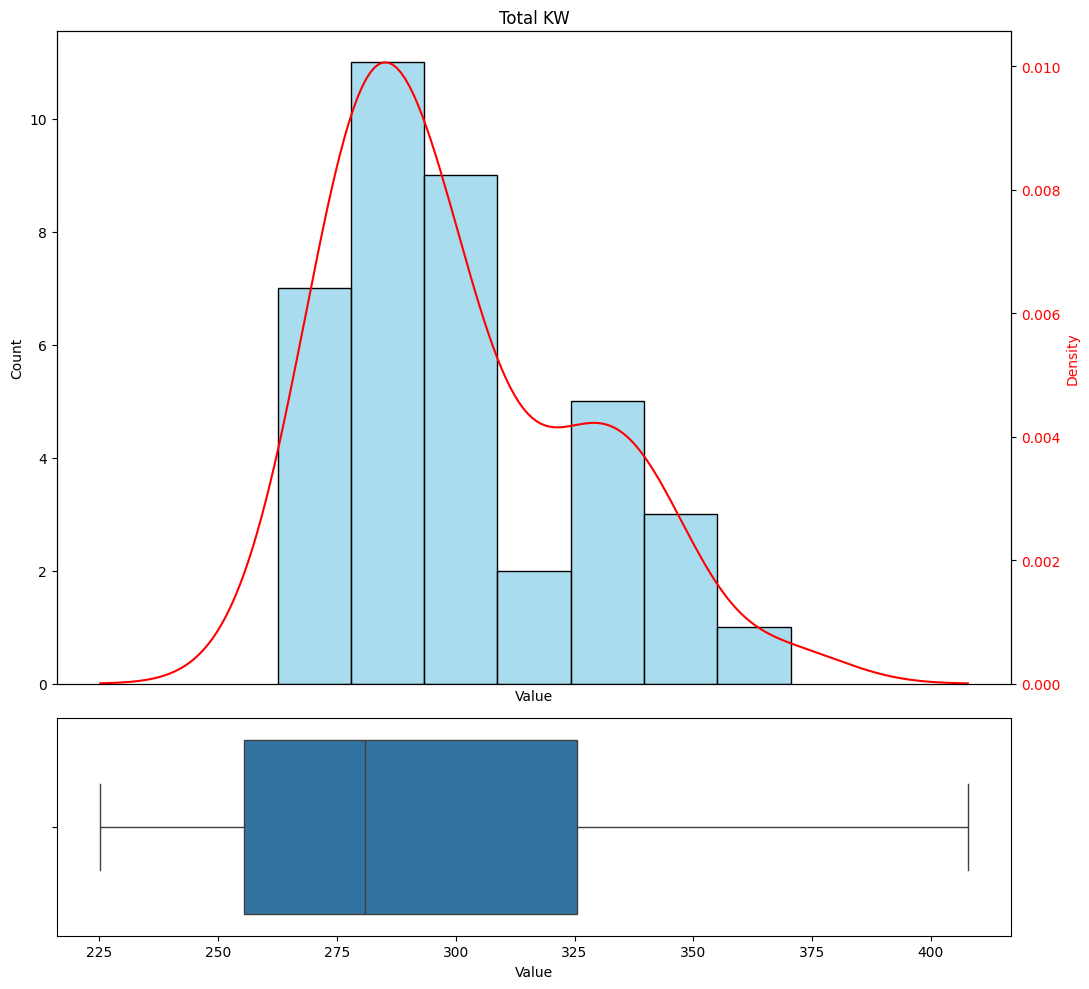

GWRS-ROP_Cl_mg/L


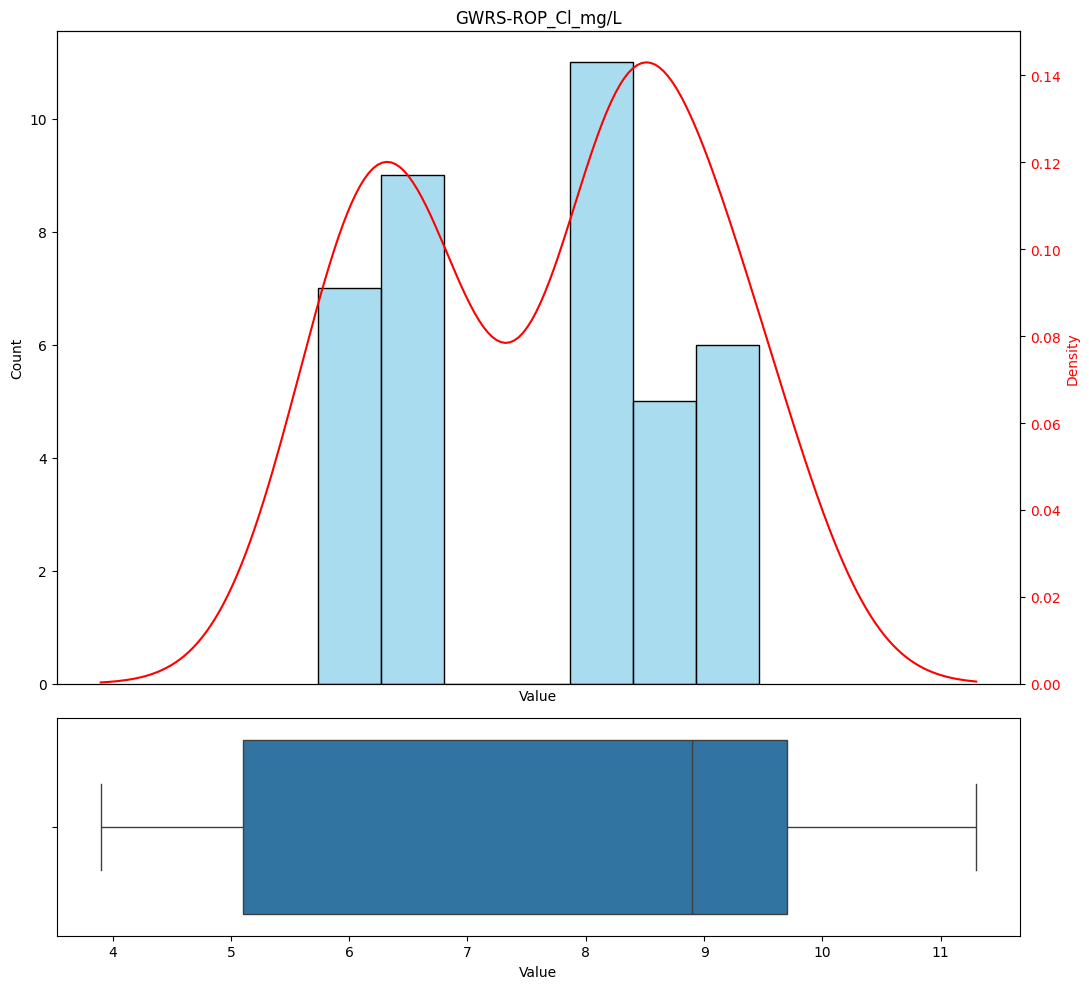

GWRS-ROC_K_mg/L


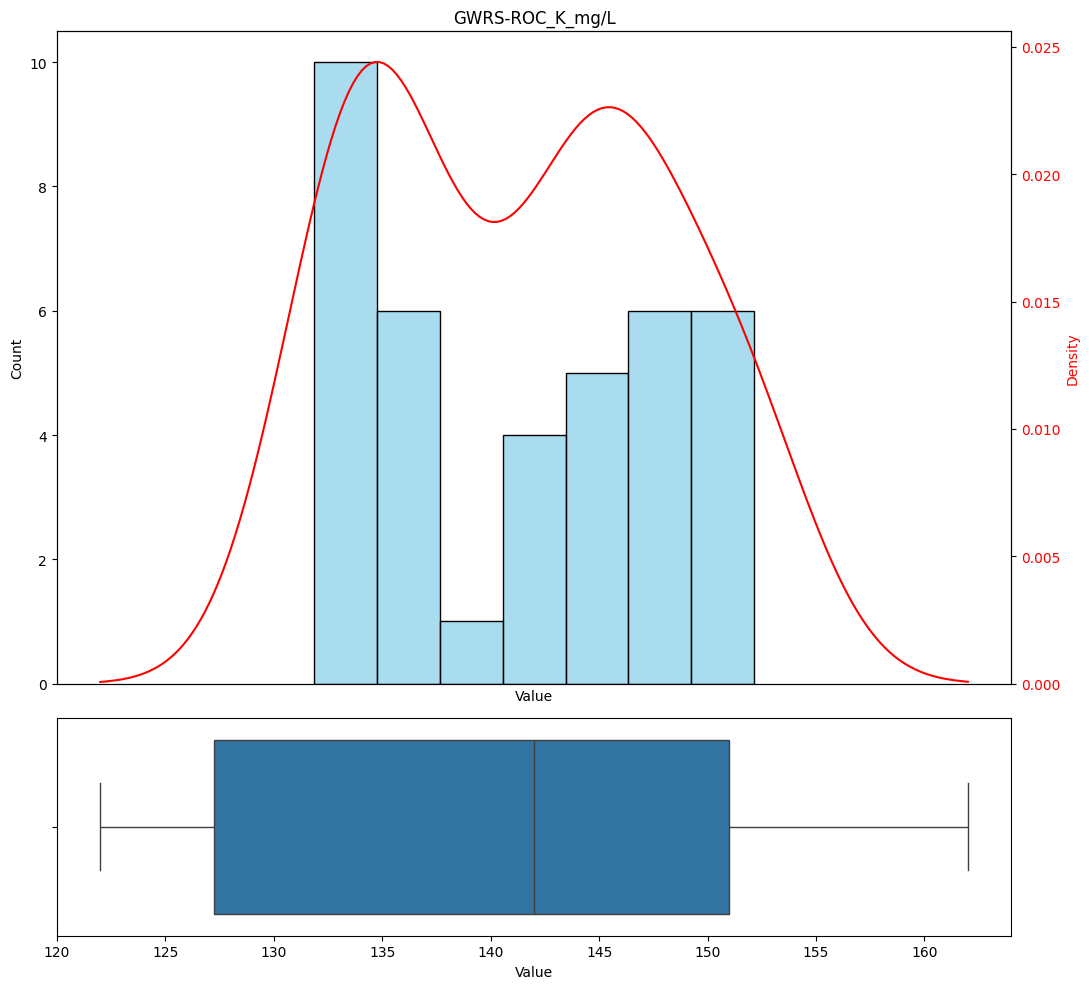

GWRS-ROP_Alkalinity (CaCO3)_mg/L


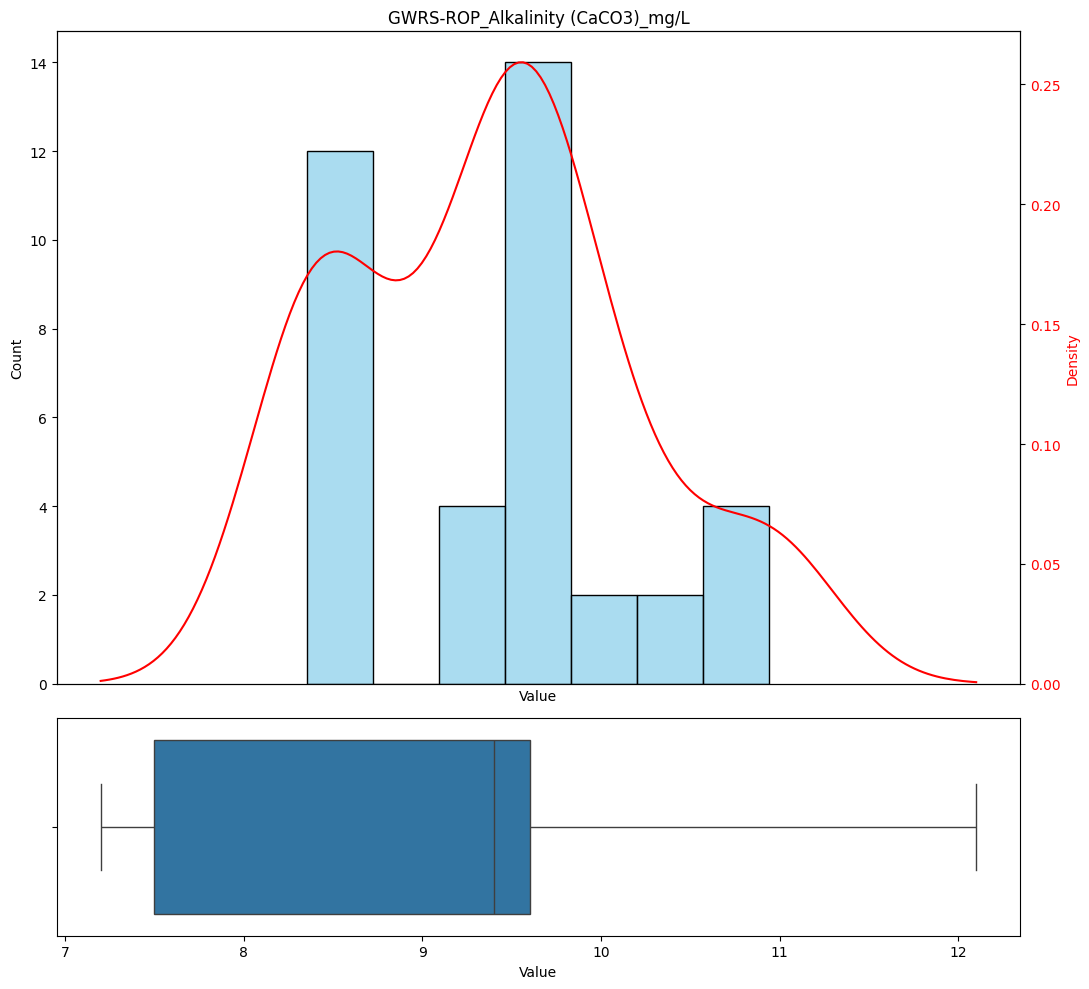

Stage 1 Norm Pressure


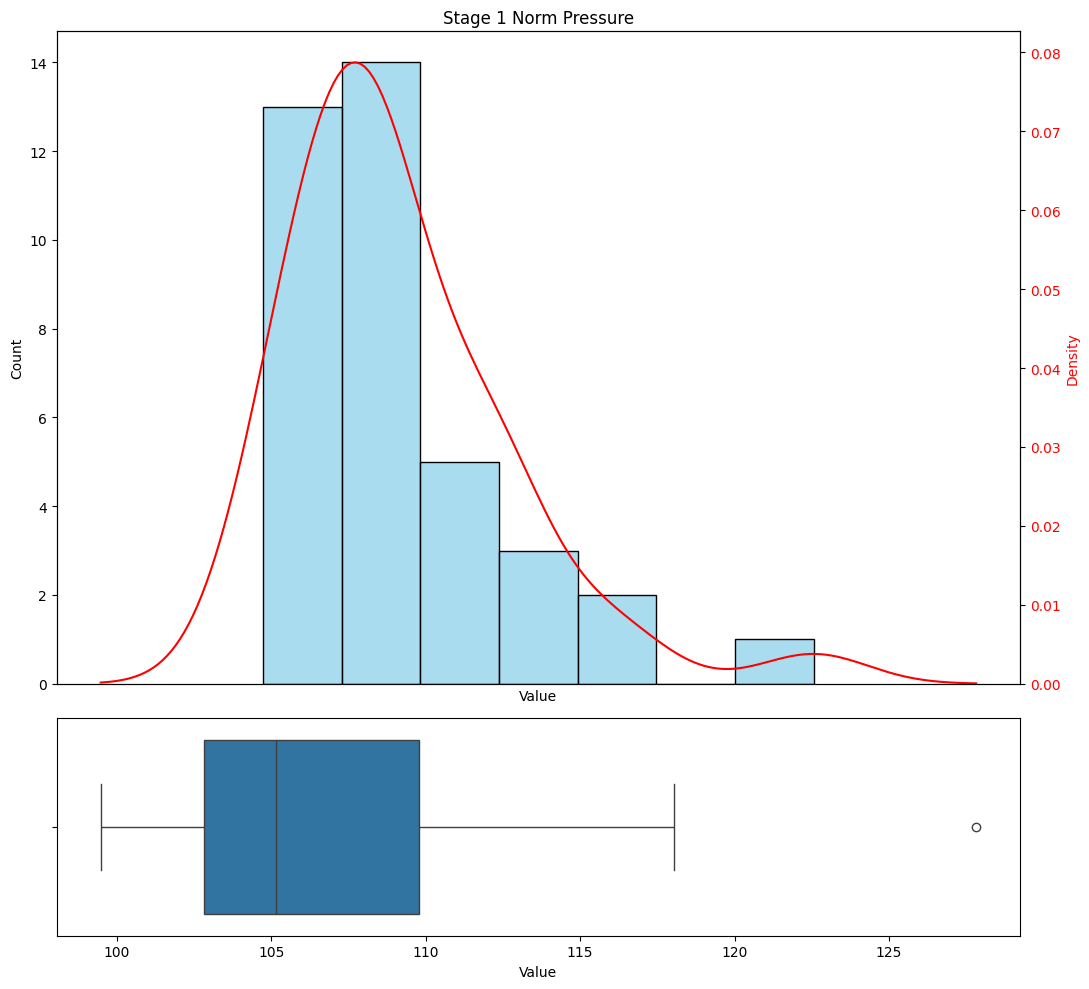

Perm Press Stage 1


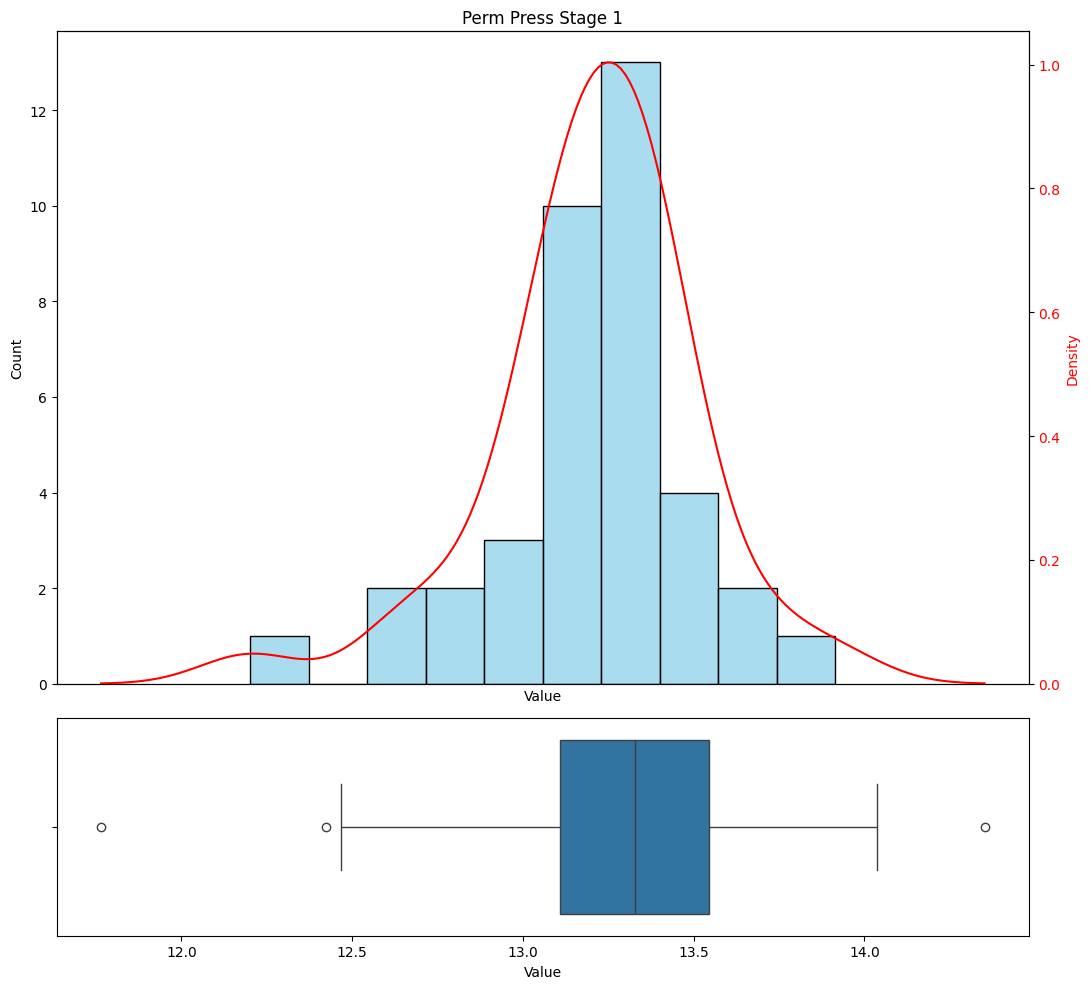

In [84]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

for k in features_s.columns:
    print(k)
    Temp = features_s[k]
    
    try:
        # Create a figure with two subplots: one for histogram + KDE, one for the box plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 10), gridspec_kw={'height_ratios': [3, 1]})
        
        # Plot histogram on primary y-axis
        sns.histplot(data=Temp, ax=ax1, kde=False, stat="count", color="skyblue", alpha=0.7)
        ax1.set_ylabel('Count')#, color='skyblue'
        ax1.tick_params(axis='y')#, labelcolor='skyblue'
        
        # Create secondary y-axis and plot KDE
        ax3 = ax1.twinx()
        sns.kdeplot(data=Temp, ax=ax3, color="red")
        ax3.set_ylabel('Density', color='red')
        ax3.tick_params(axis='y', labelcolor='red')
        
        ax1.set_title(label=k)
        ax1.set_xlabel("Value")
        ax1.set_xticks([])  # Hide x-ticks on the first plot to avoid overlap
        
        # Plot horizontal box plot
        sns.boxplot(data=Temp, ax=ax2, orient='h')
        ax2.set_xlabel("Value")
        
        # Adjust layout to prevent clipping of labels
        plt.tight_layout()
        
        plt.show()
        
    except TypeError as e:
        print("error:", e)

## MLR on H02

### Bakwards elimination

R-squared: 0.7771957791700254
Mean Squared Error: 0.22280422082997461
Model coefficients: [-2.93007281  0.36920407  2.49156789  0.82435543 -1.25967841 -2.22918534
  0.67451965  1.48006304]
Selected features: ['Perm EC Stage 2', 'GWRS-ROF_SiO2_mg/L', 'Perm EC Stage 3', 'Stage 1 Norm Removal', 'Total KW', 'GWRS-ROP_Cl_mg/L', 'GWRS-ROC_K_mg/L', 'GWRS-ROP_Alkalinity (CaCO3)_mg/L']


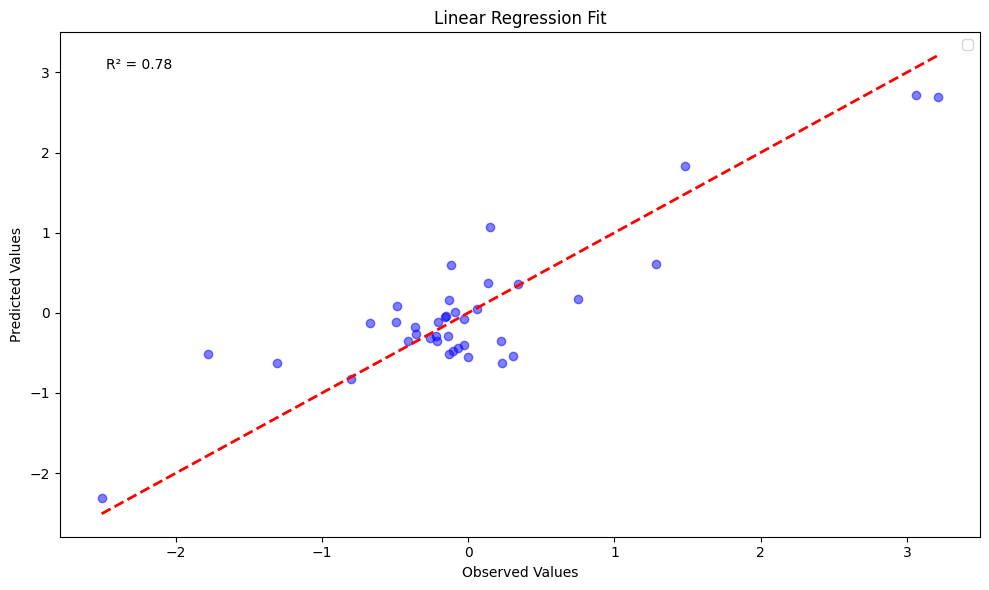

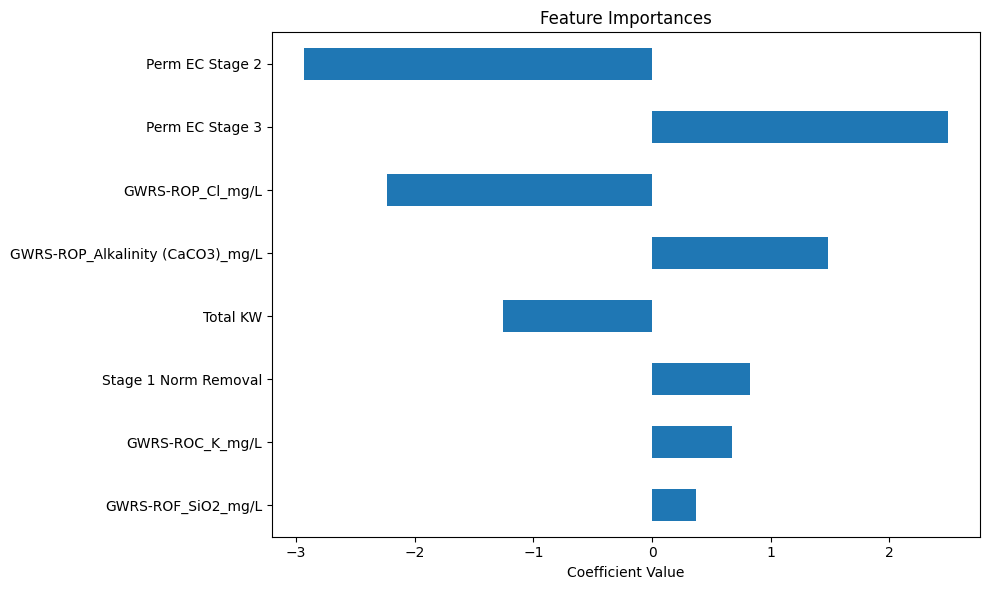

In [85]:
# Function to perform backward elimination
def backward_elimination(X, y, num_features):
    cols = list(X.columns)
    while len(cols) > num_features:
        X_with_const = sm.add_constant(X[cols])
        model = sm.OLS(y, X_with_const).fit()
        p_values = model.pvalues.iloc[1:]  # Exclude the intercept
        max_p_value = p_values.max()
        if max_p_value > 0.05:
            excluded_feature = p_values.idxmax()
            cols.remove(excluded_feature)
        else:
            break
    return X[cols]



# Create scalers
label_scaler = StandardScaler()
feature_scaler = StandardScaler()

# Fit and transform
labels_scaled = label_scaler.fit_transform(labels)
features_scaled = feature_scaler.fit_transform(features_s)

# Create DataFrames with scaled values and original column names
features_scaled_df = pd.DataFrame(features_scaled, columns=features_s.columns, index=features_s.index)
labels_scaled_df = pd.DataFrame(labels_scaled, columns=[label_column], index=labels.index)

# Perform backward elimination to reduce features from 15 to 5
features_reduced_df = backward_elimination(features_scaled_df, labels_scaled_df.values.ravel(), 5)

# Fit onto entire set
def develop_linear_regression(X, y):
    """
    Develop a linear regression model given numpy arrays of features and target,
    and plot the fitted line along with the data points.

    Parameters:
    X (np.array): 2D numpy array of features (for simple linear regression, use a single feature)
    y (np.array): 1D numpy array of target values

    Returns:
    dict: A dictionary containing the model, predictions, performance metrics, and the plot
    """
    # Ensure X is 2D
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Create and train the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate performance metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if X.shape[1] == 1:  # If it's a simple linear regression
        ax.scatter(X, y, color='blue', alpha=0.5, label='Data points')
        ax.plot(X, y_pred, color='red', label='Fitted line')
        ax.set_xlabel('X')
        ax.set_ylabel('y')
    else:  # If it's a multiple linear regression, we'll plot observed vs predicted
        ax.scatter(y, y_pred, color='blue', alpha=0.5)
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        ax.set_xlabel('Observed Values')
        ax.set_ylabel('Predicted Values')
    
    ax.set_title('Linear Regression Fit')
    ax.text(0.05, 0.95, f'R² = {r2:.2f}', transform=ax.transAxes, verticalalignment='top')
    ax.legend()
    plt.tight_layout()

    # Create a dictionary with results
    results = {
        'model': model,
        'y_pred': y_pred,
        'mse': mse,
        'r2': r2,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'plot': fig
    }

    return results

# Example usage:
X = features_reduced_df.values  # 2D numpy array
y = labels_scaled_df.values.ravel()  # 1D numpy array
results = develop_linear_regression(X, y)

# Access results:
print("R-squared:", results['r2'])
print("Mean Squared Error:", results['mse'])
print("Model coefficients:", results['coefficients'])
print("Selected features:", features_reduced_df.columns.tolist())
plt.show()  # Display the plot

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(results['coefficients'], index=features_reduced_df.columns)
feature_importance.sort_values(key=abs).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

### LASSO

R-squared: 0.5775007319831611
Mean Squared Error: 0.42249926801683896
Model coefficients: [-0.40580113 -0.39310068 -0.17386169 -0.141218   -0.1067242 ]
Selected features: Index(['Perm Press Stage 1', 'Stage 2 NPC', 'Total KW', 'GWRS-ROC_K_mg/L',
       'Unit Recovery'],
      dtype='object')


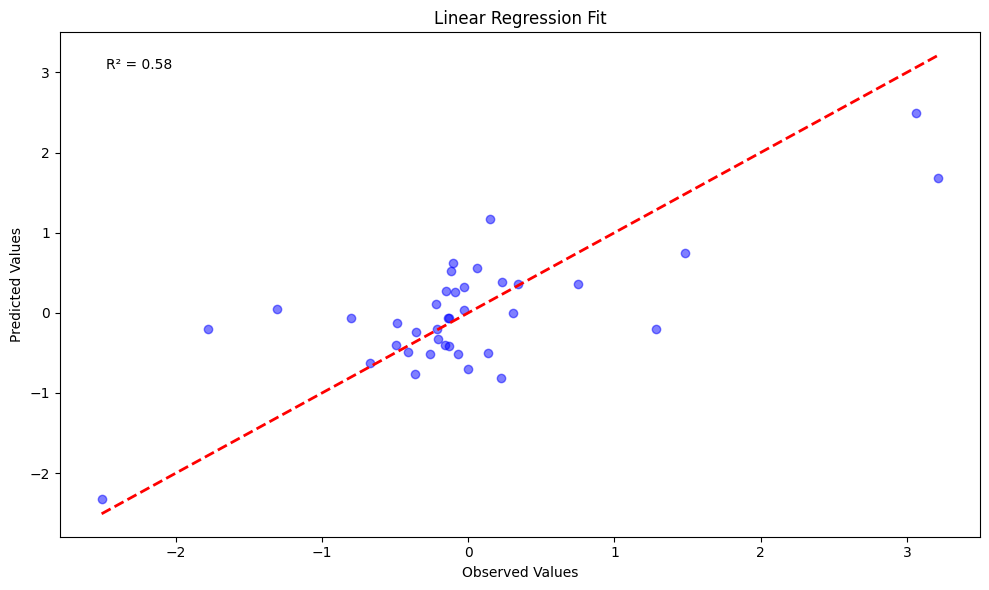

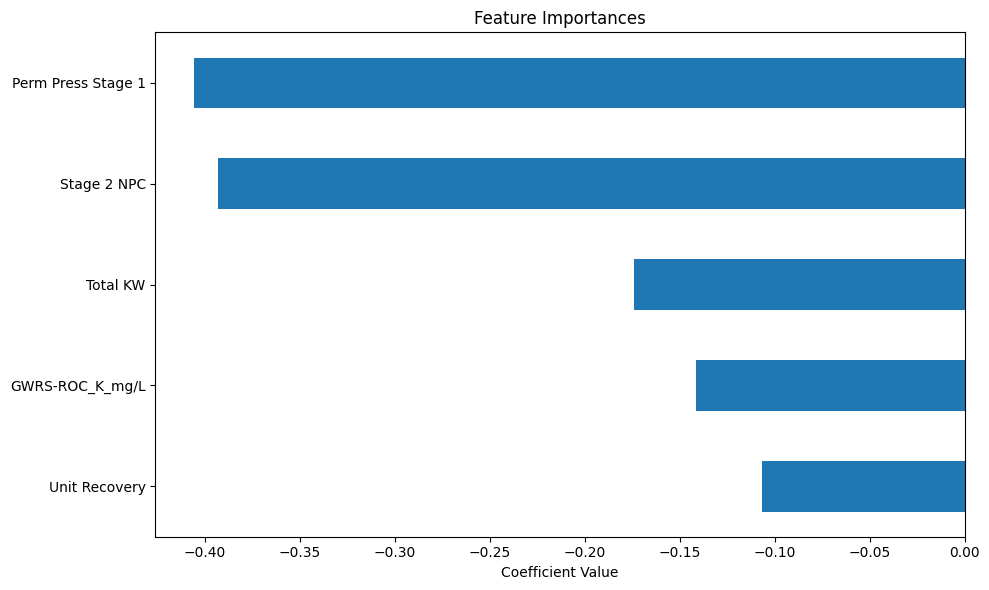

In [86]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.linear_model import Lasso, LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler

# Function to perform feature selection using Lasso
def select_top_features_lasso(X, y, num_features, alpha=0.1):
    # Create and fit Lasso model
    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X, y)
    
    # Get non-zero coefficients
    non_zero_coef_indices = np.where(lasso.coef_ != 0)[0]
    
    # Sort features by absolute coefficient value
    sorted_indices = np.argsort(np.abs(lasso.coef_))[::-1]
    
    # Select top features
    top_indices = sorted_indices[:num_features]
    top_features = X.columns[top_indices]
    
    return X[top_features], top_features

# Example usage of feature selection
# selected_Xs = top_spearman_correlated_features(features, labels.values[:,0], 15)
# features_s = features[list(selected_Xs.index.values)]

# Create scalers
label_scaler = StandardScaler()
feature_scaler = StandardScaler()

# Fit and transform
labels_scaled = label_scaler.fit_transform(labels)
features_scaled = feature_scaler.fit_transform(features_s)

# Create DataFrames with scaled values and original column names
features_scaled_df = pd.DataFrame(features_scaled, columns=features_s.columns, index=features_s.index)
labels_scaled_df = pd.DataFrame(labels_scaled, columns=[label_column], index=labels.index)

# Perform feature selection to reduce features from 15 to 5
features_reduced_df, selected_features = select_top_features_lasso(features_scaled_df, labels_scaled_df.values.ravel(), 5, alpha=0.1)

def develop_linear_regression(X, y):
    # Create and train the model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate performance metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.scatter(y, y_pred, color='blue', alpha=0.5)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    ax.set_xlabel('Observed Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title('Linear Regression Fit')
    ax.text(0.05, 0.95, f'R² = {r2:.2f}', transform=ax.transAxes, verticalalignment='top')
    plt.tight_layout()

    # Create a dictionary with results
    results = {
        'model': model,
        'y_pred': y_pred,
        'mse': mse,
        'r2': r2,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'plot': fig
    }

    return results

# Example usage:
X = features_reduced_df.values  # 2D numpy array
y = labels_scaled_df.values.ravel()  # 1D numpy array
results = develop_linear_regression(X, y)

# Access results:
print("R-squared:", results['r2'])
print("Mean Squared Error:", results['mse'])
print("Model coefficients:", results['coefficients'])
print("Selected features:", selected_features)
plt.show()  # Display the plot

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(results['coefficients'], index=selected_features)
feature_importance.sort_values(key=abs).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()